# Cutout a region in the sub-myocard

Tim delineated the patch and the myocard.
Let's use these two regions and cut out a defined subregion from them.

In [1]:
# %load_ext pycodestyle_magic

In [2]:
# %pycodestyle_on --ignore E501

In [3]:
import platform
import os
import glob
import pandas
import numpy
import imageio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import skimage.filters
import dask
import dask_image.imread
from tqdm.auto import tqdm
import math

In [4]:
# Import our own parsing functions which we've added as submodule
from BrukerSkyScanLogfileRuminator.parsing_functions import *

In [5]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
if 'Linux' in platform.system():
    tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
elif 'Darwin' in platform.system():
    import tempfile
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\')
    else:
        tmp = os.path.join('D:\\')
dask.config.set({'temporary_directory': os.path.join(tmp, 'tmp')})

In [6]:
from dask.distributed import Client
client = Client()

In [7]:
# Start dask client and tell where we can see what it does
client

<Client: 'tcp://127.0.0.1:39717' processes=8 threads=32, memory=125.79 GiB>

In [8]:
# Ignore warnings in the notebook
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['figure.dpi'] = 300  # Increase dpi

In [10]:
seaborn.set_context("notebook")

In [11]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [12]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)

In [13]:
def get_git_hash():
    """
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    """
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git', '--git-dir', os.path.join(os.getcwd(), '.git'),
                        'rev-parse', '--short', '--verify', 'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [14]:
# What are we working with?
the_current_git_hash = get_git_hash()
print('We are working with version %s of the analyis notebook.'
      % the_current_git_hash)

We are working with version 0a56f5e of the analyis notebook.


In [15]:
# Generate the output folder
# Including the git hash, so we (potentially) have different versions of all the images we generate
OutputDir = os.path.join('Output', the_current_git_hash)
os.makedirs(OutputDir, exist_ok=True)

In [16]:
# Different locations if running either on Linux or Windows
if 'anaklin' in platform.node():
    Fast_SSD = True
else:
    Fast_SSD = False
Fast_SSD = True
# to speed things up significantly
if 'Linux' in platform.system():
    if Fast_SSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
elif 'Darwin' in platform.system():
    BasePath = os.path.join('/Volumes/2TBSSD/')
else:
    if Fast_SSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('E:\\')
        else:
            BasePath = os.path.join('D:\\', 'Results')
Root = os.path.join(BasePath, 'Hearts Melly')
print('We are loading all the data from %s' % Root)

We are loading all the data from /media/habi/Fast_SSD/Hearts Melly


In [17]:
# The three cardinal directions
directions = ['Axial', 'Sagittal', 'Coronal']

In [18]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [19]:
# Get *all* log files, unsorted but fast
# This sould get us all data that is on disk
Data['LogFile'] = [os.path.join(root, name)
                   for root, dirs, files in os.walk(Root)
                   for name in files
                   if name.endswith((".log"))]

In [20]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [21]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'rectmp.log' in row.LogFile:
        Data.drop([c], inplace=True)
    elif 'ctan.log' in row.LogFile:
        Data.drop([c], inplace=True)
    elif 'batman.log' in row.LogFile:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [22]:
# Drop all folders we don't want
for c, row in Data.iterrows():
    if 'Rat' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'Rat4' in row.Folder:
        Data.drop([c], inplace=True)
    elif 'Rat5' in row.Folder:
        Data.drop([c], inplace=True)
    elif 'Test' in row.Folder:
        Data.drop([c], inplace=True)
    elif 'overview' in row.Folder:  # For Rat60 Tim delineated both `overview` and `cu_10um`
        Data.drop([c], inplace=True)
    elif 'BinaryROI' in row.Folder:  # Exclude the binarized ROIs for now
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [23]:
# Generate us some meaningful colums
Data['Samplename'] = [logfile[len(Root)+1:].split(os.sep)[0] for logfile in Data['LogFile']]
Data['Scan'] = ['.'.join(logfile[len(Root)+1:].split(os.sep)[1:-1]) for logfile in Data['LogFile']]

In [24]:
# Read in animals list from Ludovic
AnimalTable = pandas.read_excel('Animals.xlsx',
                                engine='openpyxl',
                                header=None,
                                names=['Animal', 'Gender', '', 'Experiment', 'Timepoint'])

In [25]:
# Merge in data from animals table
for c, rowdata in Data.iterrows():
    for d, rowanimals in AnimalTable.iterrows():
        if str(rowanimals.Animal) in rowdata.Samplename:
            Data.at[c, 'Animal'] = rowanimals.Animal
            Data.at[c, 'Experiment'] = rowanimals.Experiment
            Data.at[c, 'Timepoint'] = rowanimals.Timepoint
            Data.at[c, 'Gender'] = rowanimals.Gender

In [26]:
# Convert some columns to int
Data['Animal'] = Data['Animal'].astype(int)
Data['Timepoint'] = Data['Timepoint'].astype(int)

In [27]:
Data.sort_values(['Samplename', 'Scan'], inplace=True)
Data.reset_index(drop=True, inplace=True)

In [28]:
print('For %s rats we have %s folders containing a scan on disk' % (len(Data.Animal.unique()), len(Data)))

For 21 rats we have 33 folders containing a scan on disk


In [29]:
Data.Samplename.unique()

array(['Rat60', 'Rat61', 'Rat62', 'Rat63', 'Rat64', 'Rat65', 'Rat66',
       'Rat67', 'Rat68', 'Rat69', 'Rat70', 'Rat71', 'Rat79', 'Rat80',
       'Rat81', 'Rat82', 'Rat83', 'Rat84', 'Rat87', 'Rat88', 'Rat90'],
      dtype=object)

In [30]:
Data.Animal.unique()

array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 79, 80, 81, 82, 83,
       84, 87, 88, 90])

In [31]:
# Exclusion from Tims visual inspection
# R63
# R65
# R66
# R70
# exclude = [63, 65, 66, 70]

In [32]:
# Exclusion from Tims visual inspection for 2214 scans
# R67: "verstrahlt"
# R70: No tachosil
# exclude = [63, 65, 66, 70]

In [33]:
# Drop samples which should be excluded
# Based on https://stackoverflow.com/a/13851602
# for c,row in Data.iterrows():
#     for ex in exclude:
#         if str(ex) in row.Samplename:
#             Data.drop(c, inplace=True)
# Data.reset_index(drop=True, inplace=True)

In [34]:
# # "Filter" to subset that we want
# for c,row in Data.iterrows():
#     if 'cu_10um' not in row.Scan:
#         Data.drop(c, inplace=True)
# Data.reset_index(drop=True, inplace=True)

In [35]:
# Tim delineated both the patch and myocard region
# We thus duplicate the dataframe to load all regions correctly
Data = pandas.concat([Data] * 2, ignore_index=True)
# First sort by animal, then by scan so the VOI colum filling works as intended
Data.sort_values(['Samplename', 'Scan'], inplace=True)
# Fill actual VOI column with alternating values
Data['VOI'] = ['myocard', 'patch'] * (len(Data)//2)

In [36]:
Data.head(n=8)

LogFile  \
0   /media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10u...   
33  /media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10u...   
1   /media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10u...   
34  /media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10u...   
2   /media/habi/Fast_SSD/Hearts Melly/Rat62/cu_10u...   
35  /media/habi/Fast_SSD/Hearts Melly/Rat62/cu_10u...   
3   /media/habi/Fast_SSD/Hearts Melly/Rat63/2214_7...   
36  /media/habi/Fast_SSD/Hearts Melly/Rat63/2214_7...   

                                               Folder Samplename  \
0   /media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10u...      Rat60   
33  /media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10u...      Rat60   
1   /media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10u...      Rat61   
34  /media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10u...      Rat61   
2   /media/habi/Fast_SSD/Hearts Melly/Rat62/cu_10u...      Rat62   
35  /media/habi/Fast_SSD/Hearts Melly/Rat62/cu_10u...      Rat62   
3   /media/habi/Fast_SSD/Hearts Melly/Rat63/2214_7...      Rat63   
36  /media/habi/Fast_SSD/Hearts Melly/Rat63/2214_7...      Rat63   

                    Scan  Animal Experiment  Timepoint Gender      VOI  
0            cu_10um.rec      60        V+P          7      F  myocard  
33           cu_10um.rec      60        V+P          7      F    patch  
1            cu_10um.rec      61        V+P          7      F  myocard  
34           cu_10um.rec      61        V+P          7      F    patch  
2            cu_10um.rec      62          F          7      F  myocard  
35           cu_10um.rec      62          F          7      F    patch  
3   2214_7.5um_Al1mm.rec      63          F          7      F  myocard  
36  2214_7.5um_Al1mm.rec      63          F          7      F    patch

In [37]:
Data.tail(n=8)

LogFile  \
29  /media/habi/Fast_SSD/Hearts Melly/Rat87/2214_7...   
62  /media/habi/Fast_SSD/Hearts Melly/Rat87/2214_7...   
30  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...   
63  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...   
31  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...   
64  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...   
32  /media/habi/Fast_SSD/Hearts Melly/Rat90/rec/Ra...   
65  /media/habi/Fast_SSD/Hearts Melly/Rat90/rec/Ra...   

                                               Folder Samplename  \
29  /media/habi/Fast_SSD/Hearts Melly/Rat87/2214_7...      Rat87   
62  /media/habi/Fast_SSD/Hearts Melly/Rat87/2214_7...      Rat87   
30  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...      Rat88   
63  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...      Rat88   
31  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...      Rat88   
64  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...      Rat88   
32        /media/habi/Fast_SSD/Hearts Melly/Rat90/rec      Rat90   
65        /media/habi/Fast_SSD/Hearts Melly/Rat90/rec      Rat90   

                            Scan  Animal     Experiment  Timepoint Gender  \
29          2214_7.5um_Al1mm.rec      87              V          7      M   
62          2214_7.5um_Al1mm.rec      87              V          7      M   
30          2214_7.5um_Al1mm.rec      88            V+P          7      M   
63          2214_7.5um_Al1mm.rec      88            V+P          7      M   
31  2214_7.5um_Al1mm.rec_reslice      88            V+P          7      M   
64  2214_7.5um_Al1mm.rec_reslice      88            V+P          7      M   
32                           rec      90  tachosil only          7      M   
65                           rec      90  tachosil only          7      M   

        VOI  
29  myocard  
62    patch  
30  myocard  
63    patch  
31  myocard  
64    patch  
32  myocard  
65    patch

In [38]:
# Generate us a consistent folder name
Data['VOIFolder'] = [os.path.join(os.path.dirname(f),
                                  'voi_' + v) for f, v in zip(Data['Folder'], Data['VOI'])]

In [39]:
# Look for .roi files from Tim inside these generated folders above
Data['VOIFile'] = [sorted(glob.glob(os.path.join(f, '*.roi'))) for f in Data['VOIFolder']]

In [40]:
# Drop folders where no VOI file was found
# https://stackoverflow.com/a/13851602
Data.drop(Data[Data['VOIFile'].map(len) < 1].index, inplace=True)
Data.reset_index(drop=True, inplace=True)

In [41]:
print('For %s rats we have %s folders containing a scan on disk' %
      (len(Data.Animal.unique()), len(Data)))

For 20 rats we have 44 folders containing a scan on disk


In [42]:
Data.head()

LogFile  \
0  /media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10u...   
1  /media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10u...   
2  /media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10u...   
3  /media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10u...   
4  /media/habi/Fast_SSD/Hearts Melly/Rat62/cu_10u...   

                                              Folder Samplename         Scan  \
0  /media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10u...      Rat60  cu_10um.rec   
1  /media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10u...      Rat60  cu_10um.rec   
2  /media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10u...      Rat61  cu_10um.rec   
3  /media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10u...      Rat61  cu_10um.rec   
4  /media/habi/Fast_SSD/Hearts Melly/Rat62/cu_10u...      Rat62  cu_10um.rec   

   Animal Experiment  Timepoint Gender      VOI  \
0      60        V+P          7      F  myocard   
1      60        V+P          7      F    patch   
2      61        V+P          7      F  myocard   
3      61        V+P          7      F    patch   
4      62          F          7      F  myocard   

                                           VOIFolder  \
0  /media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10u...   
1  /media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10u...   
2  /media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10u...   
3  /media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10u...   
4  /media/habi/Fast_SSD/Hearts Melly/Rat62/cu_10u...   

                                             VOIFile  
0  [/media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10...  
1  [/media/habi/Fast_SSD/Hearts Melly/Rat60/cu_10...  
2  [/media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10...  
3  [/media/habi/Fast_SSD/Hearts Melly/Rat61/cu_10...  
4  [/media/habi/Fast_SSD/Hearts Melly/Rat62/cu_10...

In [43]:
# See if there are missing images in the folders
Data['VOIImages'] = [sorted(glob.glob(os.path.join(f, '*.png'))) for f in Data['VOIFolder']]
Data['Number of VOI slices'] = [len(vs) for vs in Data['VOIImages']]

In [44]:
for c, file in enumerate(Data['VOIFile']):
    if len(file):
        if Data['Number of VOI slices'][c] <= 222:
            print(Data['Samplename'][c], Data['Scan'][c],
                  Data['VOIFile'][c][0], 'has less than 222 exported files')

In [45]:
print('We habe %s folders of %s samples to look into' % (len(Data), len(Data.Samplename.unique())))

We habe 44 folders of 20 samples to look into


Now we want to get the necessary data into the dataframe

In [46]:
# Get information we need from the lofiles
Data['Scanner'] = [scanner(log) for log in Data['LogFile']]
Data['Voxelsize'] = [pixelsize(log) for log in Data['LogFile']]

In [47]:
# Always sort experiment in *this* order
DisplayOrderExperiments = sorted(Data.Experiment.unique())
ordering = [1, 2, 0, 3]
DisplayOrderExperiments[:] = [DisplayOrderExperiments[i] for i in ordering]
print('The display order of the experiments is %s' % DisplayOrderExperiments)

The display order of the experiments is ['V', 'V+P', 'F', 'tachosil only']


In [48]:
def color_based_on_timepoint(tp):
    '''Unique color for each timpeoint'''
    if tp == 7:
        return seaborn.color_palette()[0]
    elif tp == 28:
        return seaborn.color_palette()[1]

In [49]:
# Generate color (scheme), based on experiment time
Data['ColorTimepoint'] = [color_based_on_timepoint(tp) for tp in Data.Timepoint]

In [50]:
def color_based_on_scanner(scn):
    '''Unique color depending on machine we've scanned'''
    if str(1272) in scn:
        return seaborn.color_palette()[2]
    else:
        return seaborn.color_palette()[3]

In [51]:
# Generate color (scheme), based on experiment time
Data['ColorScanner'] = [color_based_on_scanner(scn) for scn in Data.Scanner]

In [52]:
def color_based_on_experiment(exp):
    '''Unique color for each experiment value'''
    if 'V+P' in exp:
        return seaborn.color_palette(n_colors=4)[0]
    elif 'F' in exp:
        return seaborn.color_palette(n_colors=4)[1]
    elif 'tachosil' in exp:
        return seaborn.color_palette(n_colors=4)[2]
    else:
        return seaborn.color_palette(n_colors=4)[3]

In [53]:
# Generate color (siterrows based on experiment type
Data['ColorExperiment'] = [color_based_on_experiment(name) for name in Data.Experiment]

Now we can actually start to load some data.
At first we load the ROI stacks exported by Tim.
He exported the data into `voi_patch` and `voi_myocard` folders, consistently.
We simply load *all* PNG files in there, and convert this data to rechunked .zarr arrays for fast access from disk.

In [54]:
Data[(Data['Animal'] == 88)]

LogFile  \
38  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...   
39  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...   
40  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...   
41  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...   

                                               Folder Samplename  \
38  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...      Rat88   
39  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...      Rat88   
40  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...      Rat88   
41  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...      Rat88   

                            Scan  Animal Experiment  Timepoint Gender  \
38          2214_7.5um_Al1mm.rec      88        V+P          7      M   
39          2214_7.5um_Al1mm.rec      88        V+P          7      M   
40  2214_7.5um_Al1mm.rec_reslice      88        V+P          7      M   
41  2214_7.5um_Al1mm.rec_reslice      88        V+P          7      M   

        VOI                                          VOIFolder  \
38  myocard  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...   
39    patch  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...   
40  myocard  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...   
41    patch  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...   

                                              VOIFile  \
38  [/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_...   
39  [/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_...   
40  [/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_...   
41  [/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_...   

                                            VOIImages  Number of VOI slices  \
38  [/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_...                  1078   
39  [/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_...                  1078   
40  [/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_...                  1078   
41  [/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_...                  1078   

         Scanner  Voxelsize  \
38  SkyScan 2214   7.500482   
39  SkyScan 2214   7.500482   
40  SkyScan 2214   7.500482   
41  SkyScan 2214   7.500482   

                                       ColorTimepoint  \
38  (0.12156862745098039, 0.4666666666666667, 0.70...   
39  (0.12156862745098039, 0.4666666666666667, 0.70...   
40  (0.12156862745098039, 0.4666666666666667, 0.70...   
41  (0.12156862745098039, 0.4666666666666667, 0.70...   

                                         ColorScanner  \
38  (0.8392156862745098, 0.15294117647058825, 0.15...   
39  (0.8392156862745098, 0.15294117647058825, 0.15...   
40  (0.8392156862745098, 0.15294117647058825, 0.15...   
41  (0.8392156862745098, 0.15294117647058825, 0.15...   

                                      ColorExperiment  
38  (0.12156862745098039, 0.4666666666666667, 0.70...  
39  (0.12156862745098039, 0.4666666666666667, 0.70...  
40  (0.12156862745098039, 0.4666666666666667, 0.70...  
41  (0.12156862745098039, 0.4666666666666667, 0.70...

In [55]:
# Drop the non-resliced data from Rat88
# The original data is still on disk, but Tim delineated the ROIs on the resliced data.
Data = Data.drop(Data[(Data['Animal'] == 88) & (Data['Scan'] == '2214_7.5um_Al1mm.rec')].index)
Data = Data.reset_index(drop=True)

In [56]:
Data[(Data['Animal'] == 88)]

LogFile  \
38  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...   
39  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...   

                                               Folder Samplename  \
38  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...      Rat88   
39  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...      Rat88   

                            Scan  Animal Experiment  Timepoint Gender  \
38  2214_7.5um_Al1mm.rec_reslice      88        V+P          7      M   
39  2214_7.5um_Al1mm.rec_reslice      88        V+P          7      M   

        VOI                                          VOIFolder  \
38  myocard  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...   
39    patch  /media/habi/Fast_SSD/Hearts Melly/Rat88/2214_7...   

                                              VOIFile  \
38  [/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_...   
39  [/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_...   

                                            VOIImages  Number of VOI slices  \
38  [/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_...                  1078   
39  [/media/habi/Fast_SSD/Hearts Melly/Rat88/2214_...                  1078   

         Scanner  Voxelsize  \
38  SkyScan 2214   7.500482   
39  SkyScan 2214   7.500482   

                                       ColorTimepoint  \
38  (0.12156862745098039, 0.4666666666666667, 0.70...   
39  (0.12156862745098039, 0.4666666666666667, 0.70...   

                                         ColorScanner  \
38  (0.8392156862745098, 0.15294117647058825, 0.15...   
39  (0.8392156862745098, 0.15294117647058825, 0.15...   

                                      ColorExperiment  
38  (0.12156862745098039, 0.4666666666666667, 0.70...  
39  (0.12156862745098039, 0.4666666666666667, 0.70...

In [57]:
# Convert all exported VOIs into a rechunked DASK array on disk for faster access
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameVOI'] = [os.path.join(os.path.dirname(f),
                                      '%s.%s.voi_%s.zarr' % (sample,
                                                             scan,
                                                             voi)) for f, sample, scan, voi in zip(Data.Folder,
                                                                                                   Data.Samplename,
                                                                                                   Data.Scan,
                                                                                                   Data.VOI)]
for c, row in tqdm(Data.iterrows(), desc='Reading VOIs', total=len(Data)):
    if not os.path.exists(row['OutputNameVOI']):
        print('%2s/%s: Reading %0.f VOI slices from %s and saving to %s' % (c + 1,
                                                                            len(Data),
                                                                            row['Number of VOI slices'],
                                                                            row['VOIFolder'][len(Root)+1:],
                                                                            row['OutputNameVOI'][len(Root)+1:]))
        VOI = dask_image.imread.imread(os.path.join(row['VOIFolder'], '*.png'))
        # Rechunking (to 'auto' size) is slow, but we only need to do it once and
        # further reads of the data are then much faster.
        VOI[:, :, :, 0].rechunk('auto').to_zarr(row['OutputNameVOI'])

Reading VOIs:   0%|          | 0/42 [00:00<?, ?it/s]

Do the same for the ROI *extent*.
We saved out the patch and myocard ROIs with BatMan in CTAN as `ExportROIs.ctl` in the root folder of the Neoangiogenese project.
Like so we do not have to extrapolate their extent in the notebook here.
They are consistently saved into the `rec` folder as *binary* `*.bmp` files in `BinaryROI` (patch) or `BinaryROI(1)` (myocard).
We now load them below.

In [58]:
# Convert all binarized VOIs into a rechunked DASK array on disk for faster access
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameVOI_Binary'] = [os.path.join(os.path.dirname(f),
                                             '%s.%s.voi_%s.binary.zarr' % (sample,
                                                                           scan,
                                                                           voi)) for f, sample, scan, voi in zip(Data.Folder,
                                                                                                                 Data.Samplename,
                                                                                                                 Data.Scan,
                                                                                                                 Data.VOI)]
for c, row in tqdm(Data.iterrows(), desc='Reading binarized VOIs', total=len(Data)):
    if not os.path.exists(row['OutputNameVOI_Binary']):
        if 'patch' in row.VOI:
            binaryROIpath = os.path.join(os.path.split(row['LogFile'])[0], 'BinaryROI')
        else:
            binaryROIpath = os.path.join(os.path.split(row['LogFile'])[0], 'BinaryROI(1)')
        print('%2s/%s: Reading all .bmp slices from %s/ and saving to %s' % (c + 1,
                                                                             len(Data),
                                                                             binaryROIpath[len(Root)+1:],
                                                                             row['OutputNameVOI_Binary'][len(Root)+1:]))
        try:
            VOI = dask_image.imread.imread(os.path.join(binaryROIpath, '*.bmp'))
            # Rechunking (to 'auto' size) is slow, but we only need to do it once and
            # further reads of the data are then much faster.
            VOI.rechunk('auto').to_zarr(row['OutputNameVOI_Binary'])
        except:
            if 'Rat88\\2214' not in binaryROIpath:  # these are missing, just continue
                print()
                print('\tCannot read images for %s' % binaryROIpath[len(Root)+1:])
                print()                

Reading binarized VOIs:   0%|          | 0/42 [00:00<?, ?it/s]

In [59]:
whichone = 0

In [60]:
binarized = dask.array.from_zarr(Data['OutputNameVOI_Binary'][whichone])

In [61]:
# binarized[333].compute()

In [62]:
img = dask.array.from_zarr(Data['OutputNameVOI'][whichone])

In [63]:
# img[333].compute()

In [64]:
masked = dask.array.ma.masked_where(dask.array.invert(binarized),
                                    img.astype('uint64'))

In [65]:
# masked[333].compute()

In [66]:
# dask.array.nanmean(binarized).compute()

In [67]:
# dask.array.nanmean(masked).compute()

In [68]:
# dask.array.nanmean(img).compute()

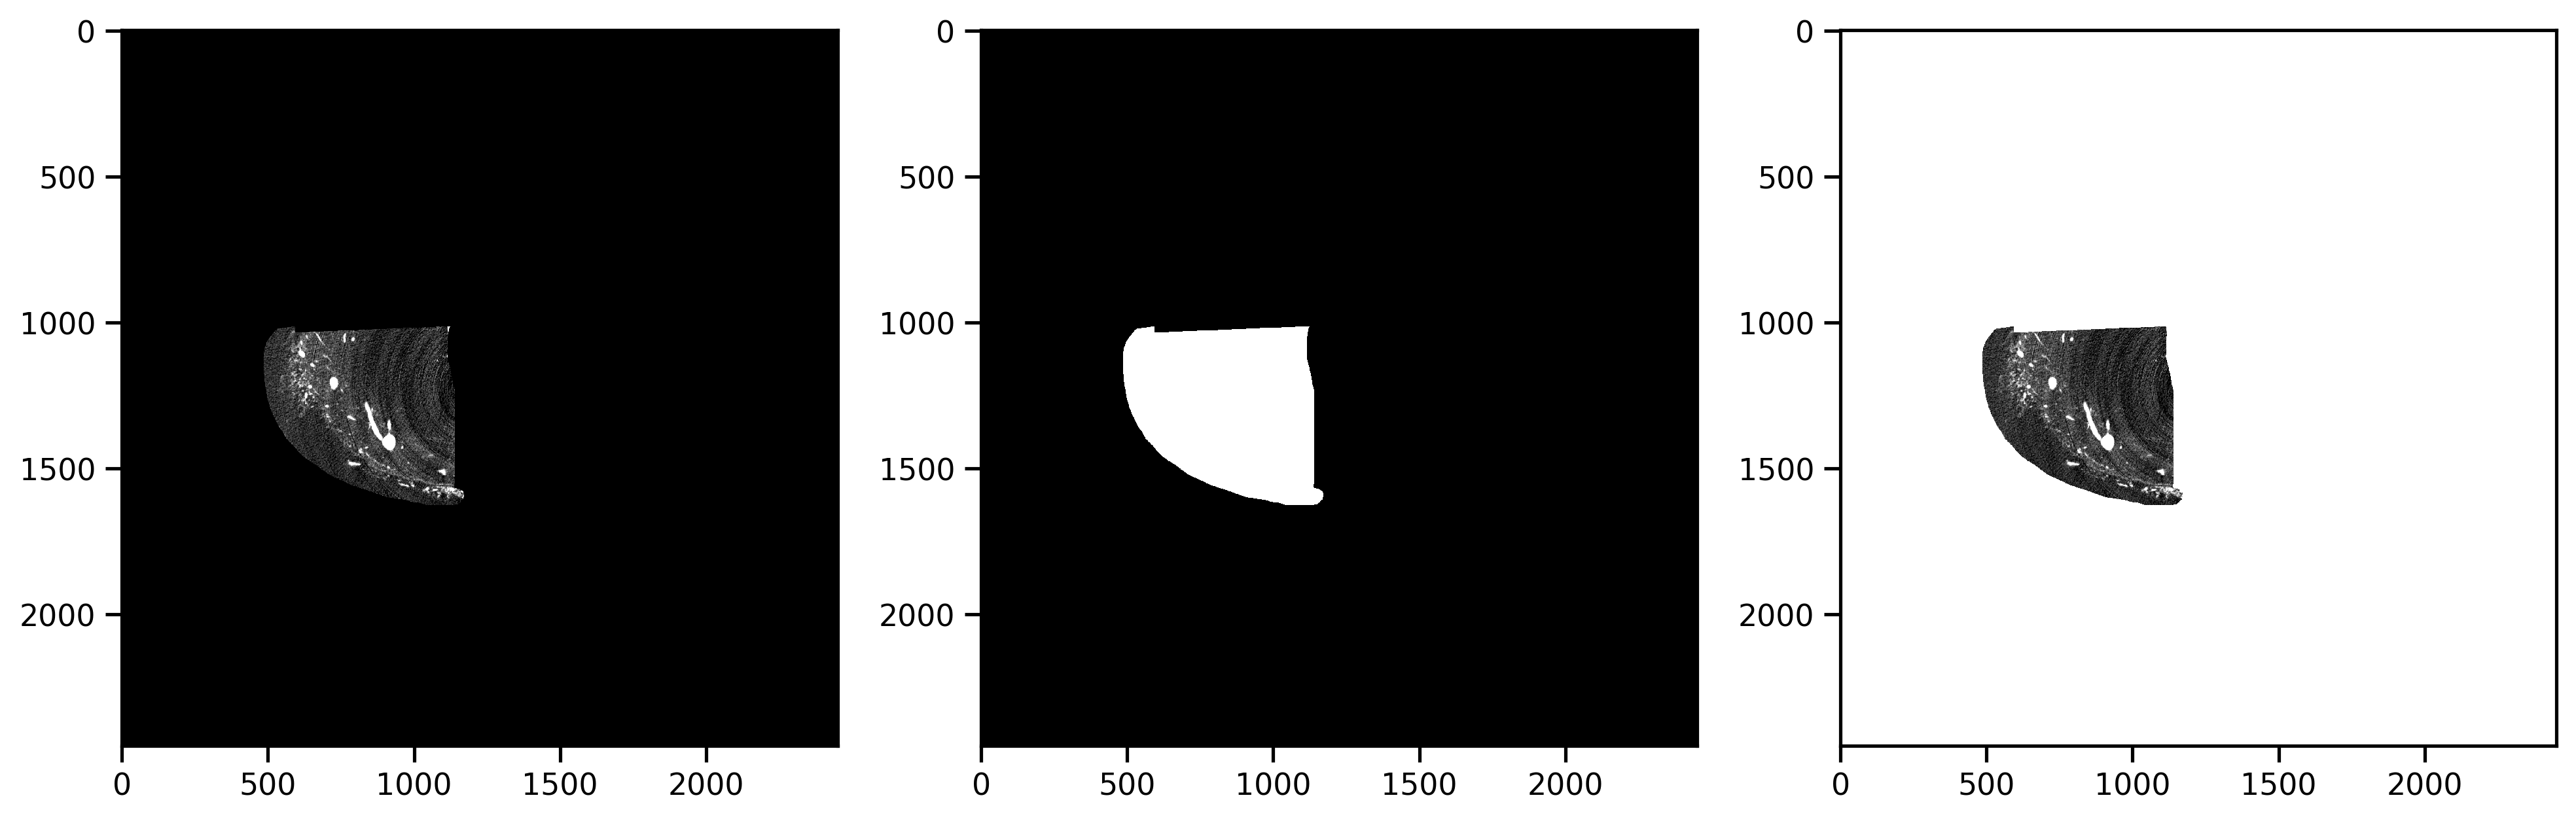

In [69]:
slice = 456
vmax = 32
plt.subplot(131)
plt.imshow(img[slice], vmax=vmax)

plt.subplot(132)
plt.imshow(binarized[slice])

plt.subplot(133)
plt.imshow(masked[slice], vmax=vmax)

plt.show()

In [70]:
# Load the VOI images a zarr arrays
Patches = [dask.array.from_zarr(file) for file in Data[Data.VOI == 'patch']['OutputNameVOI']]
Myocards = [dask.array.from_zarr(file) for file in Data[Data.VOI == 'myocard']['OutputNameVOI']]

Now that we have the patches and pizza-slices (with patch, called myocard) loaded, we can calculate the only-myocard part.

In [71]:
# Generate some dummy data, clear it and append it to dataframe for the MSP VOIs
_ = pandas.DataFrame()
_ = Data[Data['VOI'] == 'myocard'].loc[:]
_['VOI'] = _['VOI'].replace(['myocard'], ['myocard_sans_patch'])
_.loc[:, ('VOIFolder', 'VOIFile', 'VOIImages', 'OutputNameVOI', 'Number of VOI slices')] = numpy.nan
UpDatedData = pandas.concat((Data, _))
Data = UpDatedData.copy(deep=True)
Data.sort_values(['Samplename', 'Scan'], inplace=True)
Data.reset_index(drop=True, inplace=True)

In [72]:
# Save out 'myocard sans patch' raw data
# Regenerate output name for 'msp'
Data['OutputNameVOI'] = [os.path.join(os.path.dirname(f),
                                      '%s.%s.voi_%s.zarr' % (sample,
                                                             scan,
                                                             voi)) for f, sample, scan, voi in zip(Data.Folder,
                                                                                                   Data.Samplename,
                                                                                                   Data.Scan,
                                                                                                   Data.VOI)]
# https://stackoverflow.com/a/55437530/323100
for c, row in tqdm(enumerate(Data[Data['VOI'] == 'myocard_sans_patch'].iterrows()),
                   desc='Calculating MSP VOIs',
                   total=len(Data[Data['VOI'] == 'myocard_sans_patch'])):
    if not os.path.exists(row[1]['OutputNameVOI']):
        print('%2s/%s: Calculating MSP VOI and saving to %s' % (c + 1,
                                                                len(Data[Data['VOI'] == 'myocard_sans_patch']),
                                                                row[1]['OutputNameVOI'][len(Root)+1:]))
        MSP = dask.array.subtract(Myocards[c], Patches[c])
        MSP.rechunk('auto').to_zarr(row[1]['OutputNameVOI'])

Calculating MSP VOIs:   0%|          | 0/21 [00:00<?, ?it/s]

In [73]:
Patches = [dask.array.from_zarr(file) for file in Data[Data.VOI == 'patch']['OutputNameVOI']]
Myocards = [dask.array.from_zarr(file) for file in Data[Data.VOI == 'myocard']['OutputNameVOI']]
MSP = [dask.array.from_zarr(file) for file in Data[Data.VOI == 'myocard_sans_patch']['OutputNameVOI']]

In [74]:
for file in Data[Data.VOI == 'patch']['OutputNameVOI_Binary']:
    try:
        dask.array.from_zarr(file)
    except:
        print(file)

In [75]:
for file in Data[Data.VOI == 'myocard']['OutputNameVOI_Binary']:
    try:
        dask.array.from_zarr(file)
    except:
        print(file)

In [76]:
# Load the VOI images a zarr arrays
Patches_Binary = [dask.array.from_zarr(file) for file in Data[Data.VOI == 'patch']['OutputNameVOI_Binary']]
Myocards_Binary = [dask.array.from_zarr(file) for file in Data[Data.VOI == 'myocard']['OutputNameVOI_Binary']]

In [77]:
# Patches_Binary[0][333].compute()

In [78]:
# dask.array.logical_xor(Patches_Binary[0][333], Myocards_Binary[0][333]).compute()

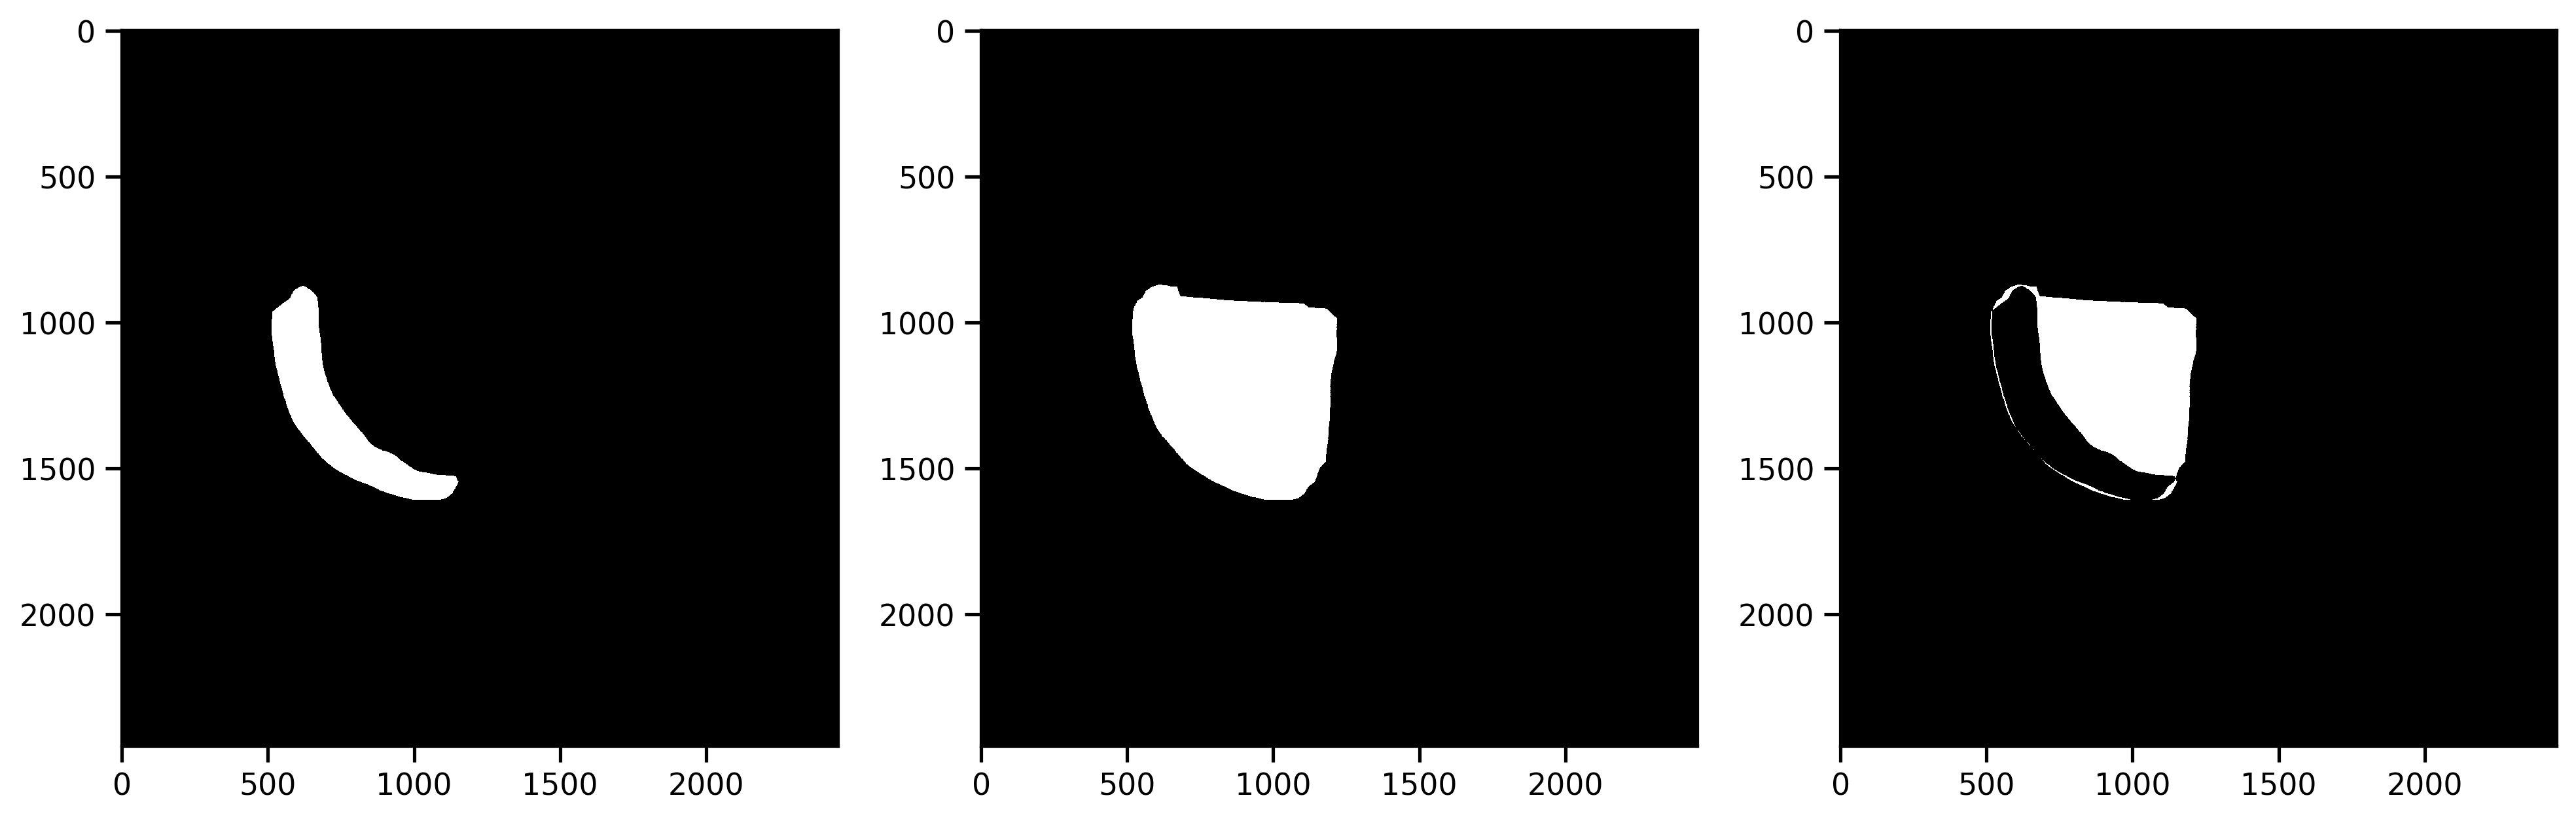

In [79]:
plt.subplot(131)
plt.imshow(Patches_Binary[whichone][333])

plt.subplot(132)
plt.imshow(Myocards_Binary[whichone][333])

plt.subplot(133)
plt.imshow(dask.array.logical_xor(Myocards_Binary[whichone][333], Patches_Binary[whichone][333]))

plt.show()

In [80]:
# Write out 'myocard sans patch' binarized data
# Regenerate output name for 'msp'
Data['OutputNameVOI_Binary'] = [os.path.join(os.path.dirname(f),
                                             '%s.%s.voi_%s.binary.zarr' % (sample,
                                                                           scan,
                                                                           voi)) for f, sample, scan, voi in zip(Data.Folder,
                                                                                                                 Data.Samplename,
                                                                                                                 Data.Scan,
                                                                                                                 Data.VOI)]
# https://stackoverflow.com/a/55437530/323100
for c, row in tqdm(enumerate(Data[Data['VOI'] == 'myocard_sans_patch'].iterrows()),
                   desc='Calculating MSP VOIs',
                   total=len(Data[Data['VOI'] == 'myocard_sans_patch'])):
    if not os.path.exists(row[1]['OutputNameVOI_Binary']):
        print('%2s/%s: Calculating MSP VOI and saving to %s' % (c + 1,
                                                                len(Data[Data['VOI'] == 'myocard_sans_patch']),
                                                                row[1]['OutputNameVOI_Binary'][len(Root)+1:]))
        MSP_Binary = dask.array.logical_xor(Myocards_Binary[c], Patches_Binary[c])
        MSP_Binary.rechunk('auto').to_zarr(row[1]['OutputNameVOI_Binary'])

Calculating MSP VOIs:   0%|          | 0/21 [00:00<?, ?it/s]

In [81]:
# Load *all* VOIs
VOIs_raw = [dask.array.from_zarr(file) for file in Data['OutputNameVOI']]
VOIs_binarized = [dask.array.from_zarr(file) for file in Data['OutputNameVOI_Binary']]

In [82]:
whichone = 16

In [83]:
print('Looking at %s/%s/%s' % (Data['Samplename'][whichone],
                               Data['Scan'][whichone],
                               Data['VOI'][whichone]))

Looking at Rat65/cu_10um.rec/patch


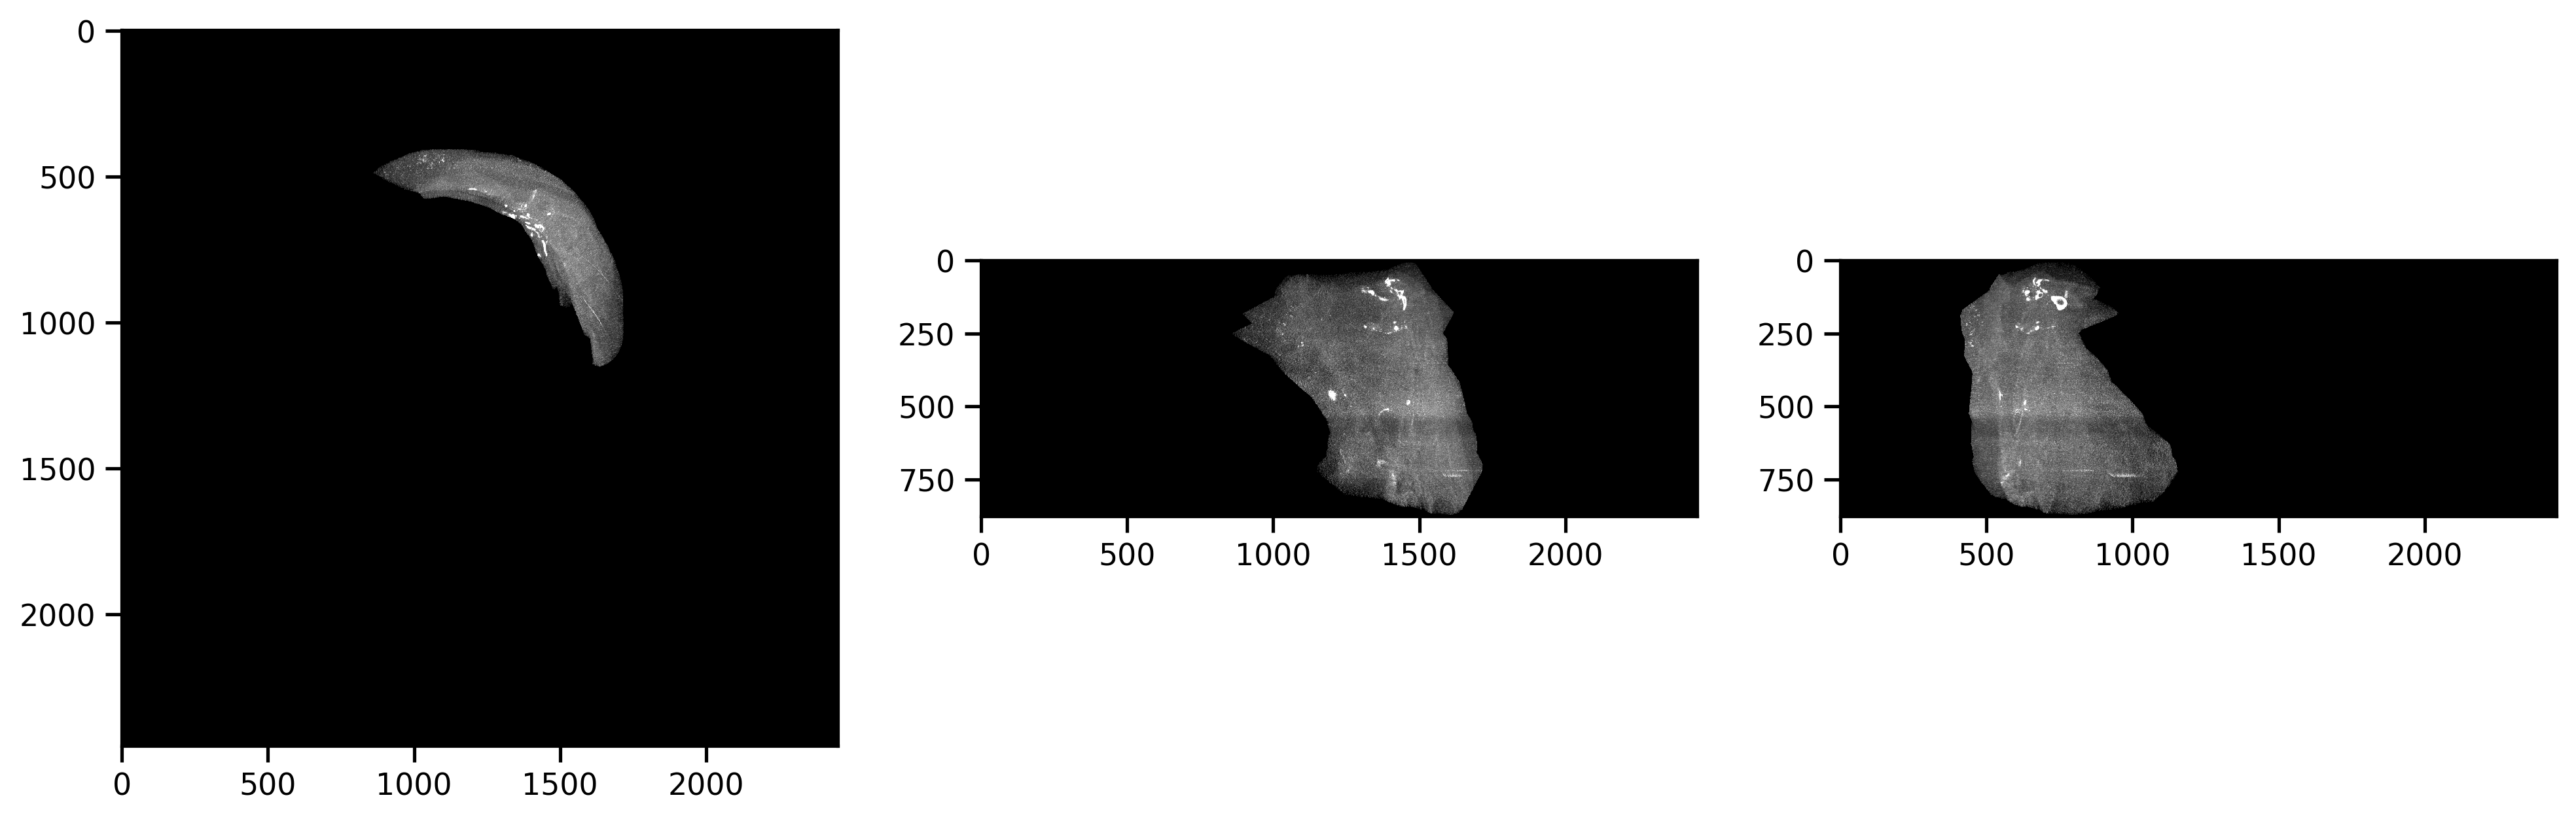

In [84]:
for c, direction in enumerate(directions):
    plt.subplot(1, 3, c+1)
    plt.imshow(VOIs_raw[whichone].max(axis=c), vmax=32)
plt.show()

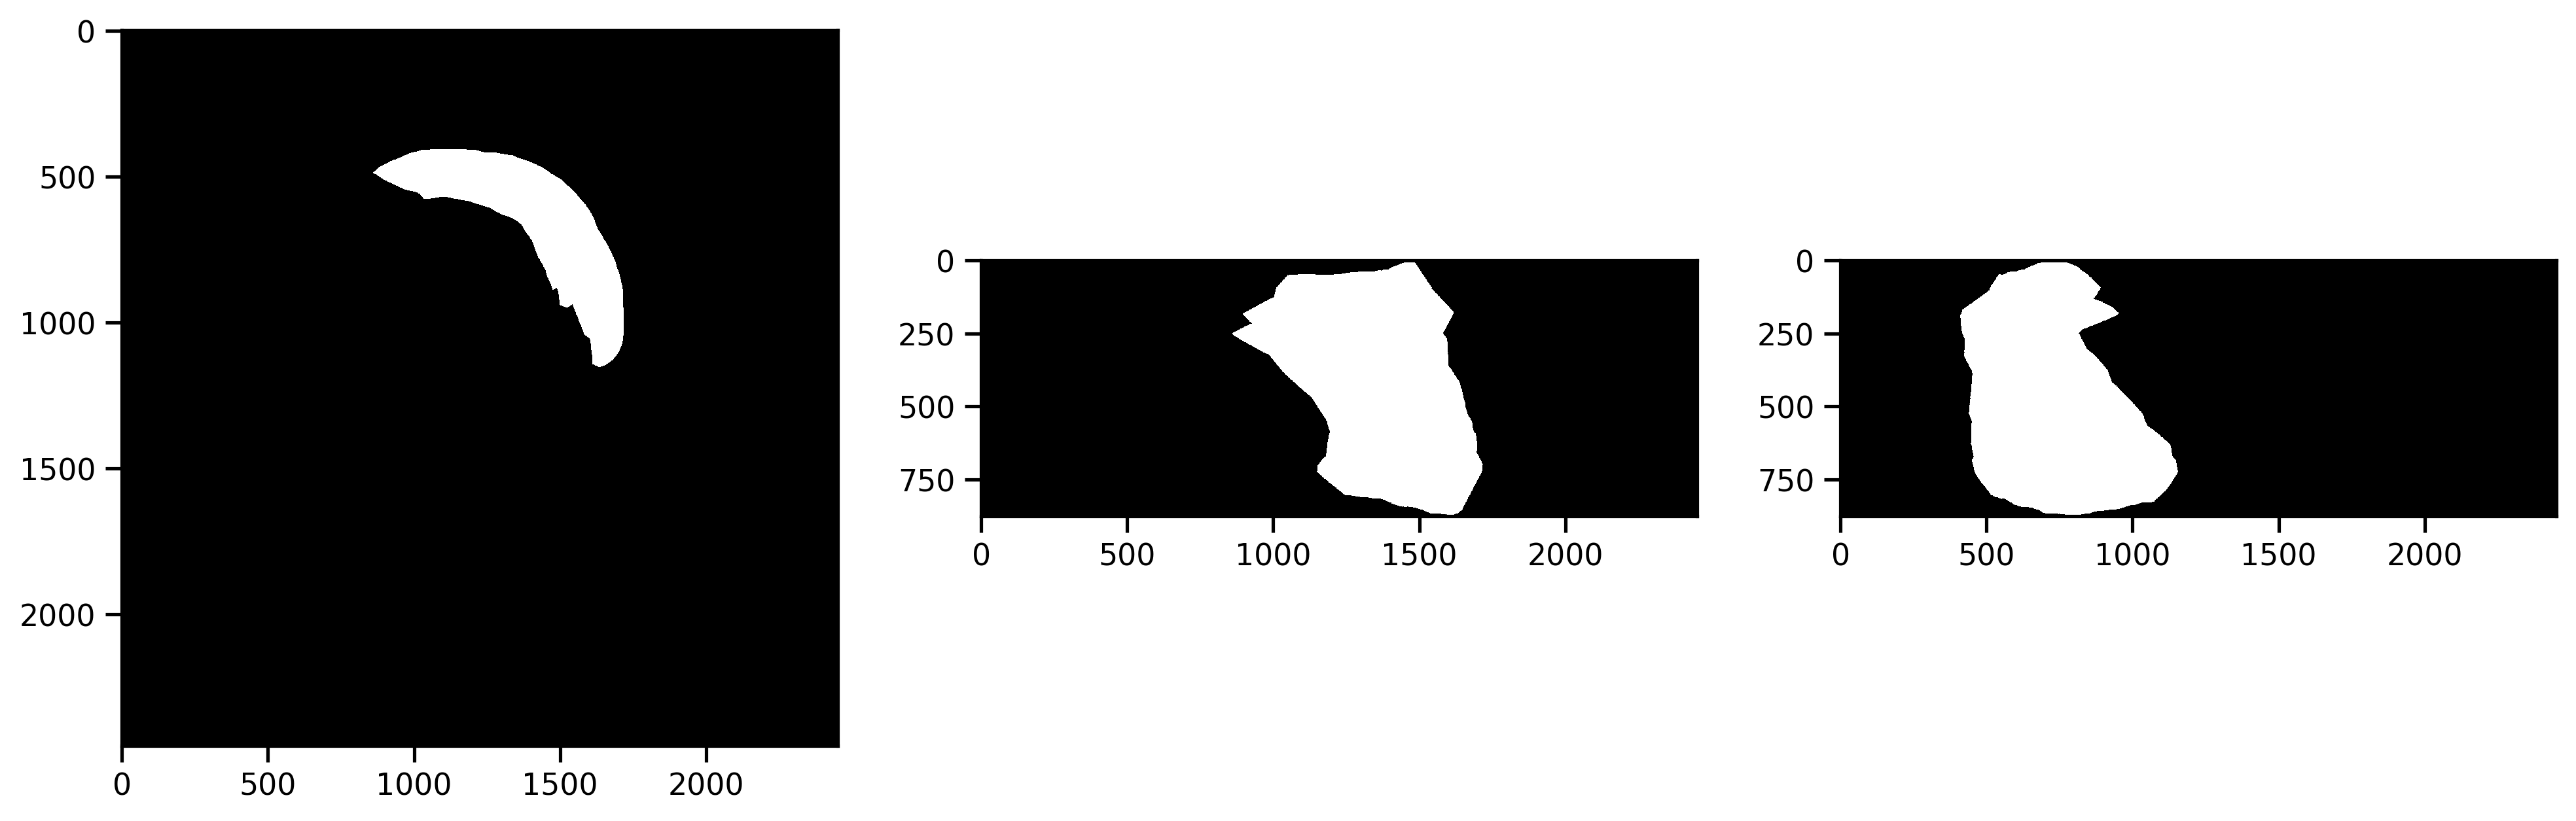

In [85]:
for c, direction in enumerate(directions):
    plt.subplot(1, 3, c+1)
    plt.imshow(VOIs_binarized[whichone].max(axis=c))
plt.show()

In [86]:
# Get us the size of the data
Data['MiddleSliceNumber'] = [v.shape[0]//2 for v in VOIs_raw]

In [87]:
# # Now load MSPs from disk
MSP_Binary = [dask.array.from_zarr(file) for file in Data[Data.VOI == 'myocard_sans_patch']['OutputNameVOI_Binary']]

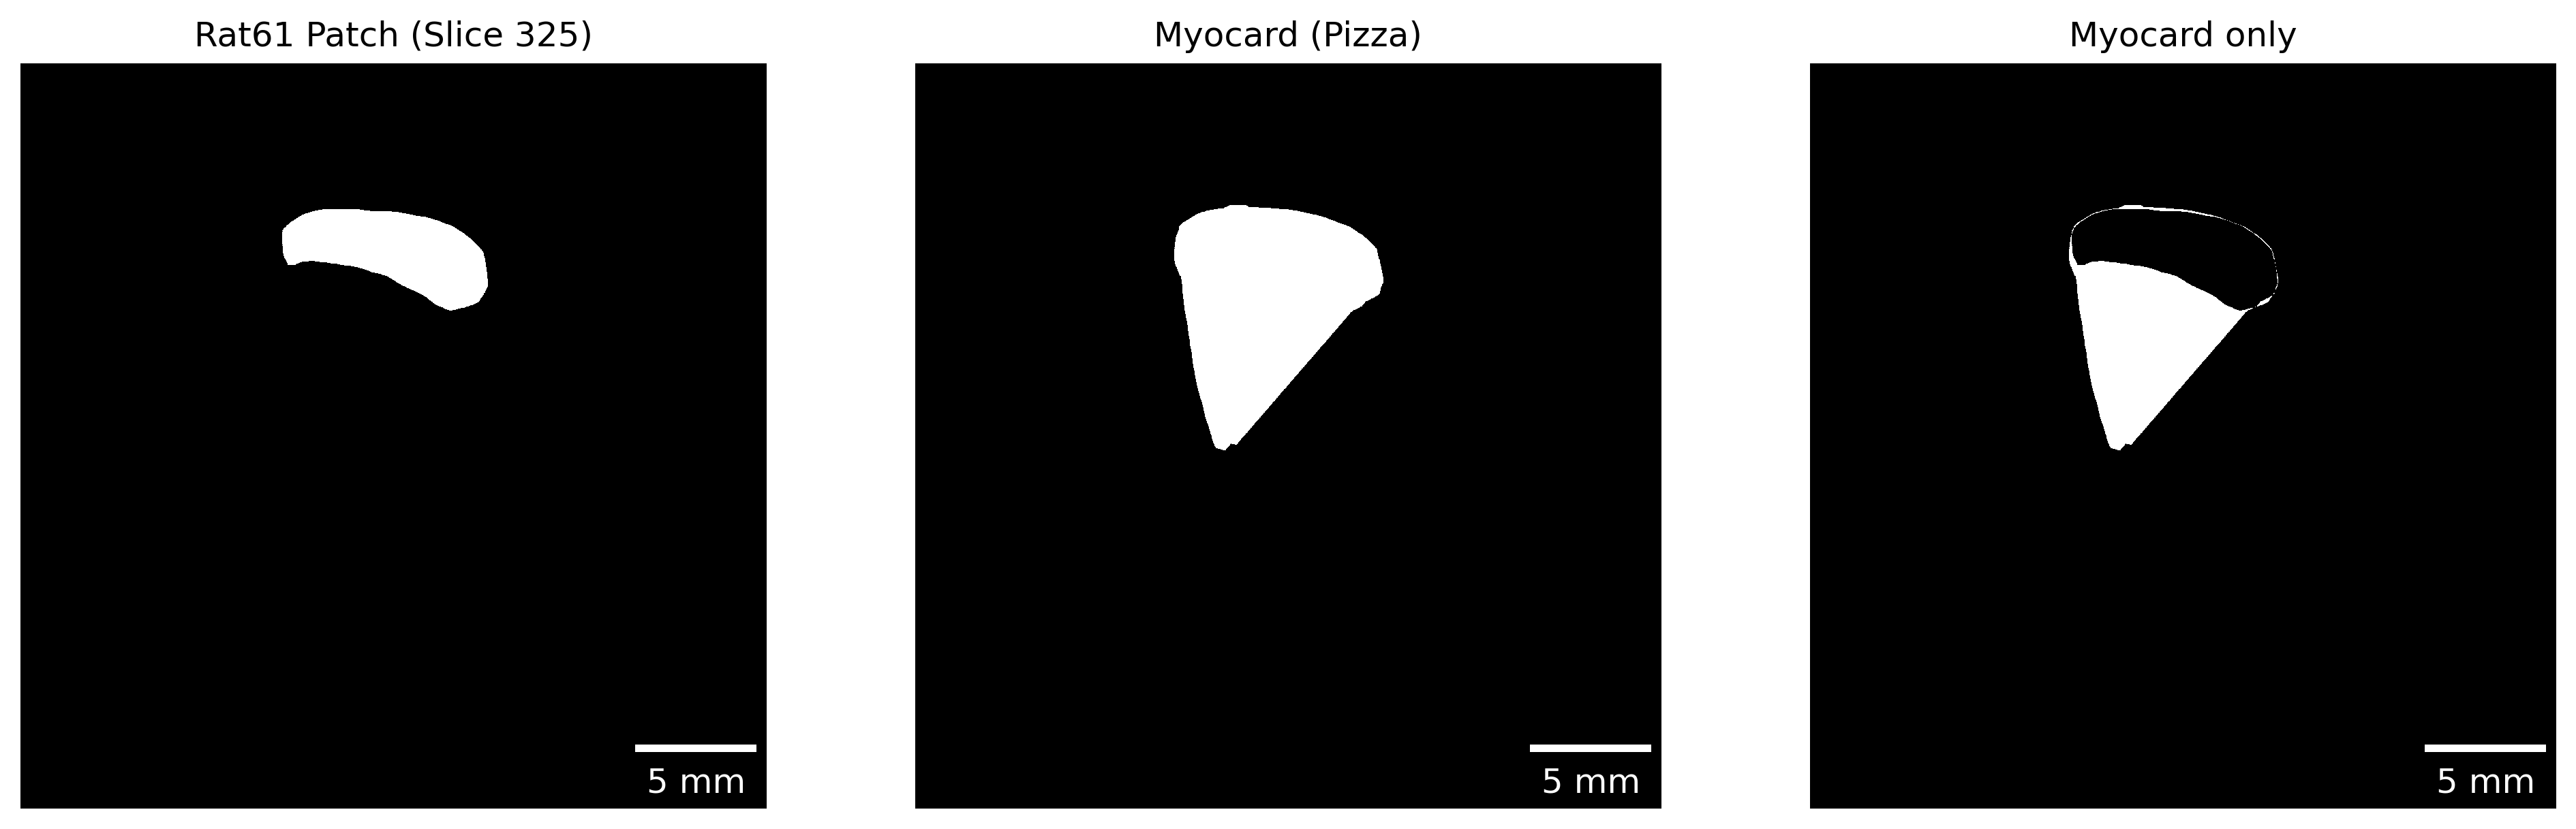

In [88]:
whichsample = 3
whichslice = 128

plt.subplot(131)
plt.imshow(Patches_Binary[whichsample][Data['MiddleSliceNumber'][whichsample]])
plt.gca().add_artist(ScaleBar(Data['Voxelsize'][0], 'um'))
plt.axis('off')
plt.title('%s Patch (Slice %s)' % (Data['Samplename'][whichsample],
                                   Data['MiddleSliceNumber'][whichsample]))
plt.subplot(132)
plt.imshow(Myocards_Binary[whichsample][Data['MiddleSliceNumber'][whichsample]])
plt.title('Myocard (Pizza)')
plt.gca().add_artist(ScaleBar(Data['Voxelsize'][0], 'um'))
plt.axis('off')
plt.subplot(133)
plt.imshow(MSP_Binary[whichsample][Data['MiddleSliceNumber'][whichsample]])
plt.title('Myocard only')
plt.gca().add_artist(ScaleBar(Data['Voxelsize'][0], 'um'))
plt.axis('off')
plt.savefig(os.path.join(OutputDir, 'Binarized.png'))
plt.show()

In [89]:
# Get us the VOI volumes
# If we 'sum' the binarized VOIs, we get the number of True voxels, e.g. the extent of the drawn VOI
Data['VOIVolume'] = [dask.array.sum(v).compute() for v in VOIs_binarized]

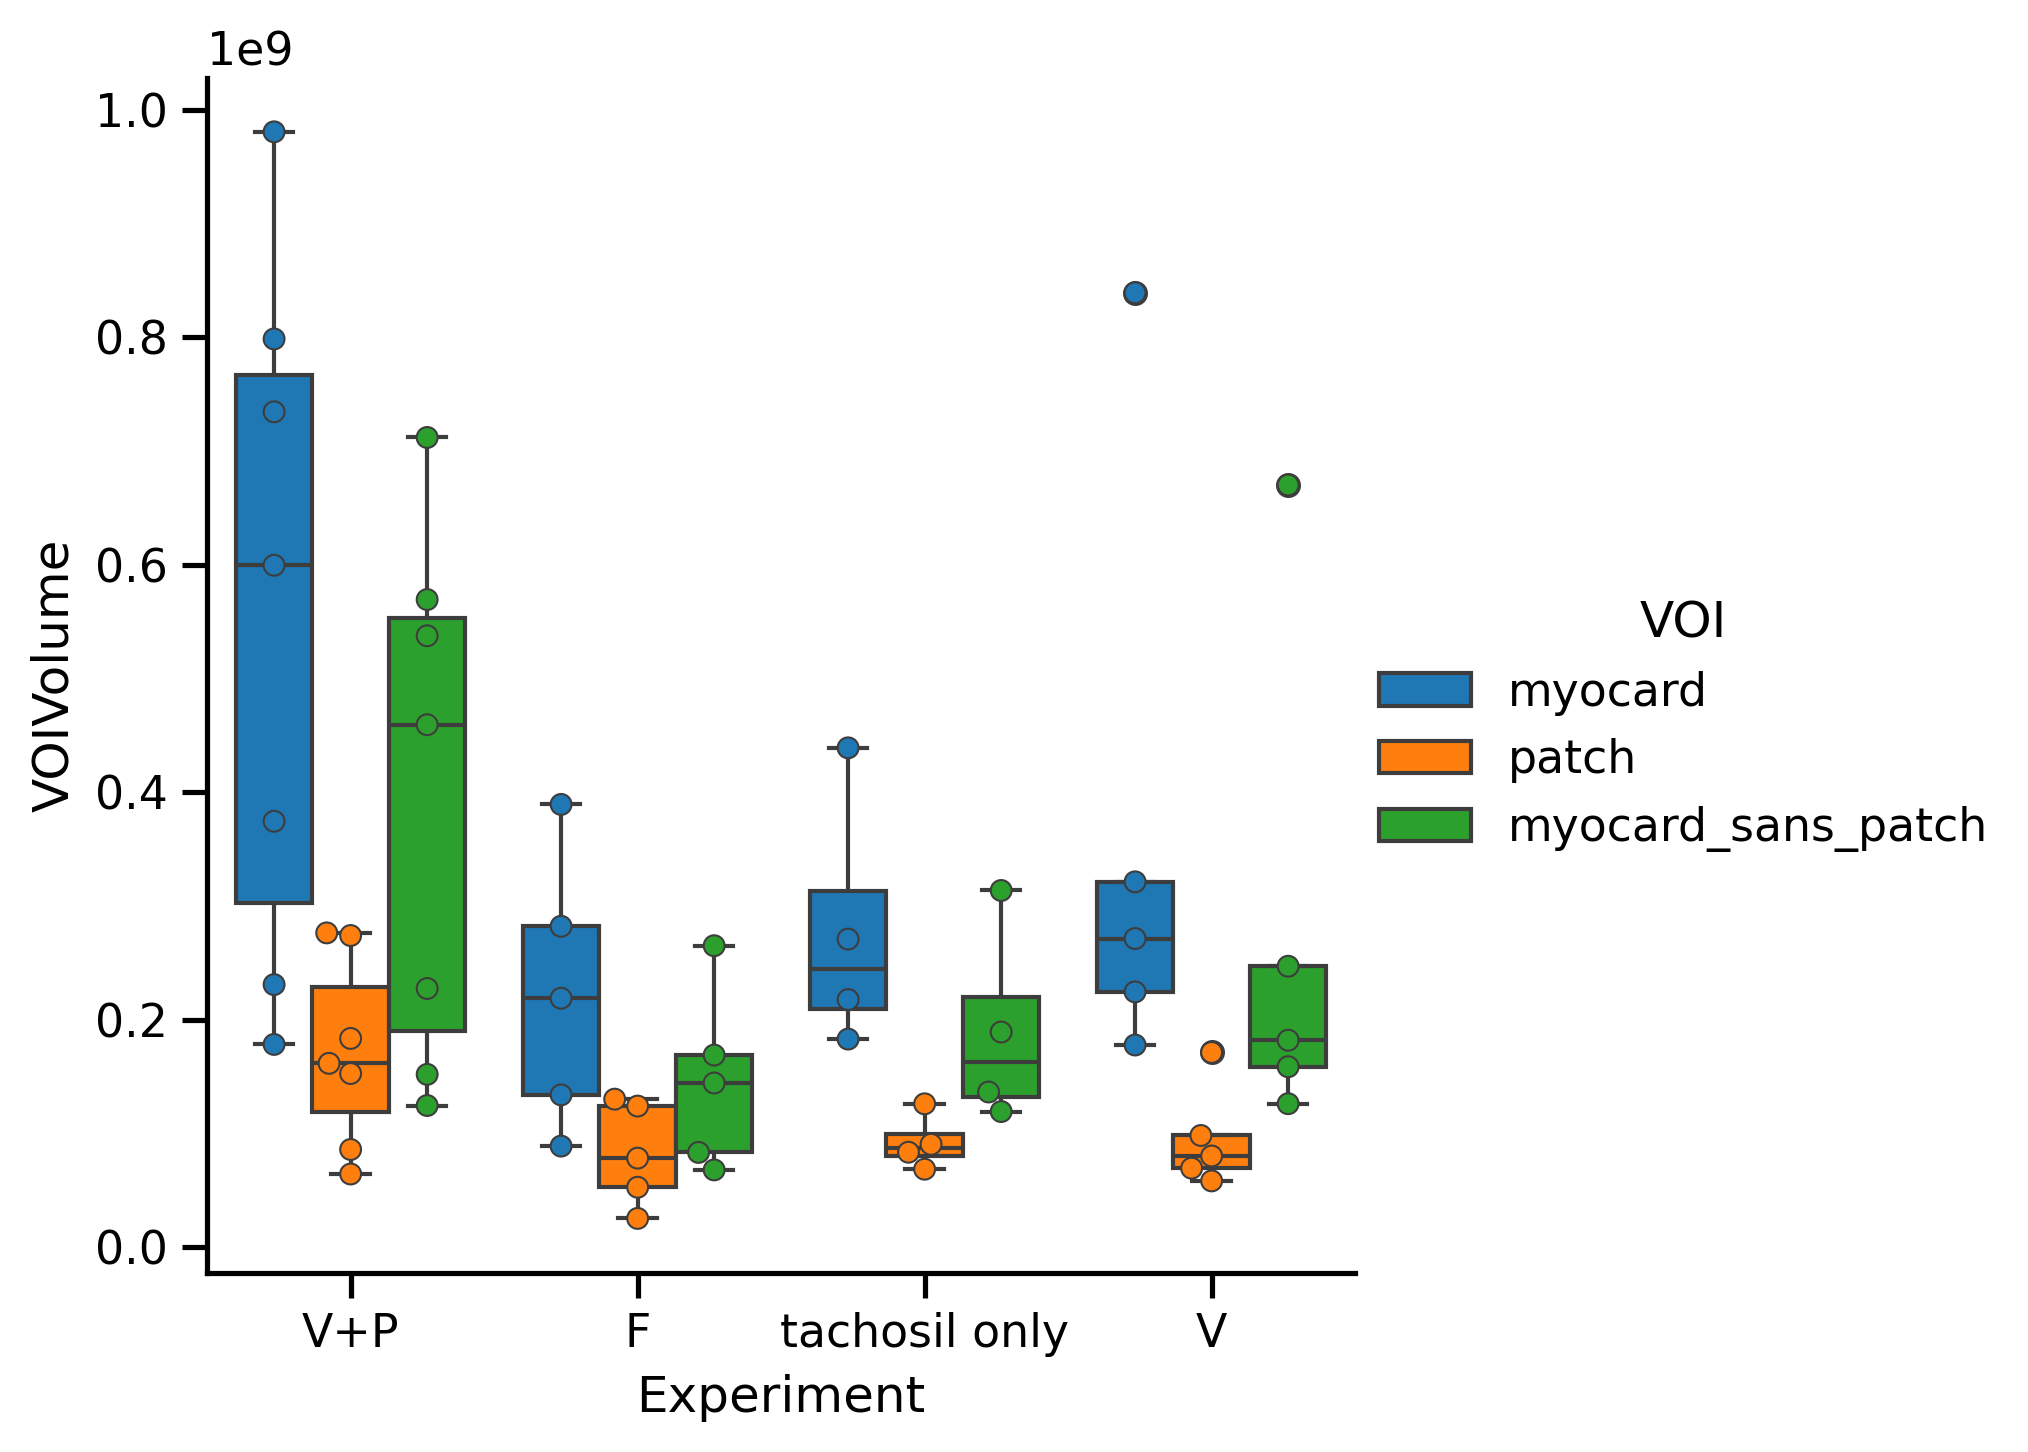

In [90]:
seaborn.catplot(data=Data, x='Experiment', y='VOIVolume', hue='VOI', kind='box', saturation=1)
seaborn.swarmplot(data=Data, x='Experiment', y='VOIVolume', hue='VOI', s=5, dodge=True, linewidth=0.5, legend=None)
plt.savefig(os.path.join(OutputDir, 'VOIVolumes.png'))
plt.show()

In [91]:
OutputDir

'Output/0a56f5e'

In [92]:
# dask.array.sum(VOIs_binarized[0][333]).compute()

In [93]:
# VOIs_raw[0]

In [94]:
# VOIs_binarized[0]

In [95]:
# Test if VOIs are the same size
for c, vois in enumerate(zip(VOIs_raw, VOIs_binarized)):
    raw = vois[0]
    binarized = vois[1]
    if raw.shape != binarized.shape:
        print('raw and binarized VOI of %s are not of equal size' % Data['Samplename'][c])
        print('Raw: %s' % str(raw.shape))
        print('Binarized: %s' % str(binarized.shape))
        print('It is probably best to delete all .zarr files in the directory and re-run the notebook')

In [96]:
# Mask the raw VOI data with their extent, so we can use `nanmean` afterwards
# We mask with the inversion of the binary, so everything that is False is masked in the output
VOIs_masked = [dask.array.ma.masked_array(data=raw.astype('uint32'),
                                          mask=dask.array.invert(binarized))
               for raw, binarized in zip(VOIs_raw, VOIs_binarized)]
# If we save the masked VOIs out, we loose the masking!

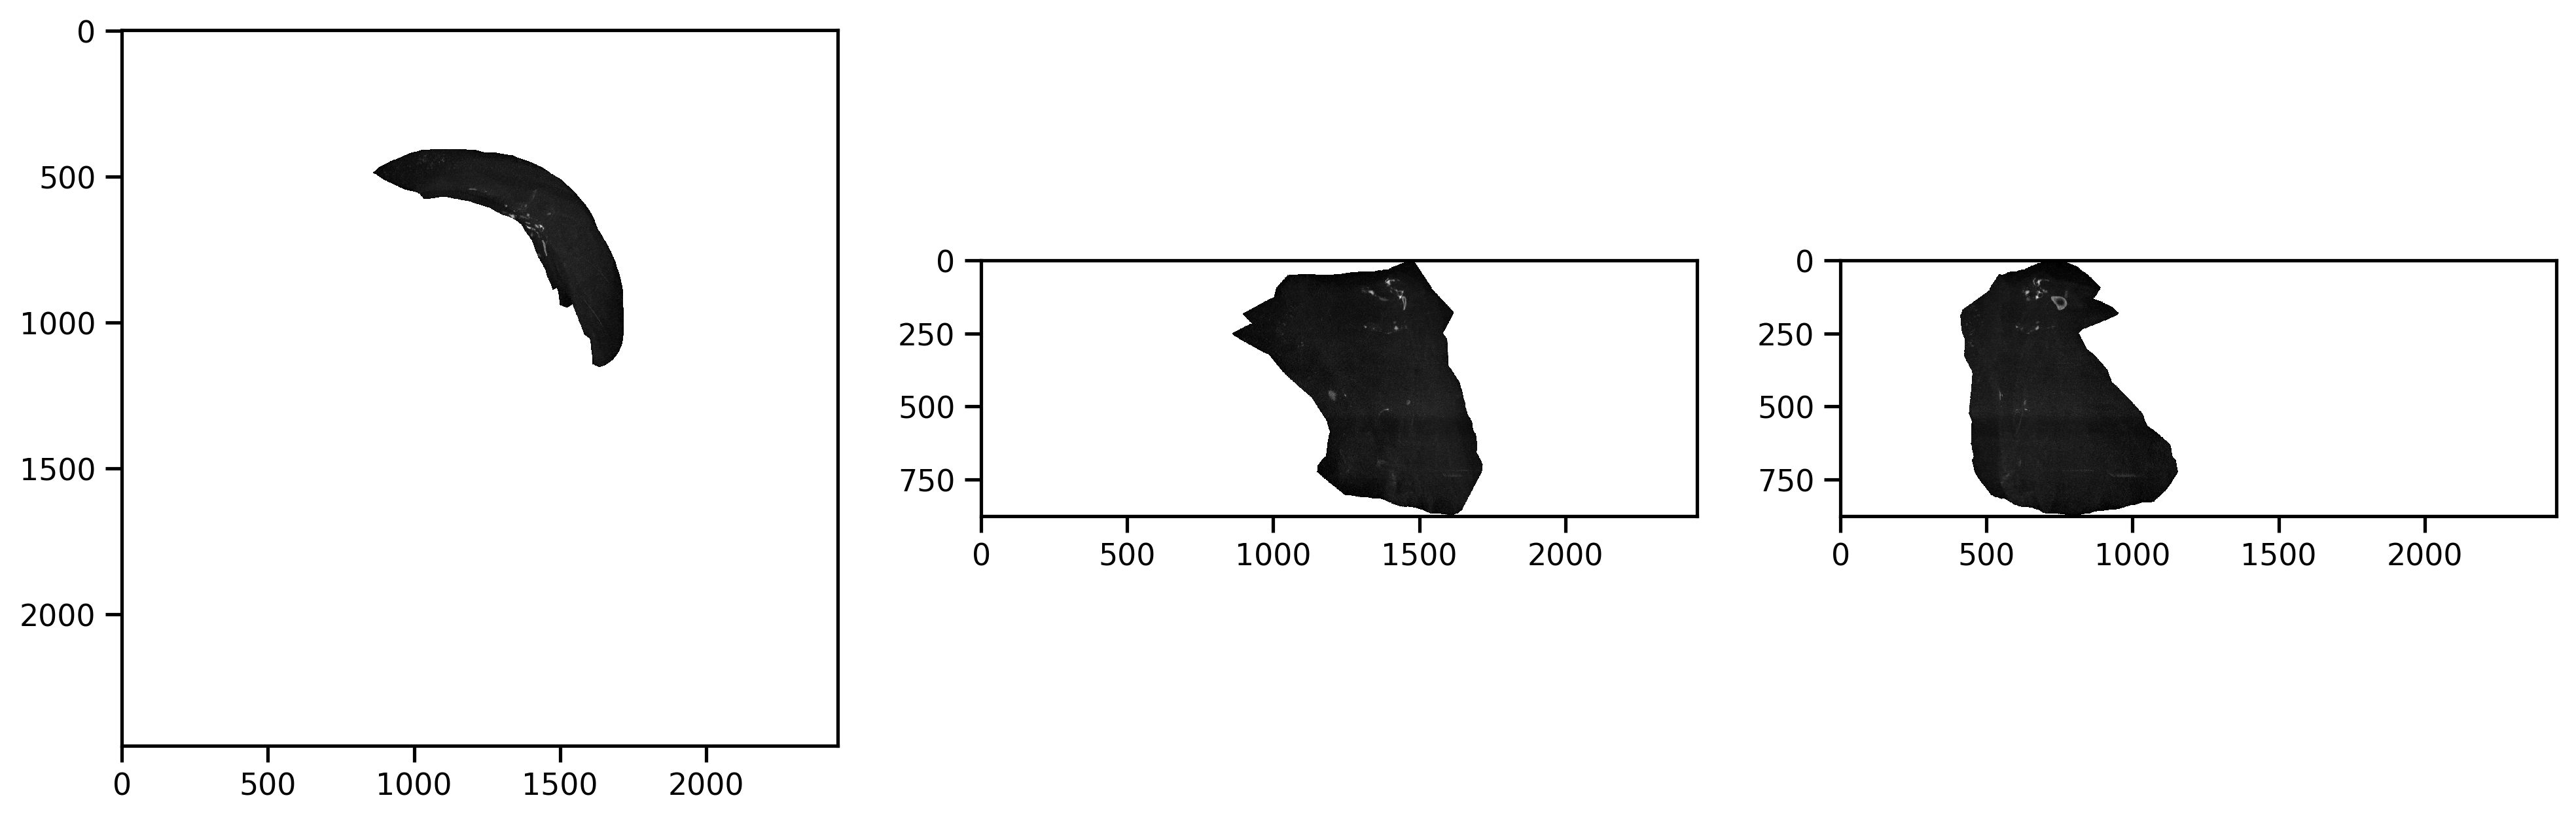

In [97]:
for c, direction in enumerate(directions):
    plt.subplot(1, 3, c+1)
    plt.imshow(VOIs_masked[whichone].max(axis=c))
plt.show()

In [98]:
# plt.imshow(VOIs_masked[13][111].compute())

In [99]:
# Save out all masked VOIs
# They loose the masking, so it's not a good thing to do...
Data['OutputNameVOI_Masked'] = [os.path.join(os.path.dirname(f),
                                             '%s.%s.voi_%s.masked.zarr' % (sample,
                                                                           scan,
                                                                           voi)) for f, sample, scan, voi in zip(Data.Folder,
                                                                                                                 Data.Samplename,
                                                                                                                 Data.Scan,
                                                                                                                 Data.VOI)]
# https://stackoverflow.com/a/55437530/323100
for c, row in tqdm(enumerate(Data.iterrows()),
                   desc='Writing out masked VOI',
                   total=len(Data)):
    if not os.path.exists(row[1]['OutputNameVOI_Masked']):
        print('%2s/%s: Saving to %s' % (c + 1,
                                        len(Data),
                                        row[1]['OutputNameVOI_Masked'][len(Root)+1:]))
        VOIs_masked[c].rechunk('auto').to_zarr(row[1]['OutputNameVOI_Masked'])

Writing out masked VOI:   0%|          | 0/63 [00:00<?, ?it/s]

In [100]:
# # Load masked VOIs back in
# VOIs_masked = [dask.array.from_zarr(file) for file in Data['OutputNameVOI_Masked']]

In [101]:
# for i in Data:
#     print(i)

In [102]:
# whichsample = 1
# whichslice = 256

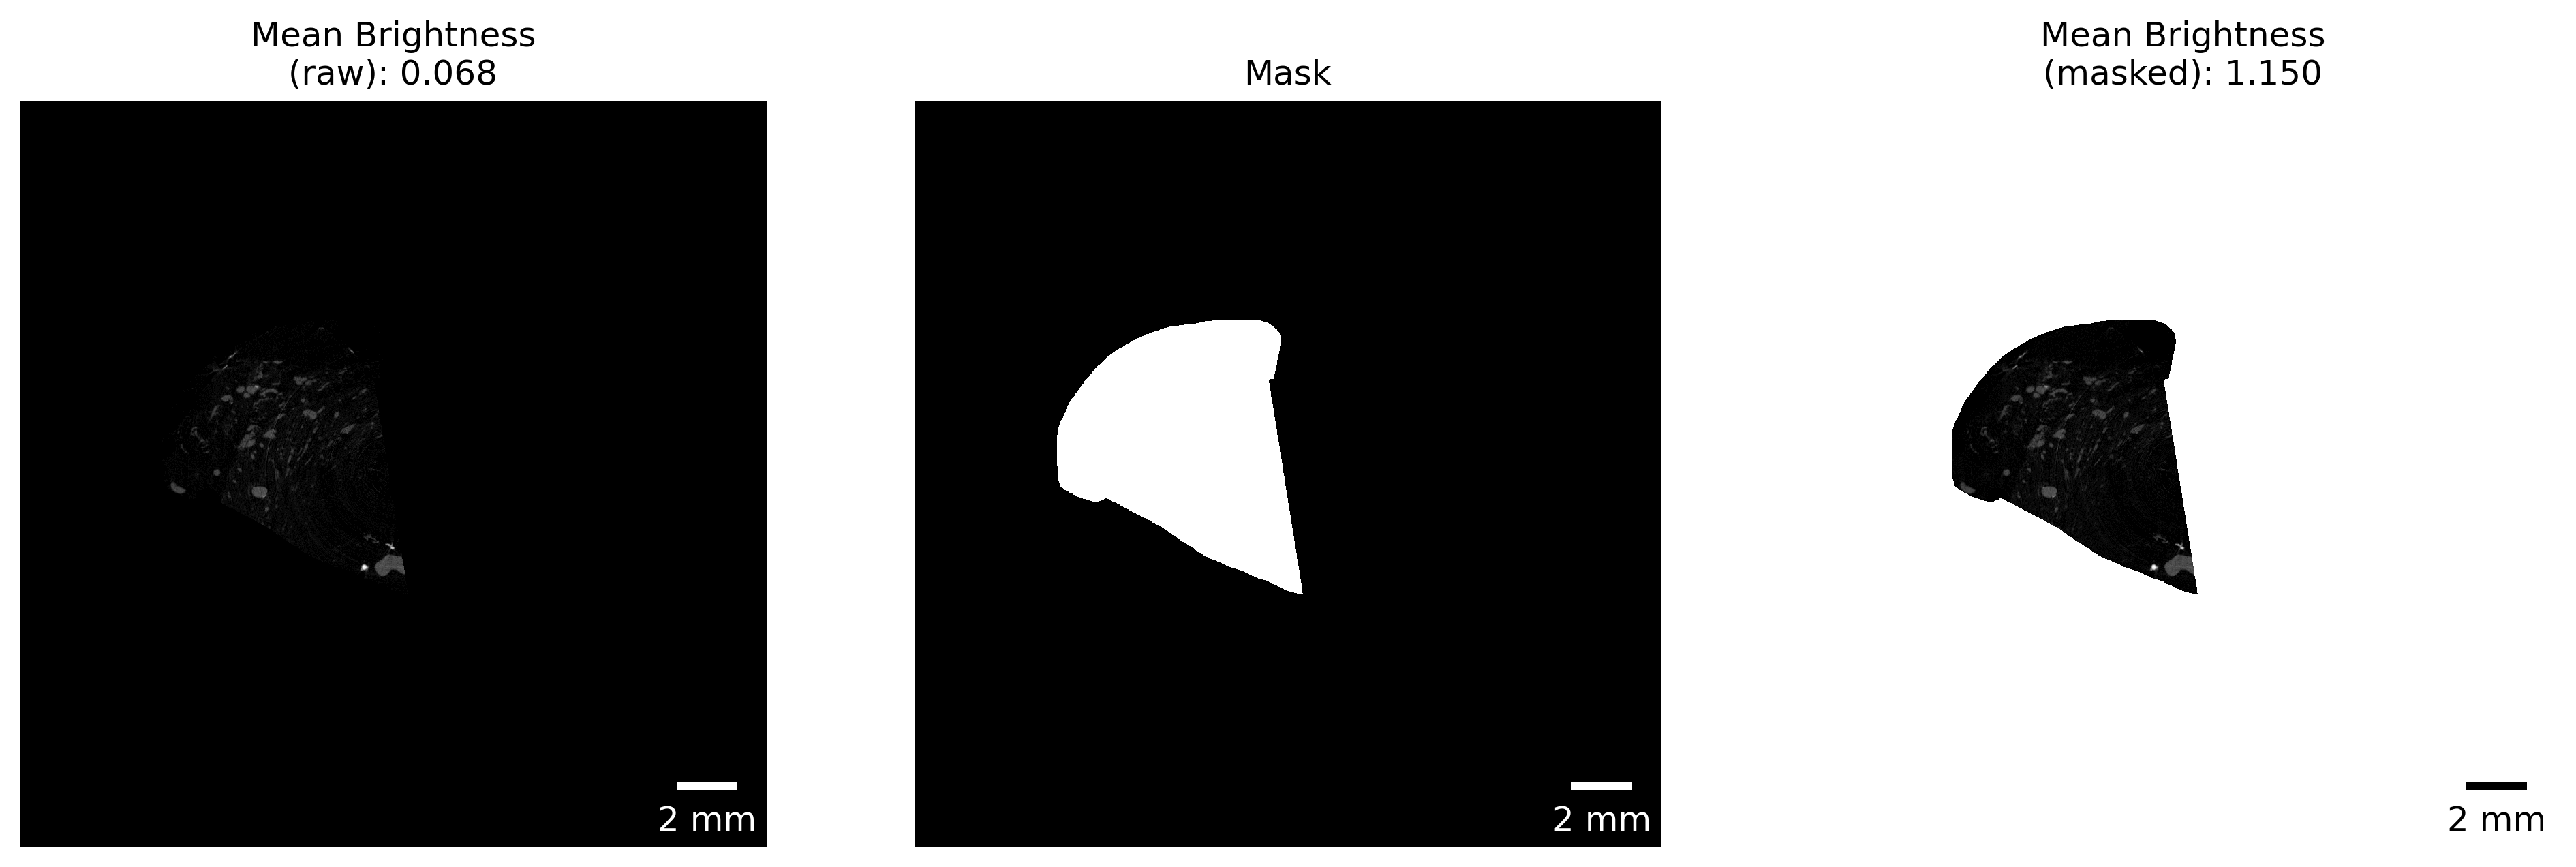

In [103]:
# Show what we did for one sample
plt.subplot(131)
plt.imshow(VOIs_raw[whichsample][Data['MiddleSliceNumber'][whichsample]])
plt.title('Mean Brightness\n(raw): %0.3f' % dask.array.nanmean(VOIs_raw[whichsample]).compute())
plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichsample], 'um'))
plt.axis('off')
plt.subplot(132)
plt.imshow(VOIs_binarized[whichsample][Data['MiddleSliceNumber'][whichsample]])
plt.title('Mask')
plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichsample], 'um'))
plt.axis('off')
plt.subplot(133)
plt.imshow(VOIs_masked[whichsample][Data['MiddleSliceNumber'][whichsample]])
plt.title('Mean Brightness\n(masked): %0.3f' % dask.array.nanmean(VOIs_masked[whichsample]).compute())
plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichsample], 'um', color='black'))
plt.axis('off')
plt.savefig(os.path.join(OutputDir, 'Masking.png'))
plt.show()

In [104]:
# Get us the VOI volumes
# If we 'sum' the binarized VOIs, we get the number of True voxels, e.g. the extent of the drawn VOI
Data['VOIBrightness'] = [dask.array.nanmean(vm).compute() for vm in VOIs_masked]

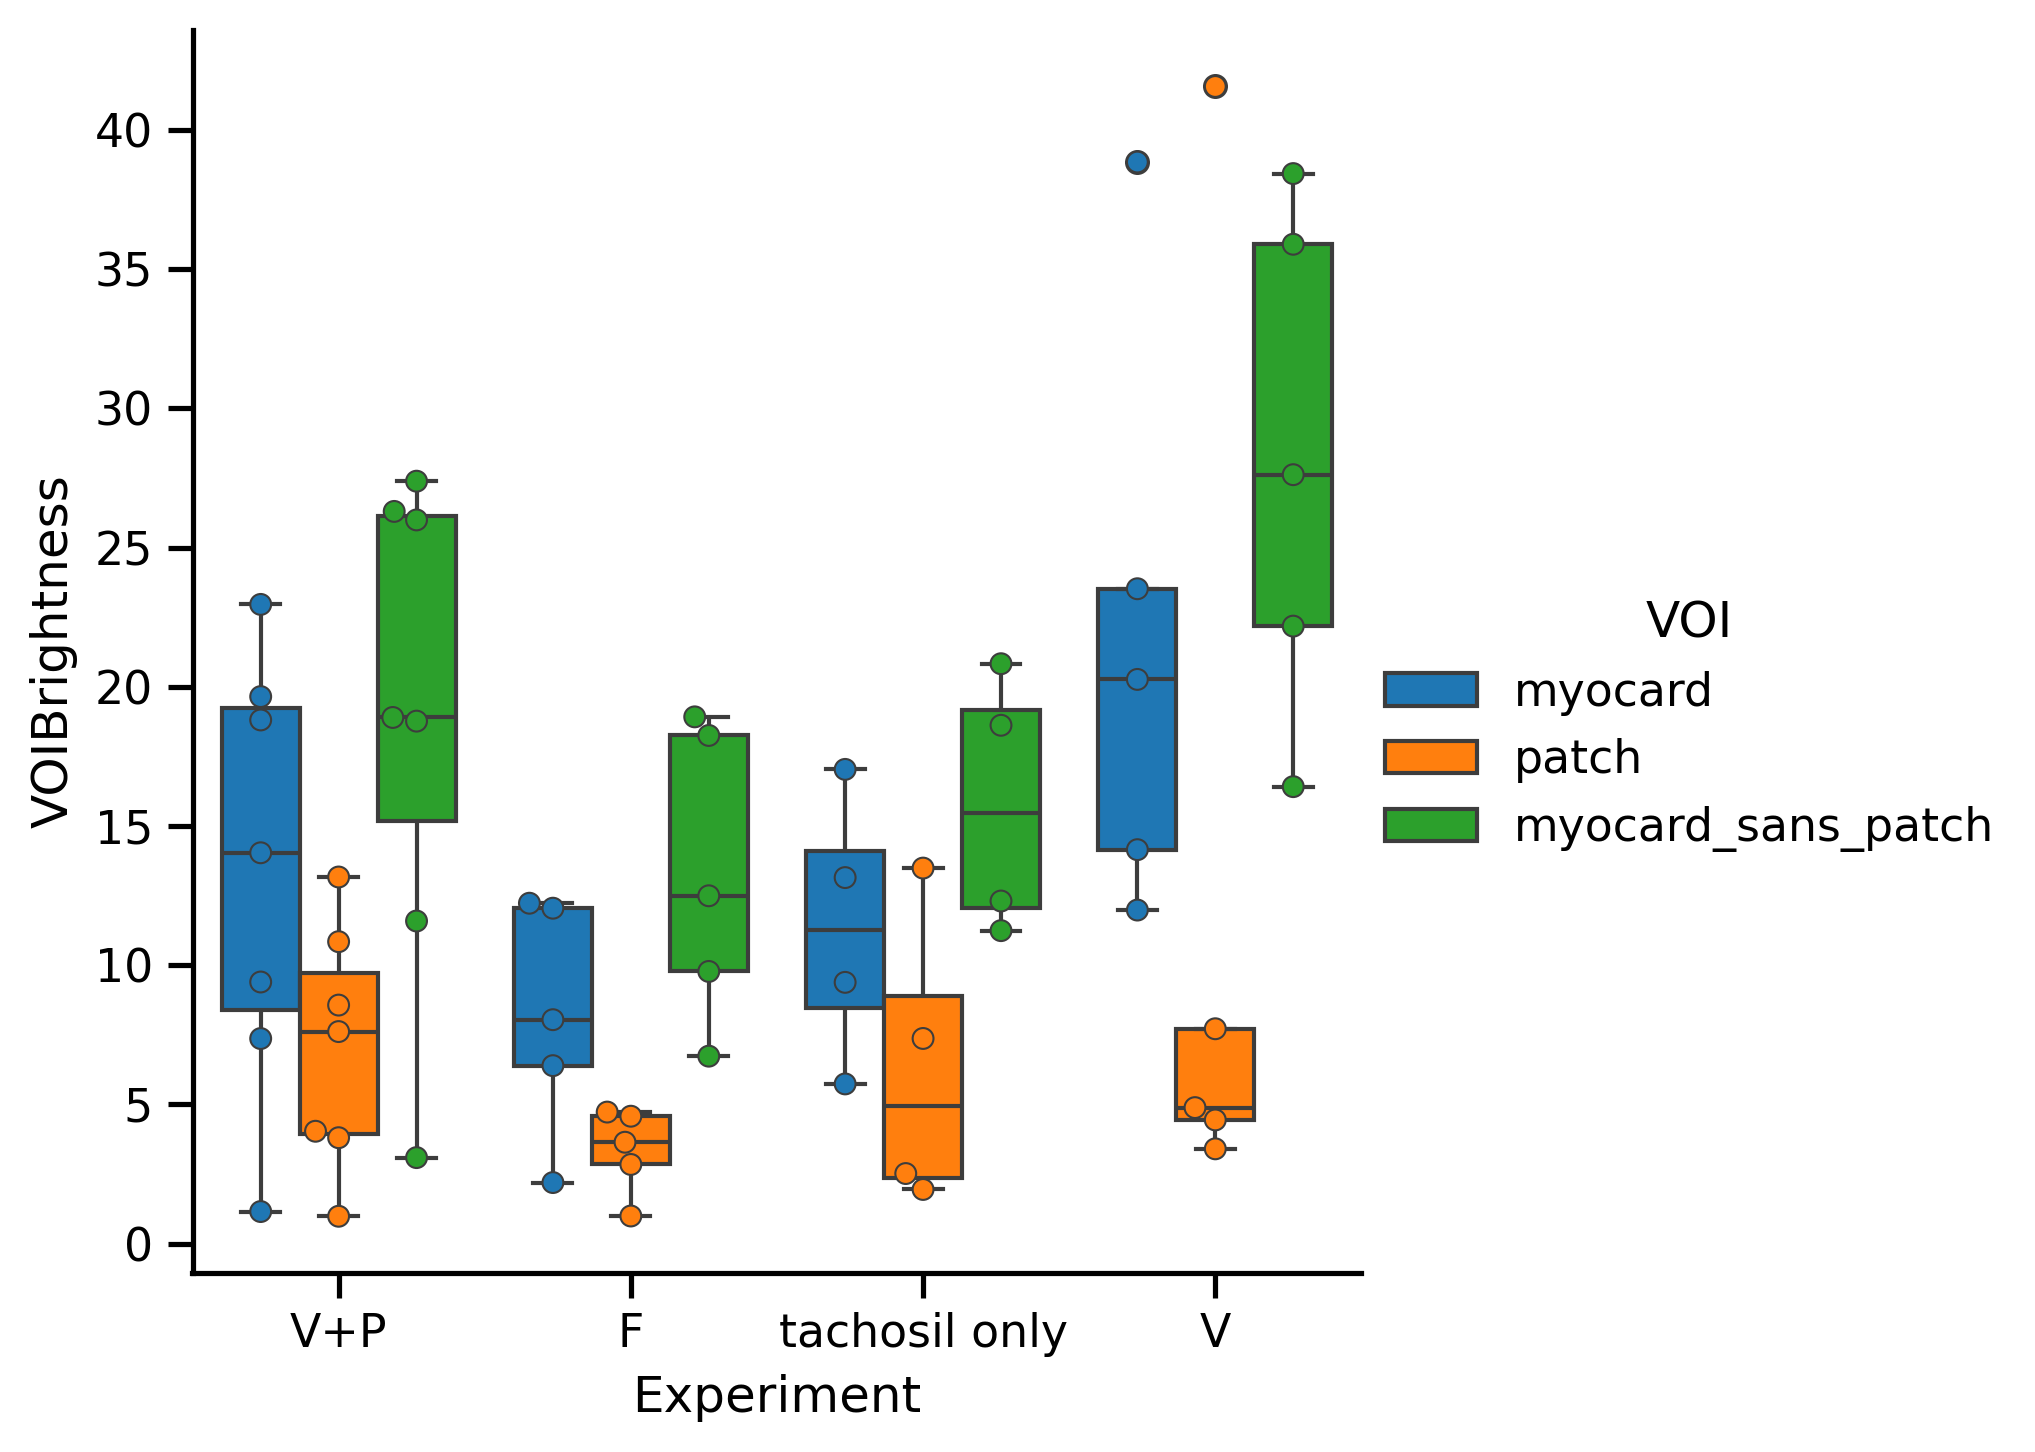

In [105]:
seaborn.catplot(data=Data, x='Experiment', y='VOIBrightness', hue='VOI', kind='box', saturation=1)
seaborn.swarmplot(data=Data, x='Experiment', y='VOIBrightness', hue='VOI', s=5, dodge=True, linewidth=0.5, legend=None)
plt.savefig(os.path.join(OutputDir, 'VOIBrightness.Experiment.png'))
plt.show()

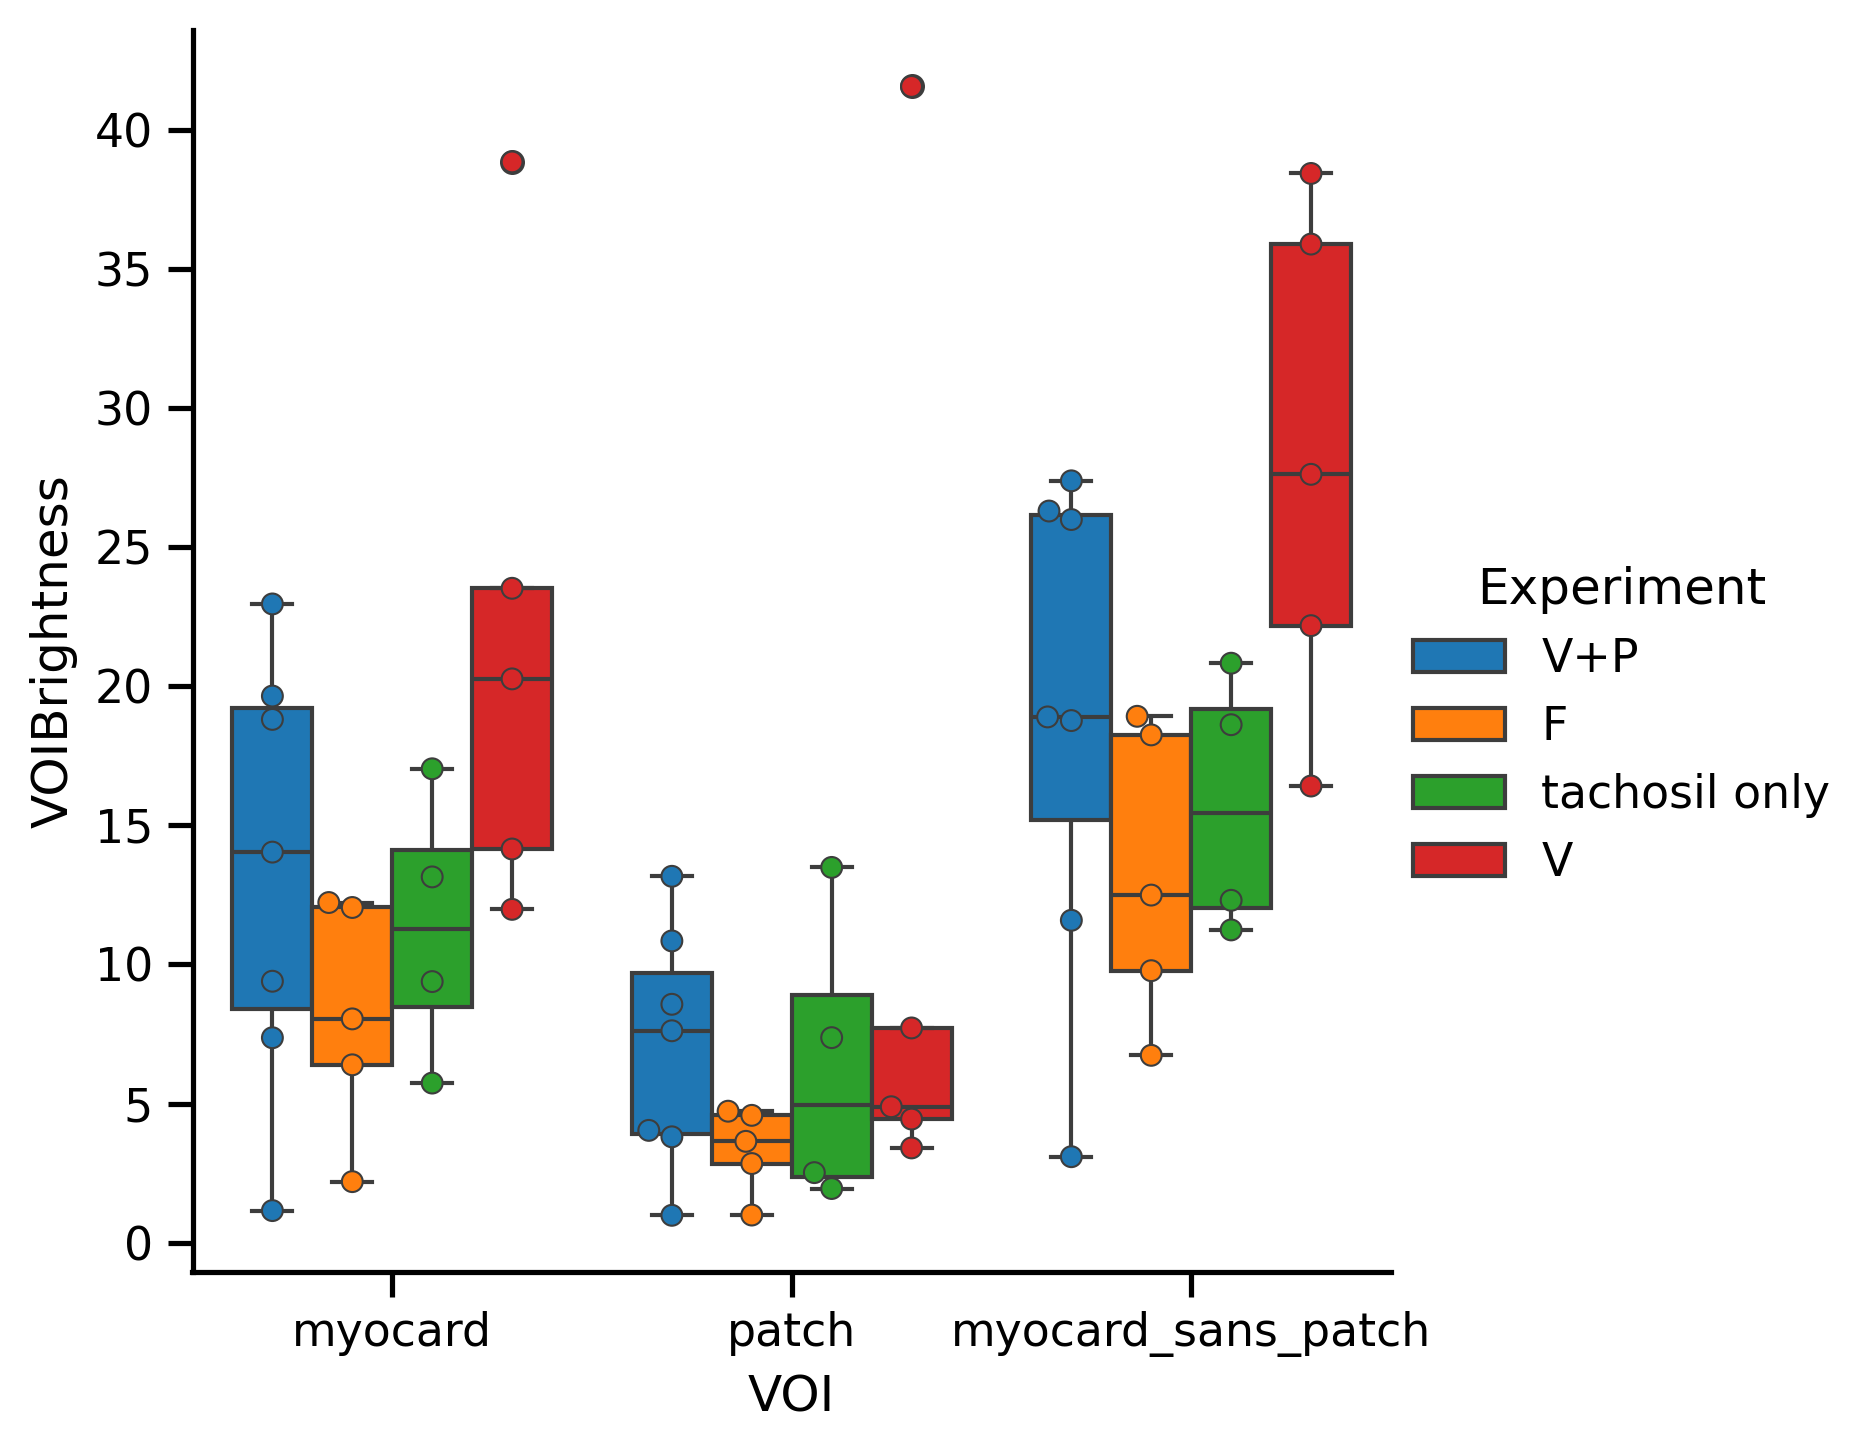

In [106]:
seaborn.catplot(data=Data, x='VOI', y='VOIBrightness', hue='Experiment', kind='box', saturation=1)
seaborn.swarmplot(data=Data, x='VOI', y='VOIBrightness', hue='Experiment', s=5, dodge=True, linewidth=0.5, legend=None)
plt.savefig(os.path.join(OutputDir, 'VOIBrightness.VOI.png'))
plt.show()

In [107]:
# plt.imshow(Patches_Binary[c][Data['MiddleSliceNumber'][whichsample]])

In [108]:
for i in Data:
    print(i)

LogFile
Folder
Samplename
Scan
Animal
Experiment
Timepoint
Gender
VOI
VOIFolder
VOIFile
VOIImages
Number of VOI slices
Scanner
Voxelsize
ColorTimepoint
ColorScanner
ColorExperiment
OutputNameVOI
OutputNameVOI_Binary
MiddleSliceNumber
VOIVolume
OutputNameVOI_Masked
VOIBrightness


In [109]:
Data[(Data.Samplename == 'Rat82')]

LogFile  \
42  /media/habi/Fast_SSD/Hearts Melly/Rat82/2214_7...   
43  /media/habi/Fast_SSD/Hearts Melly/Rat82/2214_7...   
44  /media/habi/Fast_SSD/Hearts Melly/Rat82/2214_7...   
45  /media/habi/Fast_SSD/Hearts Melly/Rat82/cu_10u...   
46  /media/habi/Fast_SSD/Hearts Melly/Rat82/cu_10u...   
47  /media/habi/Fast_SSD/Hearts Melly/Rat82/cu_10u...   

                                               Folder Samplename  \
42  /media/habi/Fast_SSD/Hearts Melly/Rat82/2214_7...      Rat82   
43  /media/habi/Fast_SSD/Hearts Melly/Rat82/2214_7...      Rat82   
44  /media/habi/Fast_SSD/Hearts Melly/Rat82/2214_7...      Rat82   
45  /media/habi/Fast_SSD/Hearts Melly/Rat82/cu_10u...      Rat82   
46  /media/habi/Fast_SSD/Hearts Melly/Rat82/cu_10u...      Rat82   
47  /media/habi/Fast_SSD/Hearts Melly/Rat82/cu_10u...      Rat82   

                    Scan  Animal Experiment  Timepoint Gender  \
42  2214_7.5um_Al1mm.rec      82          V         28      M   
43  2214_7.5um_Al1mm.rec      82          V         28      M   
44  2214_7.5um_Al1mm.rec      82          V         28      M   
45           cu_10um.rec      82          V         28      M   
46           cu_10um.rec      82          V         28      M   
47           cu_10um.rec      82          V         28      M   

                   VOI                                          VOIFolder  \
42             myocard  /media/habi/Fast_SSD/Hearts Melly/Rat82/2214_7...   
43               patch  /media/habi/Fast_SSD/Hearts Melly/Rat82/2214_7...   
44  myocard_sans_patch                                                NaN   
45             myocard  /media/habi/Fast_SSD/Hearts Melly/Rat82/cu_10u...   
46               patch  /media/habi/Fast_SSD/Hearts Melly/Rat82/cu_10u...   
47  myocard_sans_patch                                                NaN   

    ... Voxelsize                                   ColorTimepoint  \
42  ...  7.500482  (1.0, 0.4980392156862745, 0.054901960784313725)   
43  ...  7.500482  (1.0, 0.4980392156862745, 0.054901960784313725)   
44  ...  7.500482  (1.0, 0.4980392156862745, 0.054901960784313725)   
45  ...  9.919951  (1.0, 0.4980392156862745, 0.054901960784313725)   
46  ...  9.919951  (1.0, 0.4980392156862745, 0.054901960784313725)   
47  ...  9.919951  (1.0, 0.4980392156862745, 0.054901960784313725)   

                                         ColorScanner  \
42  (0.8392156862745098, 0.15294117647058825, 0.15...   
43  (0.8392156862745098, 0.15294117647058825, 0.15...   
44  (0.8392156862745098, 0.15294117647058825, 0.15...   
45  (0.17254901960784313, 0.6274509803921569, 0.17...   
46  (0.17254901960784313, 0.6274509803921569, 0.17...   
47  (0.17254901960784313, 0.6274509803921569, 0.17...   

                                      ColorExperiment  \
42  (0.8392156862745098, 0.15294117647058825, 0.15...   
43  (0.8392156862745098, 0.15294117647058825, 0.15...   
44  (0.8392156862745098, 0.15294117647058825, 0.15...   
45  (0.8392156862745098, 0.15294117647058825, 0.15...   
46  (0.8392156862745098, 0.15294117647058825, 0.15...   
47  (0.8392156862745098, 0.15294117647058825, 0.15...   

                                        OutputNameVOI  \
42  /media/habi/Fast_SSD/Hearts Melly/Rat82/2214_7...   
43  /media/habi/Fast_SSD/Hearts Melly/Rat82/2214_7...   
44  /media/habi/Fast_SSD/Hearts Melly/Rat82/2214_7...   
45  /media/habi/Fast_SSD/Hearts Melly/Rat82/cu_10u...   
46  /media/habi/Fast_SSD/Hearts Melly/Rat82/cu_10u...   
47  /media/habi/Fast_SSD/Hearts Melly/Rat82/cu_10u...   

                                 OutputNameVOI_Binary MiddleSliceNumber  \
42  /media/habi/Fast_SSD/Hearts Melly/Rat82/2214_7...               376   
43  /media/habi/Fast_SSD/Hearts Melly/Rat82/2214_7...               376   
44  /media/habi/Fast_SSD/Hearts Melly/Rat82/2214_7...               376   
45  /media/habi/Fast_SSD/Hearts Melly/Rat82/cu_10u...               367   
46  /media/habi/Fast_SSD/Hearts Melly/Rat82/cu_10u...               367   
47  /media/habi/Fast_SSD/Hearts 

In [110]:
# # Show slices with overlaid ROI
# for c, row in tqdm(Data.iterrows(),
#                    total=len(Data),
#                    desc='Showing slices with overlaid ROI'):    
#     # Show middle slice of raw VOI with equalized histogram
#     plt.imshow(skimage.exposure.equalize_adapthist(VOIs_raw[c][row['MiddleSliceNumber']]))
#     # Overlay contour, which we'll extract on the fly
#     contours = skimage.measure.find_contours(VOIs_binarized[c][row['MiddleSliceNumber']].compute())
#     for contour in contours:
#         plt.plot(contour[:, 1], contour[:, 0], alpha=0.5, c=Data['ColorExperiment'][c])
#     if row['VOI'] == 'patch':
#         plt.title('%s/%s/%s/%s/slice %s\nPatch drawn by Tim' % (row['Samplename'],
#                                                                 row['Scan'],
#                                                                 row['VOI'],
#                                                                 row['Experiment'],
#                                                                 row['MiddleSliceNumber']))
#     elif row['VOI'] == 'myocard':
#         plt.title('%s/%s/%s/%s/slice %s\n"Pizza slice" drawn by Tim' % (row['Samplename'],
#                                                                         row['Scan'],
#                                                                         row['VOI'],
#                                                                         row['Experiment'],
#                                                                         row['MiddleSliceNumber']))
#     elif 'sans' in row['VOI']:
#         plt.title('%s: Raw M-P slice %s' % (row.Samplename, row['MiddleSliceNumber']))
#         plt.title('%s/%s/%s/%s/slice %s\nMyocard - Patch ROI' % (row['Samplename'],
#                                                                  row['Scan'],
#                                                                  row['VOI'],
#                                                                  row['Experiment'],
#                                                                  row['MiddleSliceNumber']))
#     plt.gca().add_artist(ScaleBar(row.Voxelsize, 'um'))
#     plt.axis('off')
#     # Save the image out if it doesn't exist already
#     outpath = os.path.join(os.path.dirname(row['Folder']),
#                            '%s.%s.ROIOverlay.%s.png' % (row['Samplename'], row['Scan'], row['VOI']))
#     if not os.path.exists(outpath):
#         plt.savefig(outpath,
#                     facecolor='white',
#                     transparent=False,
#                     bbox_inches='tight')
    
#     plt.show()

In [111]:
# Get us some information out of the VOIs
# This stems from the brightness-discussion with Andrea Banfi and Ludovic on July 30, 2024
# Data['VOI_Brightness_Min'] = [dask.array.nanmin(voi).compute() for voi in VOIs_masked]
Data['VOI_Brightness_Mean'] = [dask.array.nanmean(voi).compute() for voi in VOIs_masked]
# Data['VOI_Brightness_Max'] = [dask.array.nanmax(voi).compute() for voi in VOIs_masked]

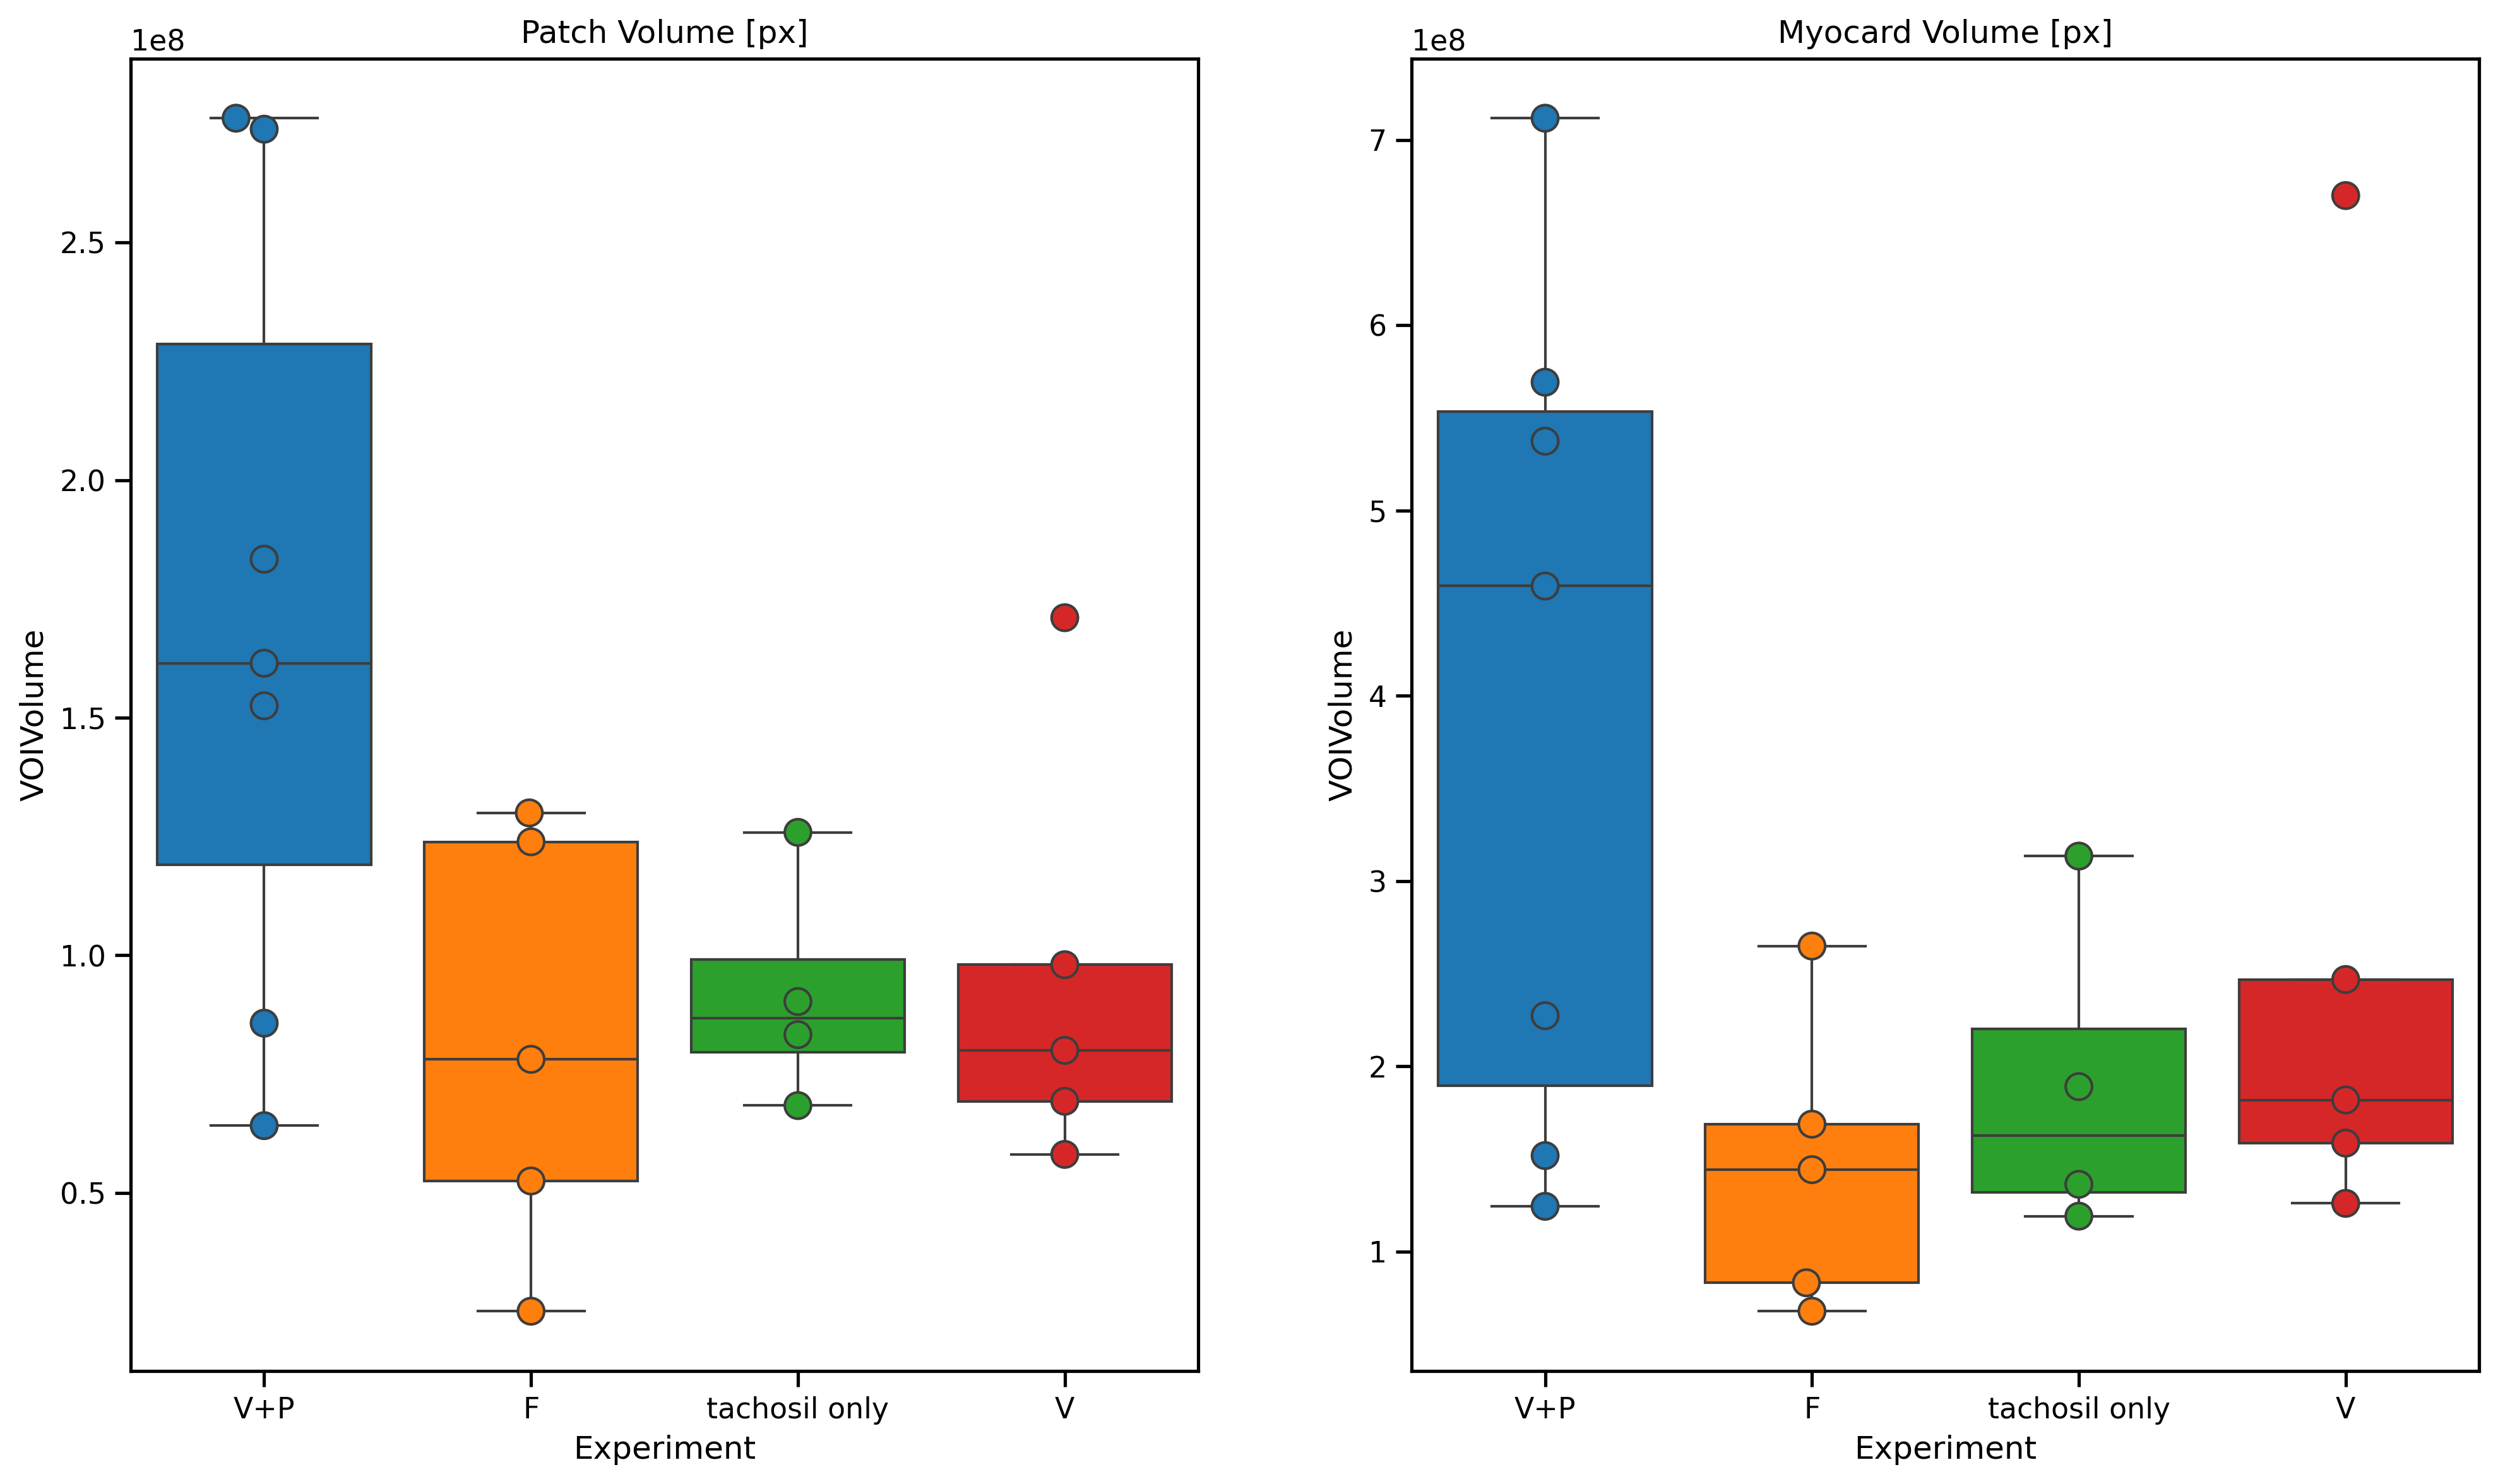

In [112]:
plt.subplot(121)
ax = seaborn.boxplot(data=Data[Data.VOI == 'patch'],
                     x='Experiment',
                     y='VOIVolume',
                     hue='Experiment',
                     saturation=1)
seaborn.swarmplot(data=Data[Data.VOI == 'patch'],
                  x='Experiment',
                  y='VOIVolume',
                  hue='Experiment',
                  s=10,
                  linewidth=1)
plt.title('Patch Volume [px]')
plt.subplot(122)
seaborn.boxplot(data=Data[Data.VOI == 'myocard_sans_patch'],
                x='Experiment',
                y='VOIVolume',
                hue='Experiment',
                saturation=1)
seaborn.swarmplot(data=Data[Data.VOI == 'myocard_sans_patch'],
                  x='Experiment',
                  y='VOIVolume',
                  hue='Experiment',
                  s=10,
                  linewidth=1)
plt.title('Myocard Volume [px]')
plt.savefig(os.path.join(OutputDir, 'VOIs.Volumes.png'))
plt.show()

In [113]:
Data[Data.VOI == 'patch'][['Samplename', 'Experiment', 'VOI', 'VOIVolume']].sort_values(by='VOIVolume')

Samplename     Experiment    VOI  VOIVolume
28      Rat69              F  patch   25116621
22      Rat67              F  patch   52520400
52      Rat84              V  patch   58113215
1       Rat60            V+P  patch   64164003
16      Rat65  tachosil only  patch   68387893
49      Rat83              V  patch   69289713
34      Rat79              F  patch   78120835
43      Rat82              V  patch   80003694
31      Rat71  tachosil only  patch   83318892
4       Rat61            V+P  patch   85728971
13      Rat64  tachosil only  patch   90282990
46      Rat82              V  patch   98032709
7       Rat62              F  patch  123897480
61      Rat90  tachosil only  patch  125882635
10      Rat63              F  patch  129974945
25      Rat68            V+P  patch  152515759
37      Rat80            V+P  patch  161473509
55      Rat87              V  patch  171052401
40      Rat81            V+P  patch  183364180
58      Rat88            V+P  patch  273848044
19      Rat66            V+P  patch  276161536

In [114]:
Data[Data.VOI == 'myocard_sans_patch'][['Samplename', 'Experiment', 'VOI', 'VOIVolume']].sort_values(by='VOIVolume')

Samplename     Experiment                 VOI  VOIVolume
29      Rat69              F  myocard_sans_patch   67772110
23      Rat67              F  myocard_sans_patch   83122502
17      Rat65  tachosil only  myocard_sans_patch  119080045
2       Rat60            V+P  myocard_sans_patch  124384605
53      Rat84              V  myocard_sans_patch  125989653
14      Rat64  tachosil only  myocard_sans_patch  136261150
35      Rat79              F  myocard_sans_patch  144180311
5       Rat61            V+P  myocard_sans_patch  151772729
50      Rat83              V  myocard_sans_patch  158502948
8       Rat62              F  myocard_sans_patch  168742267
47      Rat82              V  myocard_sans_patch  181799772
32      Rat71  tachosil only  myocard_sans_patch  189004666
26      Rat68            V+P  myocard_sans_patch  227267614
44      Rat82              V  myocard_sans_patch  246830737
11      Rat63              F  myocard_sans_patch  264886443
62      Rat90  tachosil only  myocard_sans_patch  313436911
38      Rat80            V+P  myocard_sans_patch  459205811
20      Rat66            V+P  myocard_sans_patch  537402281
41      Rat81            V+P  myocard_sans_patch  569238595
56      Rat87              V  myocard_sans_patch  669992181
59      Rat88            V+P  myocard_sans_patch  711748204

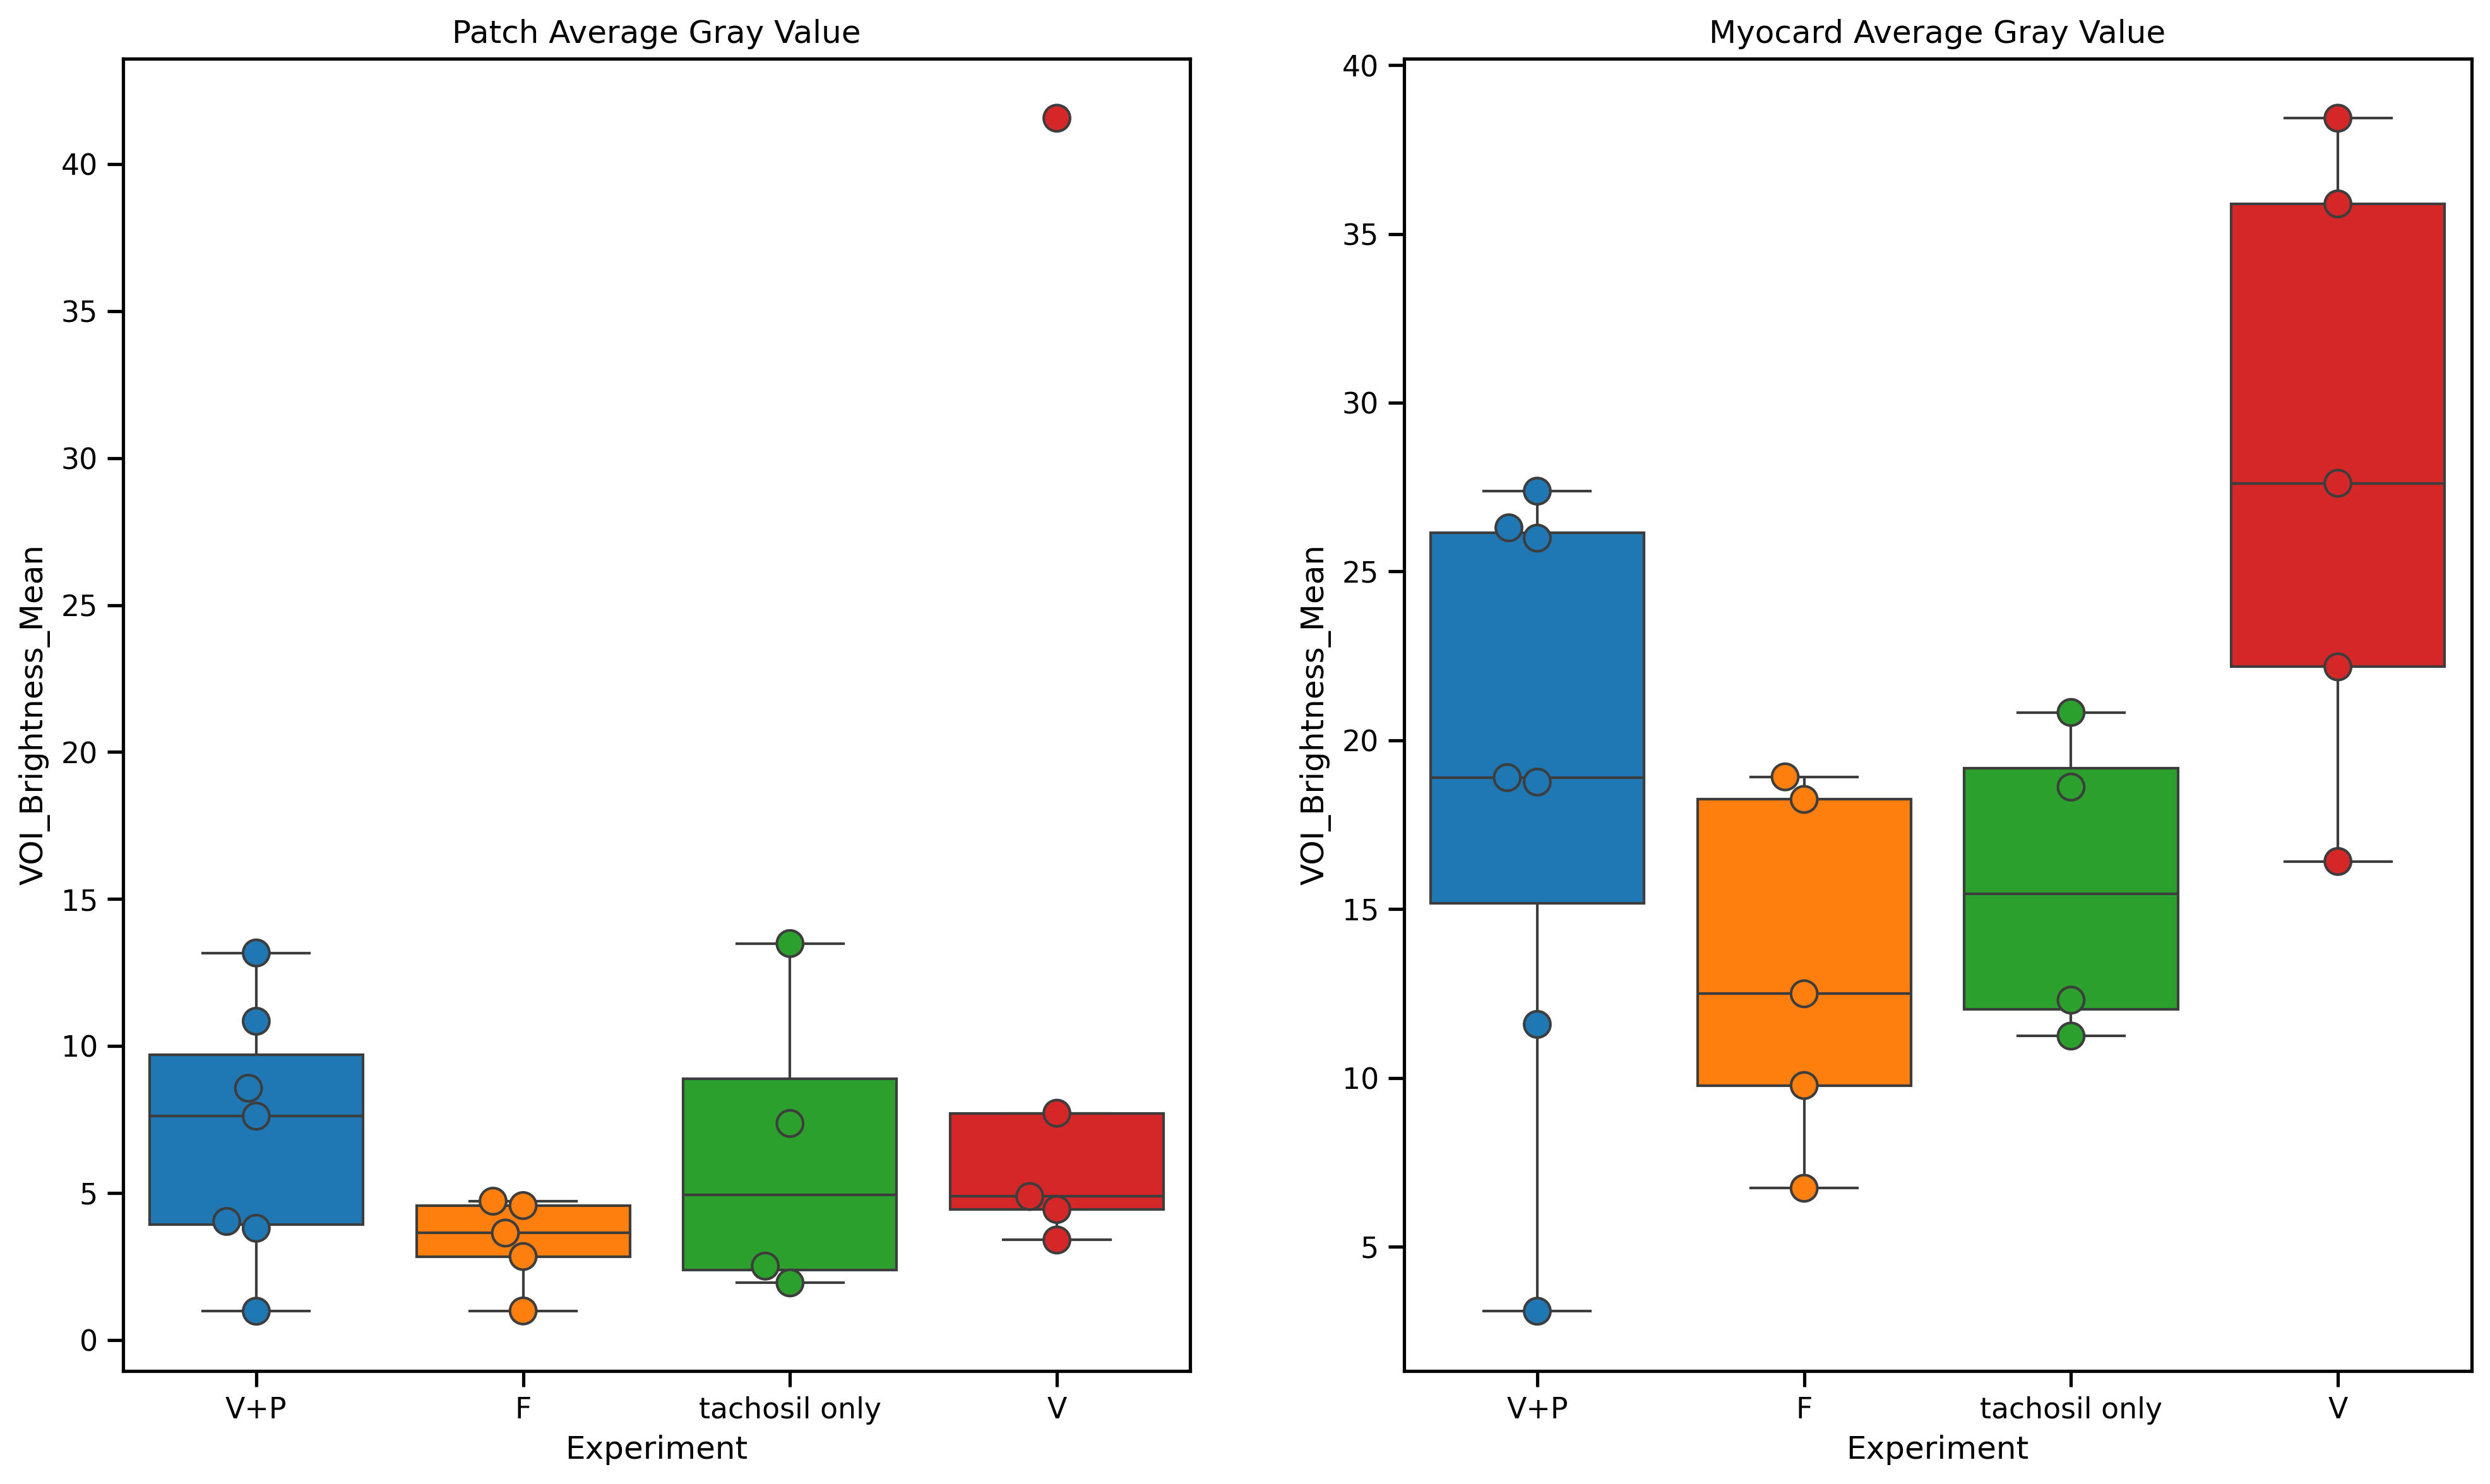

In [115]:
plt.subplot(121)
seaborn.boxplot(data=Data[Data.VOI == 'patch'],
                x='Experiment',
                y='VOI_Brightness_Mean',
                hue='Experiment',
                saturation=1)
seaborn.swarmplot(data=Data[Data.VOI == 'patch'],
                  x='Experiment',
                  y='VOI_Brightness_Mean',
                  hue='Experiment',
                  s=10,
                  linewidth=1)
plt.title('Patch Average Gray Value')
plt.subplot(122)
seaborn.boxplot(data=Data[Data.VOI == 'myocard_sans_patch'],
                x='Experiment',
                y='VOI_Brightness_Mean',
                hue='Experiment',
                saturation=1)
seaborn.swarmplot(data=Data[Data.VOI == 'myocard_sans_patch'],
                  x='Experiment',
                  y='VOI_Brightness_Mean',
                  hue='Experiment',
                  s=10,
                  linewidth=1)
plt.title('Myocard Average Gray Value')
plt.savefig(os.path.join(OutputDir, 'VOIs.AverageGrayValue.png'))
plt.show()

In [116]:
Data[Data.VOI == 'patch'][['Samplename', 'Scan', 'VOI', 'VOI_Brightness_Mean']].sort_values(by='VOI_Brightness_Mean')

Samplename                          Scan    VOI  VOI_Brightness_Mean
4       Rat61                   cu_10um.rec  patch             0.981198
7       Rat62                   cu_10um.rec  patch             0.990457
13      Rat64                   cu_10um.rec  patch             1.943818
16      Rat65                   cu_10um.rec  patch             2.515393
34      Rat79                   cu_10um.rec  patch             2.841438
46      Rat82                   cu_10um.rec  patch             3.403404
22      Rat67                   cu_10um.rec  patch             3.640016
25      Rat68                   cu_10um.rec  patch             3.802631
40      Rat81  2214_7.5um_Al1mm_wetfoam.rec  patch             4.034049
43      Rat82          2214_7.5um_Al1mm.rec  patch             4.441054
28      Rat69                   cu_10um.rec  patch             4.574504
10      Rat63          2214_7.5um_Al1mm.rec  patch             4.723174
52      Rat84                   cu_10um.rec  patch             4.883394
31      Rat71  2214_7.5um_Al1mm_wetfoam.rec  patch             7.367015
37      Rat80  2214_7.5um_Al1mm_wetfoam.rec  patch             7.614424
49      Rat83                   cu_10um.rec  patch             7.715885
1       Rat60                   cu_10um.rec  patch             8.566031
19      Rat66          2214_7.5um_Al1mm.rec  patch            10.843700
58      Rat88  2214_7.5um_Al1mm.rec_reslice  patch            13.166310
61      Rat90                           rec  patch            13.486061
55      Rat87          2214_7.5um_Al1mm.rec  patch            41.558500

In [117]:
Data[Data.VOI == 'myocard_sans_patch'][['Samplename', 'Scan', 'VOI', 'VOI_Brightness_Mean']].sort_values(by='VOI_Brightness_Mean')

Samplename                          Scan                 VOI  \
5       Rat61                   cu_10um.rec  myocard_sans_patch   
8       Rat62                   cu_10um.rec  myocard_sans_patch   
11      Rat63          2214_7.5um_Al1mm.rec  myocard_sans_patch   
32      Rat71  2214_7.5um_Al1mm_wetfoam.rec  myocard_sans_patch   
26      Rat68                   cu_10um.rec  myocard_sans_patch   
14      Rat64                   cu_10um.rec  myocard_sans_patch   
23      Rat67                   cu_10um.rec  myocard_sans_patch   
50      Rat83                   cu_10um.rec  myocard_sans_patch   
35      Rat79                   cu_10um.rec  myocard_sans_patch   
62      Rat90                           rec  myocard_sans_patch   
2       Rat60                   cu_10um.rec  myocard_sans_patch   
20      Rat66          2214_7.5um_Al1mm.rec  myocard_sans_patch   
29      Rat69                   cu_10um.rec  myocard_sans_patch   
17      Rat65                   cu_10um.rec  myocard_sans_patch   
53      Rat84                   cu_10um.rec  myocard_sans_patch   
38      Rat80  2214_7.5um_Al1mm_wetfoam.rec  myocard_sans_patch   
41      Rat81  2214_7.5um_Al1mm_wetfoam.rec  myocard_sans_patch   
59      Rat88  2214_7.5um_Al1mm.rec_reslice  myocard_sans_patch   
44      Rat82          2214_7.5um_Al1mm.rec  myocard_sans_patch   
47      Rat82                   cu_10um.rec  myocard_sans_patch   
56      Rat87          2214_7.5um_Al1mm.rec  myocard_sans_patch   

    VOI_Brightness_Mean  
5              3.087962  
8              6.731564  
11             9.774078  
32            11.239664  
26            11.585387  
14            12.303682  
23            12.491556  
50            16.411599  
35            18.249774  
62            18.615720  
2             18.764542  
20            18.895812  
29            18.918037  
17            20.826346  
53            22.176333  
38            25.991075  
41            26.296489  
59            27.382140  
44            27.615964  
47            35.892173  
56            38.430707

In [118]:
# plt.subplot(121)
# seaborn.boxplot(data=Data[Data.VOI == 'patch'],
#                 x='Experiment',
#                 y='VOI_Brightness_Min',
#                 hue='Experiment',
#                 saturation=1)
# seaborn.swarmplot(data=Data[Data.VOI == 'patch'],
#                   x='Experiment',
#                   y='VOI_Brightness_Min',
#                   hue='Experiment',
#                   s=10,
#                   linewidth=1)
# plt.title('Patch Minimum Gray Value')
# plt.subplot(122)
# seaborn.boxplot(data=Data[Data.VOI == 'myocard_sans_patch'],
#                 x='Experiment',
#                 y='VOI_Brightness_Min',
#                 hue='Experiment',
#                 saturation=1)
# seaborn.swarmplot(data=Data[Data.VOI == 'myocard_sans_patch'],
#                   x='Experiment',
#                   y='VOI_Brightness_Min',
#                   hue='Experiment',
#                   s=10,
#                   linewidth=1)
# plt.title('Myocard Minimum Gray Value')
# plt.savefig(os.path.join(OutputDir, 'VOIs.AverageGrayValue.png'))
# plt.show()

In [119]:
# plt.subplot(121)
# seaborn.boxplot(data=Data[Data.VOI == 'patch'],
#                 x='Experiment',
#                 y='VOI_Brightness_Max',
#                 hue='Experiment',
#                 saturation=1)
# seaborn.swarmplot(data=Data[Data.VOI == 'patch'],
#                   x='Experiment',
#                   y='VOI_Brightness_Max',
#                   hue='Experiment',
#                   s=10,
#                   linewidth=1)
# plt.title('Patch Maximum Gray Value')
# plt.subplot(122)
# seaborn.boxplot(data=Data[Data.VOI == 'myocard_sans_patch'],
#                 x='Experiment',
#                 y='VOI_Brightness_Max',
#                 hue='Experiment',
#                 saturation=1)
# seaborn.swarmplot(data=Data[Data.VOI == 'myocard_sans_patch'],
#                   x='Experiment',
#                   y='VOI_Brightness_Max',
#                   hue='Experiment',
#                   s=10,
#                   linewidth=1)
# plt.title('Myocard Maximum Gray Value')
# plt.savefig(os.path.join(OutputDir, 'VOIs.AverageGrayValue.png'))
# plt.show()

In [120]:
# for c, p in enumerate(Patches):
#     if len(p.shape) != 3:
#         print('Delete %s and run the cell above again!' % Data[Data.VOI == 'patch']['OutputNameVOI'][c][len(Root)+1:])
#         print(c.shape)

In [121]:
# for c, m in enumerate(Myocards):
#     if len(m.shape) != 3:
#         print('Delete %s and run the cell above again!' % Data[Data.VOI == 'myocard']['OutputNameVOI'][c][len(Root)+1:])
#         print(p.shape)

In [122]:
# for file in Data['OutputNameRecCrop']:
#     print(file)
#     dask.array.from_zarr(file)

In [123]:
# for rec in Reconstructions:
#     print(rec.min().compute(), rec.max().compute())

In [124]:
# for c, r in enumerate(Reconstructions):
#     if len(r.shape) > 3:
#         print('Delete %s and run preview notebook again!' % Data['OutputNameRecCrop'][c][len(Root)+1:])
#         print(p.shape)

In [125]:
# scale = 4
# plt.rcParams['figure.figsize'] = (16/scale, 9/scale)  # Size up figures a bit

In [126]:
# for voi in Data.VOI.unique():
#     print(Data[Data.VOI == voi]['OutputNameVOI'])

In [127]:
# for c, row in Data.iterrows():
#     print(c, row.Samplename, row.Scan, row.VOI)
#     plt.semilogy(mkh[c])
#     plt.xlim([0,255])
#     plt.title(os.path.join(os.path.dirname(Data[Data.VOI == row.VOI]['OutputNameVOI'][c][len(Root)+1:]), row.VOI))
#     plt.show()
#     print(80*'-')

In [128]:
# for c, rec in enumerate(Reconstructions):
#     plt.semilogy(rh[c], label='%s/%s' % (Data.Samplename[c], Data.Scan[c]))
#     plt.xlim([0, 2**8])
#     plt.legend()
#     plt.show()

In [129]:
# for c, row in Data[Data.VOI == 'myocard'].iterrows():
#     print(c, row.Samplename, row.Scan)
#     plt.semilogy(mkh[c], label='%s/%s' % (row.Samplename, row.Scan))
#     plt.xlim([0, 2**8])
#     plt.show()

In [130]:
# for c, row in Data[Data.VOI == 'patch'].iterrows():
#     print(c, row.Samplename, row.Scan)
#     plt.semilogy(mkh[c], label='%s/%s' % (row.Samplename, row.Scan))
#     plt.xlim([0, 2**8])
#     plt.show()

In [131]:
# scale = 2
# plt.rcParams['figure.figsize'] = (16/scale, 9/scale)  # Size up figures a bit

In [132]:
for i in MSP:
    if len(i.shape) > 3:
        print(i.shape)

In [133]:
# Put middle image of raw ROI into dataframe for easier handling
Data['Image'] = [v[v.shape[0]//2].compute() for v in VOIs_raw]

In [134]:
# Put middle image of binarized ROI into dataframe for easier handling
Data['ROI'] = [v[v.shape[0]//2].compute() for v in VOIs_binarized]

In [135]:
def get_properties(roi, verbose=False):
    # Label filled image
    labeled_img = skimage.measure.label(roi)
    # Extract regionprops of image and put data into pandas
    # https://stackoverflow.com/a/66632023/323100
    props = skimage.measure.regionprops_table(labeled_img,
                                              properties=('label',
                                                          'centroid',
                                                          'area',
                                                          'perimeter',
                                                          'orientation'
                                                          ))
    table = pandas.DataFrame(props)
    table_sorted = table.sort_values(by='area', ascending=False)
    # return only the region with the biggest area
    properties = table_sorted.iloc[:1].reset_index()
    if verbose:
        plt.imshow(roi, alpha=0.5)
        plt.title('Original')
        plt.axis('off')
        plt.imshow(numpy.ma.masked_equal(labeled_img, 0), cmap='viridis', alpha=0.5)
        plt.title('Labelled')
        plt.axis('off')
        plt.show()
    return properties

In [136]:
# Do it in a loop, so we can use verbose if we want
Data['Properties'] = ''
for c, row in tqdm(Data.iterrows(),
                   desc='Calculate properties',
                   total=len(Data)):
    Data.at[c, 'Properties'] = get_properties(row['ROI'], verbose=False)

Calculate properties:   0%|          | 0/63 [00:00<?, ?it/s]

In [137]:
def get_largest_region(segmentation, verbose=False):
    # Get out biggest item from https://stackoverflow.com/a/55110923/323100
    labels = skimage.measure.label(segmentation)
    assert labels.max() != 0  # assume at least 1 CC
    largestCC = labels == numpy.argmax(numpy.bincount(labels.flat)[1:])+1
    if verbose:
        plt.subplot(121)
        plt.imshow(segmentation)
        plt.subplot(122)
        plt.imshow(largestCC)
        plt.suptitle('Largest connected component')
        plt.show()
    return largestCC

In [138]:
def get_contour(filled_img, verbose=False):
    # Contouring from https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_regionprops.html
    largest_region = get_largest_region(filled_img, verbose=verbose)
    contour = skimage.measure.find_contours(largest_region)
    # Even though we look only at the largest region, we still might get out more than one contour
    # Let's thus sort the list and just continue with the longest one
    (contour).sort(key=len)
    cy, cx = contour[-1].T
    if verbose:
        plt.imshow(filled_img)
        plt.plot(cx, cy, lw=1, c='r')
        plt.axis('off')
        plt.show()
    return cx, cy

In [139]:
Data['Properties'][0]

index  label   centroid-0  centroid-1      area    perimeter  orientation
0      0      1  1229.682961  897.116415  427332.0  2654.167748     0.839073

In [140]:
# Do it in a loop, so we can use verbose if we want
Data['Contour'] = ''
for c, row in tqdm(Data.iterrows(),
                   desc='Extracting contour',
                   total=len(Data)):
    # print(row.Samplename, row.Scan, row.VOI)
    Data.at[c, 'Contour'] = get_contour(row['ROI'], verbose=False)

Extracting contour:   0%|          | 0/63 [00:00<?, ?it/s]

In [141]:
def get_centroid(img, verbose=False):
    props = get_properties(img)
    # Drawing from https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
    y0, x0 = props['centroid-0'], props['centroid-1']
    if verbose:
        plt.imshow(img)
        plt.scatter(props['centroid-1'], props['centroid-0'], marker=None, color='r')
        plt.axis('off')
        plt.show()
    return x0, y0

In [142]:
# Do it in a loop, so we can use verbose if we want
Data['Centroid'] = ''
for c, row in tqdm(Data.iterrows(),
                   desc='Calculating centroid',
                   total=len(Data)):
    Data.at[c, 'Centroid'] = get_centroid(row['ROI'], verbose=False)

Calculating centroid:   0%|          | 0/63 [00:00<?, ?it/s]

In [143]:
def draw_orientation(img, x0, x1, x2, y0, y1, y2, self=False):
    if self:
        plt.imshow(img)
    plt.plot((x0, x1), (y0, y1), '-r', linewidth=1)
    plt.plot((x0, x2), (y0, y2), '-r', linewidth=1)
    if self:
        plt.axis('off')
        plt.show()
    return

In [144]:
def get_orientation(img, voxelsize, length=5000, verbose=False):
    props = get_properties(img)
    whichlengthdowewant = length
    reallength = whichlengthdowewant / voxelsize  # um
    # Drawing from https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.htm
    x0, y0 = get_centroid(img)
    x1 = x0 + math.cos(props['orientation'].iloc[0]) * reallength
    y1 = y0 - math.sin(props['orientation'].iloc[0]) * reallength
    x2 = x0 - math.sin(props['orientation'].iloc[0]) * reallength
    y2 = y0 - math.cos(props['orientation'].iloc[0]) * reallength
    if verbose:
        plt.imshow(img)
        plt.scatter(props['centroid-1'], props['centroid-0'], marker=None, color='r')
        draw_orientation(img, x0, x1, x2, y0, y1, y2)
        plt.gca().add_artist(ScaleBar(voxelsize, 'um'))
        plt.title('Image with %s um long orientation bars' % length)
        plt.axis('off')
        plt.show()
    return x0, x1, x2, y0, y1, y2

In [145]:
# Do it in a loop, so we can use verbose if we want
Data['Orientation'] = ''
for c, row in tqdm(Data.iterrows(),
                   desc='Extracting contour',
                   total=len(Data)):
    Data.at[c, 'Orientation'] = get_orientation(row['ROI'],
                                                voxelsize=row['Voxelsize'],
                                                verbose=False)

Extracting contour:   0%|          | 0/63 [00:00<?, ?it/s]

In [146]:
# lines = 5

In [147]:
# # Draw everything
# for c, row in tqdm(Data.iterrows(), total=len(Data)):
#     # plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)
#     plt.imshow(row.Image)
#     try:
#         plt.plot(row.Contour[0], row.Contour[1], lw=1, c='r')
#     except IndexError:
#         print('No contour found for %s/%s' % (row.Samplename, row.VOI))
#     plt.scatter(row.Centroid[0], row.Centroid[1], marker=None, color='w')
#     draw_orientation(row.ROI,
#                      row.Orientation[0], row.Orientation[1],
#                      row.Orientation[2], row.Orientation[3],
#                      row.Orientation[4], row.Orientation[5])
#     plt.gca().add_artist(ScaleBar(row.Voxelsize, 'um'))
#     plt.axis('off')
#     plt.title('(%s) %s: %s' % (c, row.Samplename, row.VOI))
#     # plt.tight_layout()
#     plt.show()

In [148]:
def midpoint(x1, y1, x2, y2):
    '''calculate the middle between two points'''
    midpoint = (x1 + x2) / 2, (y1 + y2) / 2
    return midpoint

In [149]:
def angle(x1, y1, x2, y2, verbose=False):
    '''calculate the angle between two points'''
    # Verbatim copied from https://stackoverflow.com/a/63926786/323100
    # Difference in x and y coordinates
    dx = x2 - x1
    dy = y2 - y1
    # print(dx)
    # print(dy)
    # Angle between p1 and p2 in radians
    theta = math.atan2(dy, dx)
    # print(theta)
    # We will want to `skimage.transform.rotate` in degrees, so return degrees
    if verbose:
        plt.scatter(x1, y1, label='P1')
        plt.scatter(x2, y2, label='P2')
        plt.plot((x1, x2), (y1, y2))
        plt.scatter(midpoint(x1, y1, x2, y2)[0], midpoint(x1, y1, x1, y2)[1], label='Midpoint')
        plt.legend()
        plt.axis('equal')
        plt.show()
    return math.degrees(theta)

In [150]:
# Set up empty columns
Data['Midpoint'] = ''
Data['Angle'] = ''
Data['Size'] = [voi.shape for voi in VOIs_raw]

In [151]:
# Calculate midpoint between the two centroids
# Calculate angle between the two centroids
for whichone in tqdm(range(0, len(Data), 3)):
    # Calculate the midpoint and save the (3D) coordinates of it into our dataframe
    mp = midpoint(Data['Centroid'][whichone + 1][0], Data['Centroid'][whichone + 1][1],
                  Data['Centroid'][whichone + 2][0], Data['Centroid'][whichone + 2][1])
    Data.at[whichone + 2, 'Midpoint'] = (Data['Size'][whichone][0]//2,
                                         int(round(mp[0].squeeze())),
                                         int(round(mp[1].squeeze())))
    # Calculate the angle of the line between the centroids. We use this angle alter to rotate the images
    ag = angle(Data['Centroid'][whichone + 1][0], Data['Centroid'][whichone + 1][1],
               Data['Centroid'][whichone + 2][0], Data['Centroid'][whichone + 2][1])
    Data.at[whichone + 2, 'Angle'] = ag

  0%|          | 0/21 [00:00<?, ?it/s]

In [152]:
# dask.config.set({"distributed.comm.retry.count": 10})
# dask.config.set({"distributed.comm.timeouts.connect": 30})
# dask.config.set({"distributed.worker.memory.terminate": False})

In [153]:
# Define function to help with dask
def rotateimage(image, angle=1, center=2):
    rotated_image = skimage.transform.rotate(image.compute(),
                                             angle=angle,
                                             center=center,
                                             preserve_range=True)
    return rotated_image

In [154]:
import zarr

In [155]:
# Use the angle and midpoint calculated above to rotate all scans around the midpoint between the two centroids
# Save out as PNG slices and read them in again
Data['OutputNameVOIRotated'] = ''
for c, row in tqdm(Data.iterrows(),
                   total=len(Data),
                   desc='Rotate images'):
    # Generate output name, then check if we actually need to do something :)
    Data.at[c, 'OutputNameVOIRotated'] = row.OutputNameVOI.replace('.zarr', '.rotated.midpoint%04d.%04d.angle%03d.zarr' % (Data['Midpoint'][c - c % 3 + 2][1],
                                                                                                                           Data['Midpoint'][c - c % 3 + 2][2],
                                                                                                                           int(round(Data['Angle'][c - c % 3 + 2]))))
    if not os.path.exists(Data['OutputNameVOIRotated'][c]):
        # Make Output dir for PNG slices
        os.makedirs(Data['OutputNameVOIRotated'][c].replace('.zarr', ''), exist_ok=True)
        # Calculate and write PNGs
        for d, img in tqdm(enumerate(VOIs_raw[c]),
                           total=len(VOIs_raw[c]),
                           desc="Rotating %s/%s/%s" % (row.Samplename, row.Scan, row.VOI),
                           leave=False):
            # plt.imshow(img)
            # plt.show()
            if not os.path.exists(os.path.join(Data['OutputNameVOIRotated'][c].replace('.zarr', ''),
                                               'rotated%04d.png' % d)):
                # Only calculate/rotate if there's something in the image, otherwise we don't have to spend any cycles here...
                if img.mean():
                    rotatedimage = skimage.transform.rotate(img.compute(),
                                                            angle=Data['Angle'][c - c % 3 + 2],
                                                            center=(Data['Midpoint'][c - c % 3 + 2][1], Data['Midpoint'][c - c % 3 + 2][2]),
                                                            preserve_range=True)
                else:
                    rotatedimage = numpy.zeros_like(img)
                imageio.imwrite(os.path.join(Data['OutputNameVOIRotated'][c].replace('.zarr', ''),
                                             'rotated%04d.png' % d),
                                rotatedimage.astype('uint8'))
        # print('Converting %s to zarr' % os.path.join(Data['OutputNameVOIRotated'][c].replace('.zarr', ''),
        #                                             '*.png')[len(Root)+1:])
        # Read all PNGs written above
        VOIRotated = dask_image.imread.imread(os.path.join(Data['OutputNameVOIRotated'][c].replace('.zarr', ''),
                                                           '*.png')).rechunk('auto')
        # Save out as .zarr
        VOIRotated.to_zarr(Data['OutputNameVOIRotated'][c])

Rotate images:   0%|          | 0/63 [00:00<?, ?it/s]

In [156]:
# Use the angle and midpoint calculated above to rotate all binary ROIs around the midpoint between the two centroids
# Save out as PNG slices and read them in again
Data['OutputNameVOIRotated_Binary'] = ''
for c, row in tqdm(Data.iterrows(),
                   total=len(Data),
                   desc='Rotate images'):
    # Generate output name, then check if we actually need to do something :)
    Data.at[c, 'OutputNameVOIRotated_Binary'] = row.OutputNameVOI.replace('.zarr', '.binary.rotated.midpoint%04d.%04d.angle%03d.zarr' % (Data['Midpoint'][c - c % 3 + 2][1],
                                                                                                                                         Data['Midpoint'][c - c % 3 + 2][2],
                                                                                                                                         int(round(Data['Angle'][c - c % 3 + 2]))))
    if not os.path.exists(Data['OutputNameVOIRotated_Binary'][c]):
        # Make Output dir for PNG slices
        os.makedirs(Data['OutputNameVOIRotated_Binary'][c].replace('.zarr', ''), exist_ok=True)
        # Calculate and write PNGs
        for d, img in tqdm(enumerate(VOIs_binarized[c]),
                           total=len(VOIs_binarized[c]),
                           desc="Rotating %s/%s/%s" % (row.Samplename, row.Scan, row.VOI),
                           leave=False):
            # plt.imshow(img)
            # plt.show()
            if not os.path.exists(os.path.join(Data['OutputNameVOIRotated_Binary'][c].replace('.zarr', ''),
                                               'rotated%04d.png' % d)):
                # Only calculate/rotate if there's something in the image, otherwise we don't have to spend any cycles here...
                if img.mean():
                    rotatedimage = skimage.transform.rotate(img.compute(),
                                                            angle=Data['Angle'][c - c % 3 + 2],
                                                            center=(Data['Midpoint'][c - c % 3 + 2][1], Data['Midpoint'][c - c % 3 + 2][2]),
                                                            preserve_range=True)
                else:
                    rotatedimage = numpy.zeros_like(img)
                # print(rotatedimage)
                imageio.imwrite(os.path.join(Data['OutputNameVOIRotated_Binary'][c].replace('.zarr', ''),
                                             'rotated%04d.png' % d),
                                rotatedimage.astype('uint8'))
        print('Converting %s to zarr' % os.path.join(Data['OutputNameVOIRotated'][c].replace('.zarr', ''),
                                                     '*.png')[len(Root)+1:])
        # Read all PNGs written above
        VOIRotated = dask_image.imread.imread(os.path.join(Data['OutputNameVOIRotated_Binary'][c].replace('.zarr', ''),
                                                           '*.png')).rechunk('auto')
        # Save out as .zarr
        VOIRotated.to_zarr(Data['OutputNameVOIRotated_Binary'][c])

Rotate images:   0%|          | 0/63 [00:00<?, ?it/s]

In [157]:
# for file in Data['OutputNameVOIRotated']:
#     print(file)
#     dask.array.from_zarr(file)

In [158]:
# Load *all* rotated VOIs
VOIs_raw_rotated = [dask.array.from_zarr(file) for file in Data['OutputNameVOIRotated']]
VOIs_binarized_rotated = [dask.array.from_zarr(file) for file in Data['OutputNameVOIRotated_Binary']]

In [159]:
# Mask the raw VOI data with their extent, so we can use `nanmean` afterwards
# We mask with the inversion of the binary, so everyghing that is False is masked in the output
VOIs_masked_rotated = [dask.array.ma.masked_array(data=raw.astype('uint32'),
                                                  mask=dask.array.invert(binarized))
                       for raw, binarized in zip(VOIs_raw_rotated, VOIs_binarized_rotated)]
# If we save the masked VOIs out, we loose the masking!

In [160]:
for c, v in enumerate(VOIs_raw_rotated):
    if len(v.shape) != 3:
        print(v.shape)
        print(Data['OutputNameVOIRotated'][c])

In [161]:
for c, v in enumerate(VOIs_binarized_rotated):
    if len(v.shape) != 3:
        print(v.shape)
        print(Data['OutputNameVOIRotated'][c])

In [162]:
# Get rotated middle image (for display below)
Data['Image_rotated'] = [v[v.shape[0]//2].compute() for v in VOIs_raw_rotated]

In [163]:
# Put middle image of binarized ROI into dataframe for easier handling
Data['ROI_rotated'] = [v[v.shape[0]//2].compute() for v in VOIs_binarized_rotated]

In [164]:
# plt.imshow(Data['Image_rotated'][0])
# plt.imshow(Data['ROI_rotated'][0], alpha=0.5)

In [165]:
# Push the contrast
vmax = 64

In [166]:
# # Display what we calculated above
# for whichone in range(0, len(Data), 3):
#     plt.subplot(141)
#     # Display original data
#     plt.imshow(Data['Image'][whichone + 1])
#     plt.imshow(Data['Image'][whichone + 2], cmap='viridis', alpha=0.5)
#     # Display the relevant contours
#     plt.plot(Data['Contour'][whichone + 1][0], Data['Contour'][whichone + 1][1], '--', lw=2, color='w', label='Patch')
#     plt.plot(Data['Contour'][whichone + 2][0], Data['Contour'][whichone + 2][1], '--', lw=2, color=seaborn.color_palette()[2], label='Myocard')
#     # Plot the centroids
#     plt.scatter(Data['Centroid'][whichone + 1][0], Data['Centroid'][whichone + 1][1], color=seaborn.color_palette()[1], s=10, label='Centroid Patch')
#     plt.scatter(Data['Centroid'][whichone + 2][0], Data['Centroid'][whichone + 2][1], color=seaborn.color_palette()[2], s=10, label='Centroid Myocard')
#     # Display the centerpoint
#     plt.scatter(Data['Midpoint'][whichone + 2][1], Data['Midpoint'][whichone + 2][2], s=10, label='Midpoint')
#     plt.axis('off')
#     plt.title('Original data')
#     plt.legend()
#     plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
#     plt.subplot(142)
#     plt.imshow(Data['Image_rotated'][whichone])
#     plt.scatter(Data['Midpoint'][whichone + 2][1], Data['Midpoint'][whichone + 2][2], s=10, label='Center')
#     plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
#     plt.axis('off')
#     plt.title('Myocard + Patch')
#     plt.subplot(143)
#     plt.imshow(Data['Image_rotated'][whichone + 1])
#     plt.scatter(Data['Midpoint'][whichone + 2][1], Data['Midpoint'][whichone + 2][2], s=10, label='Center')
#     plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
#     plt.axis('off')
#     plt.title('Patch')
#     plt.subplot(144)
#     plt.imshow(Data['Image_rotated'][whichone + 2])
#     plt.scatter(Data['Midpoint'][whichone + 2][1], Data['Midpoint'][whichone + 2][2], s=10, label='Center')
#     plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
#     plt.axis('off')
#     plt.title('Myocard - Patch')
#     plt.suptitle('Slice %s of %s/%s\nCenter at %s' % (Data['Size'][whichone][0]//2, Data['Samplename'][whichone], Data['Scan'][whichone], Data['Midpoint'][whichone + 2]), y=0.75)
#     # Save the image
#     outpath = os.path.join(os.path.dirname(Data['Folder'][whichone]), '%s.%s.rotation.png' % (Data['Samplename'][whichone], Data['Scan'][whichone]))
#     if not os.path.exists(outpath):
#         plt.savefig(outpath,
#                     facecolor='white', transparent=False,
#                     bbox_inches='tight')
#     plt.tight_layout
#     plt.show()

In [167]:
# # Show slices with overlaid ROI
# for c, row in tqdm(Data.iterrows(),
#                    total=len(Data),
#                    desc='Showing rotated datasets with overlaid ROI'):    
#     # Show middle slice of raw VOI with equalized histogram
#     plt.imshow(skimage.exposure.equalize_adapthist(VOIs_raw_rotated[c][row['MiddleSliceNumber']]))
#     # Overlay contour, which we'll extract on the fly
#     contours = skimage.measure.find_contours(VOIs_binarized_rotated[c][row['MiddleSliceNumber']].compute())
#     for contour in contours:
#         plt.plot(contour[:, 1], contour[:, 0], alpha=0.5, c=Data['ColorExperiment'][c])
#     if row['VOI'] == 'patch':
#         plt.title('%s/%s/%s/%s/slice %s\nPatch drawn by Tim, rotated' % (row['Samplename'],
#                                                                          row['Scan'],
#                                                                          row['VOI'],
#                                                                          row['Experiment'],
#                                                                          row['MiddleSliceNumber']))
#     elif row['VOI'] == 'myocard':
#         plt.title('%s/%s/%s/%s/slice %s\n"Pizza slice" drawn by Tim, rotated' % (row['Samplename'],
#                                                                                  row['Scan'],
#                                                                                  row['VOI'],
#                                                                                  row['Experiment'],
#                                                                                  row['MiddleSliceNumber']))
#     elif 'sans' in row['VOI']:
#         plt.title('%s: Raw M-P slice %s' % (row.Samplename, row['MiddleSliceNumber']))
#         plt.title('%s/%s/%s/%s/slice %s\nMyocard - Patch ROI, rotated' % (row['Samplename'],
#                                                                           row['Scan'],
#                                                                           row['VOI'],
#                                                                           row['Experiment'],
#                                                                           row['MiddleSliceNumber']))
#     plt.gca().add_artist(ScaleBar(row.Voxelsize, 'um'))
#     plt.axis('off')
#     # Save the image out
#     outpath = os.path.join(os.path.dirname(row['Folder']),
#                            '%s.%s.ROIOverlay.Rotated.%s.png' % (row['Samplename'], row['Scan'], row['VOI']))
#     if not os.path.exists(outpath):
#         plt.savefig(outpath,
#                     facecolor='white',
#                     transparent=False,
#                     bbox_inches='tight')
    
#     plt.show()

In [168]:
Data[['Samplename', 'Scan', 'Centroid', 'Midpoint', 'VOI', 'Angle']][-10:]

Samplename                          Scan  \
53      Rat84                   cu_10um.rec   
54      Rat87          2214_7.5um_Al1mm.rec   
55      Rat87          2214_7.5um_Al1mm.rec   
56      Rat87          2214_7.5um_Al1mm.rec   
57      Rat88  2214_7.5um_Al1mm.rec_reslice   
58      Rat88  2214_7.5um_Al1mm.rec_reslice   
59      Rat88  2214_7.5um_Al1mm.rec_reslice   
60      Rat90                           rec   
61      Rat90                           rec   
62      Rat90                           rec   

                                        Centroid           Midpoint  \
53  ([1627.4877531161055], [1395.2842206996415])  (239, 1794, 1426)   
54    ([1232.005785266475], [655.3833257135083])                      
55  ([1292.0137299156322], [391.15280240743726])                      
56   ([1213.5195271194473], [736.7831085709083])   (701, 1253, 564)   
57  ([1320.8592639337232], [2671.0082206742554])                      
58  ([1365.9299735243355], [3016.0971888808235])                      
59     ([1304.378857860834], [2544.29466513591])  (539, 1335, 2780)   
60   ([1608.6618009617052], [2217.136556657573])                      
61   ([1712.9596684079672], [2383.038571668017])                      
62   ([1571.7687334639338], [2158.452382305205])  (397, 1642, 2271)   

                   VOI       Angle  
53  myocard_sans_patch  -169.68524  
54             myocard              
55               patch              
56  myocard_sans_patch  102.795101  
57             myocard              
58               patch              
59  myocard_sans_patch    -97.4328  
60             myocard              
61               patch              
62  myocard_sans_patch -122.156405

In [169]:
def puncher(whichone, radius_um, verbose=False):
    '''
    Punch out a slab around the midpoint.
    We use this for extracting the gray values along the line
    '''
    print('Working on %s/%s/%s' % (Data['Samplename'][whichone],
                                   Data['Scan'][whichone],
                                   Data['VOI'][whichone]))
    radius_px = int(round(radius_um / Data['Voxelsize'][whichone]))
    if verbose:
        print('The requested "radius" of %s um corresponds to %s px' % (radius_um, radius_px))
    midpoint = Data['Midpoint'][whichone - whichone % 3 + 2]
    print('The calculated midpoint is at %s' % str(midpoint))
    if verbose:
        for c, m in enumerate(midpoint):
            print('On axis %s we are cutting out from %04s-%03s:%04s+%03s' % (c, m, radius_px, m, radius_px))
            print('                                  %04s    :%04s' % (m-radius_px, m+radius_px))
    # Generate empty image
    # We have to use a '.compute()' step to make it work in dask. This is inefficient, but works...
    slab = dask.array.zeros_like(VOIs_raw_rotated[whichone]).compute()
    # Copy original image values into relevant slices
    slab[midpoint[0] - radius_px:midpoint[0] + radius_px] = VOIs_raw_rotated[whichone][midpoint[0] - radius_px:midpoint[0] + radius_px]
    # Set region outside of slab to zero
    # On z-Axis -> horizontal slab
    if verbose:
        print('Setting "%s:%s,:,:" to False' % (midpoint[0] - radius_px, midpoint[0] + radius_px))
    slab[:midpoint[0] - radius_px, :, :] = False
    slab[midpoint[0] + radius_px:, :, :] = False
    # On y-Axis -> top-down slab
    if verbose:
        print('Setting ":,%s:%s,:" to False' % (midpoint[1] - radius_px, midpoint[1] + radius_px))
    slab[:, :midpoint[2] - radius_px, :] = False
    slab[:, midpoint[2] + radius_px:, :] = False
    # NOT setting it on x-Axis, otherwise we would get only a small cube around the midpoint
    # if verbose:
    #     print('Setting ":,:,%s:%s" to False' % (midpoint[2] - radius_px, midpoint[2] + radius_px))
    #     slab[:,:,:midpoint[1] - radius_px] = False
    #     slab[:,:,midpoint[1] + radius_px:] = False
    if verbose:
        plt.subplot(221)
        plt.imshow(Data['Image'][whichone])
        plt.plot(Data['Contour'][whichone][0],
                 Data['Contour'][whichone][1],
                 '--',
                 c=Data['ColorExperiment'][whichone])
        plt.scatter(midpoint[1],
                    midpoint[2],
                    marker='x',
                    c=Data['ColorExperiment'][whichone])
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
        plt.axis('off')
        plt.title('Original\nMidpoint @ %s' % str(midpoint))
        for c, direction in enumerate(directions):
            plt.subplot(2, 2, c+2)
            plt.imshow(VOIs_raw_rotated[whichone].max(axis=c), alpha=0.5)
            plt.imshow(slab.max(axis=c), alpha=0.5)
            if c == 0:
                # Midpoint
                plt.scatter(midpoint[1],
                            midpoint[2],
                            marker='x',
                            c=Data['ColorExperiment'][whichone])
                # Slab extent
                plt.axhline(midpoint[2] - radius_px, c=Data['ColorExperiment'][whichone])
                plt.axhline(midpoint[2] + radius_px, c=Data['ColorExperiment'][whichone])
                plt.title('%s Slab MIP, rotated\nMidpoint @ (%s, %s)' % (direction, midpoint[1], midpoint[2]))
            elif c == 1:
                # Midpoint
                plt.scatter(midpoint[1],
                            midpoint[0],
                            marker='x',
                            c=Data['ColorExperiment'][whichone])
                # Slab extent
                plt.axhline(midpoint[0] - radius_px, c=Data['ColorExperiment'][whichone])
                plt.axhline(midpoint[0] + radius_px, c=Data['ColorExperiment'][whichone])
                plt.title('%s Slab MIP, rotated\nMidpoint @ (%s, %s)' % (direction, midpoint[1], midpoint[0]))
            elif c == 2:
                plt.scatter(midpoint[2],
                            midpoint[0],
                            marker='x',
                            c=Data['ColorExperiment'][whichone])
                # print(Data['Midpoint'][whichone][1])
                plt.axhline(midpoint[0] - radius_px,
                            xmin=(midpoint[2] - radius_px) / VOIs_raw_rotated[whichone].max(axis=2).shape[1],
                            xmax=(midpoint[2] + radius_px) / VOIs_raw_rotated[whichone].max(axis=2).shape[1],
                            c=Data['ColorExperiment'][whichone])
                plt.axhline(midpoint[0] + radius_px,
                            xmin=(midpoint[2] - radius_px) / VOIs_raw_rotated[whichone].max(axis=2).shape[1],
                            xmax=(midpoint[2] + radius_px) / VOIs_raw_rotated[whichone].max(axis=2).shape[1],
                            c=Data['ColorExperiment'][whichone])
                plt.axvline(midpoint[2] - radius_px,
                            ymin=(midpoint[0] - radius_px) / VOIs_raw_rotated[whichone].max(axis=2).shape[0],
                            ymax=(midpoint[0] + radius_px) / VOIs_raw_rotated[whichone].max(axis=2).shape[0],
                            c=Data['ColorExperiment'][whichone])
                plt.axvline(midpoint[2] + radius_px,
                            ymin=(midpoint[0] - radius_px) / VOIs_raw_rotated[whichone].max(axis=2).shape[0],
                            ymax=(midpoint[0] + radius_px) / VOIs_raw_rotated[whichone].max(axis=2).shape[0],
                            c=Data['ColorExperiment'][whichone])
                plt.title('%s Slab MIP, rotated\nMidpoint @ (%s, %s)' % (direction, midpoint[2], midpoint[0]))
            plt.axis('off')
            plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
        plt.suptitle('%s/%s/%s' % (Data['Samplename'][whichone],
                                   Data['Scan'][whichone],
                                   Data['VOI'][whichone]))
        # Save the image
        outpath = os.path.join(os.path.dirname(Data['Folder'][whichone]),
                               '%s.%s.%s.slab.png' % (Data['Samplename'][whichone],
                                                      Data['Scan'][whichone],
                                                      Data['VOI'][whichone]))
        # if not os.path.exists(outpath):
        plt.savefig(outpath,
                    facecolor='white',
                    transparent=False,
                    bbox_inches='tight')
        plt.show()
    return slab

Working on Rat82/2214_7.5um_Al1mm.rec/myocard_sans_patch
The requested "radius" of 1500 um corresponds to 200 px
The calculated midpoint is at (376, 972, 1939)
On axis 0 we are cutting out from  376-200: 376+200
                                   176    : 576
On axis 1 we are cutting out from  972-200: 972+200
                                   772    :1172
On axis 2 we are cutting out from 1939-200:1939+200
                                  1739    :2139
Setting "176:576,:,:" to False
Setting ":,772:1172,:" to False


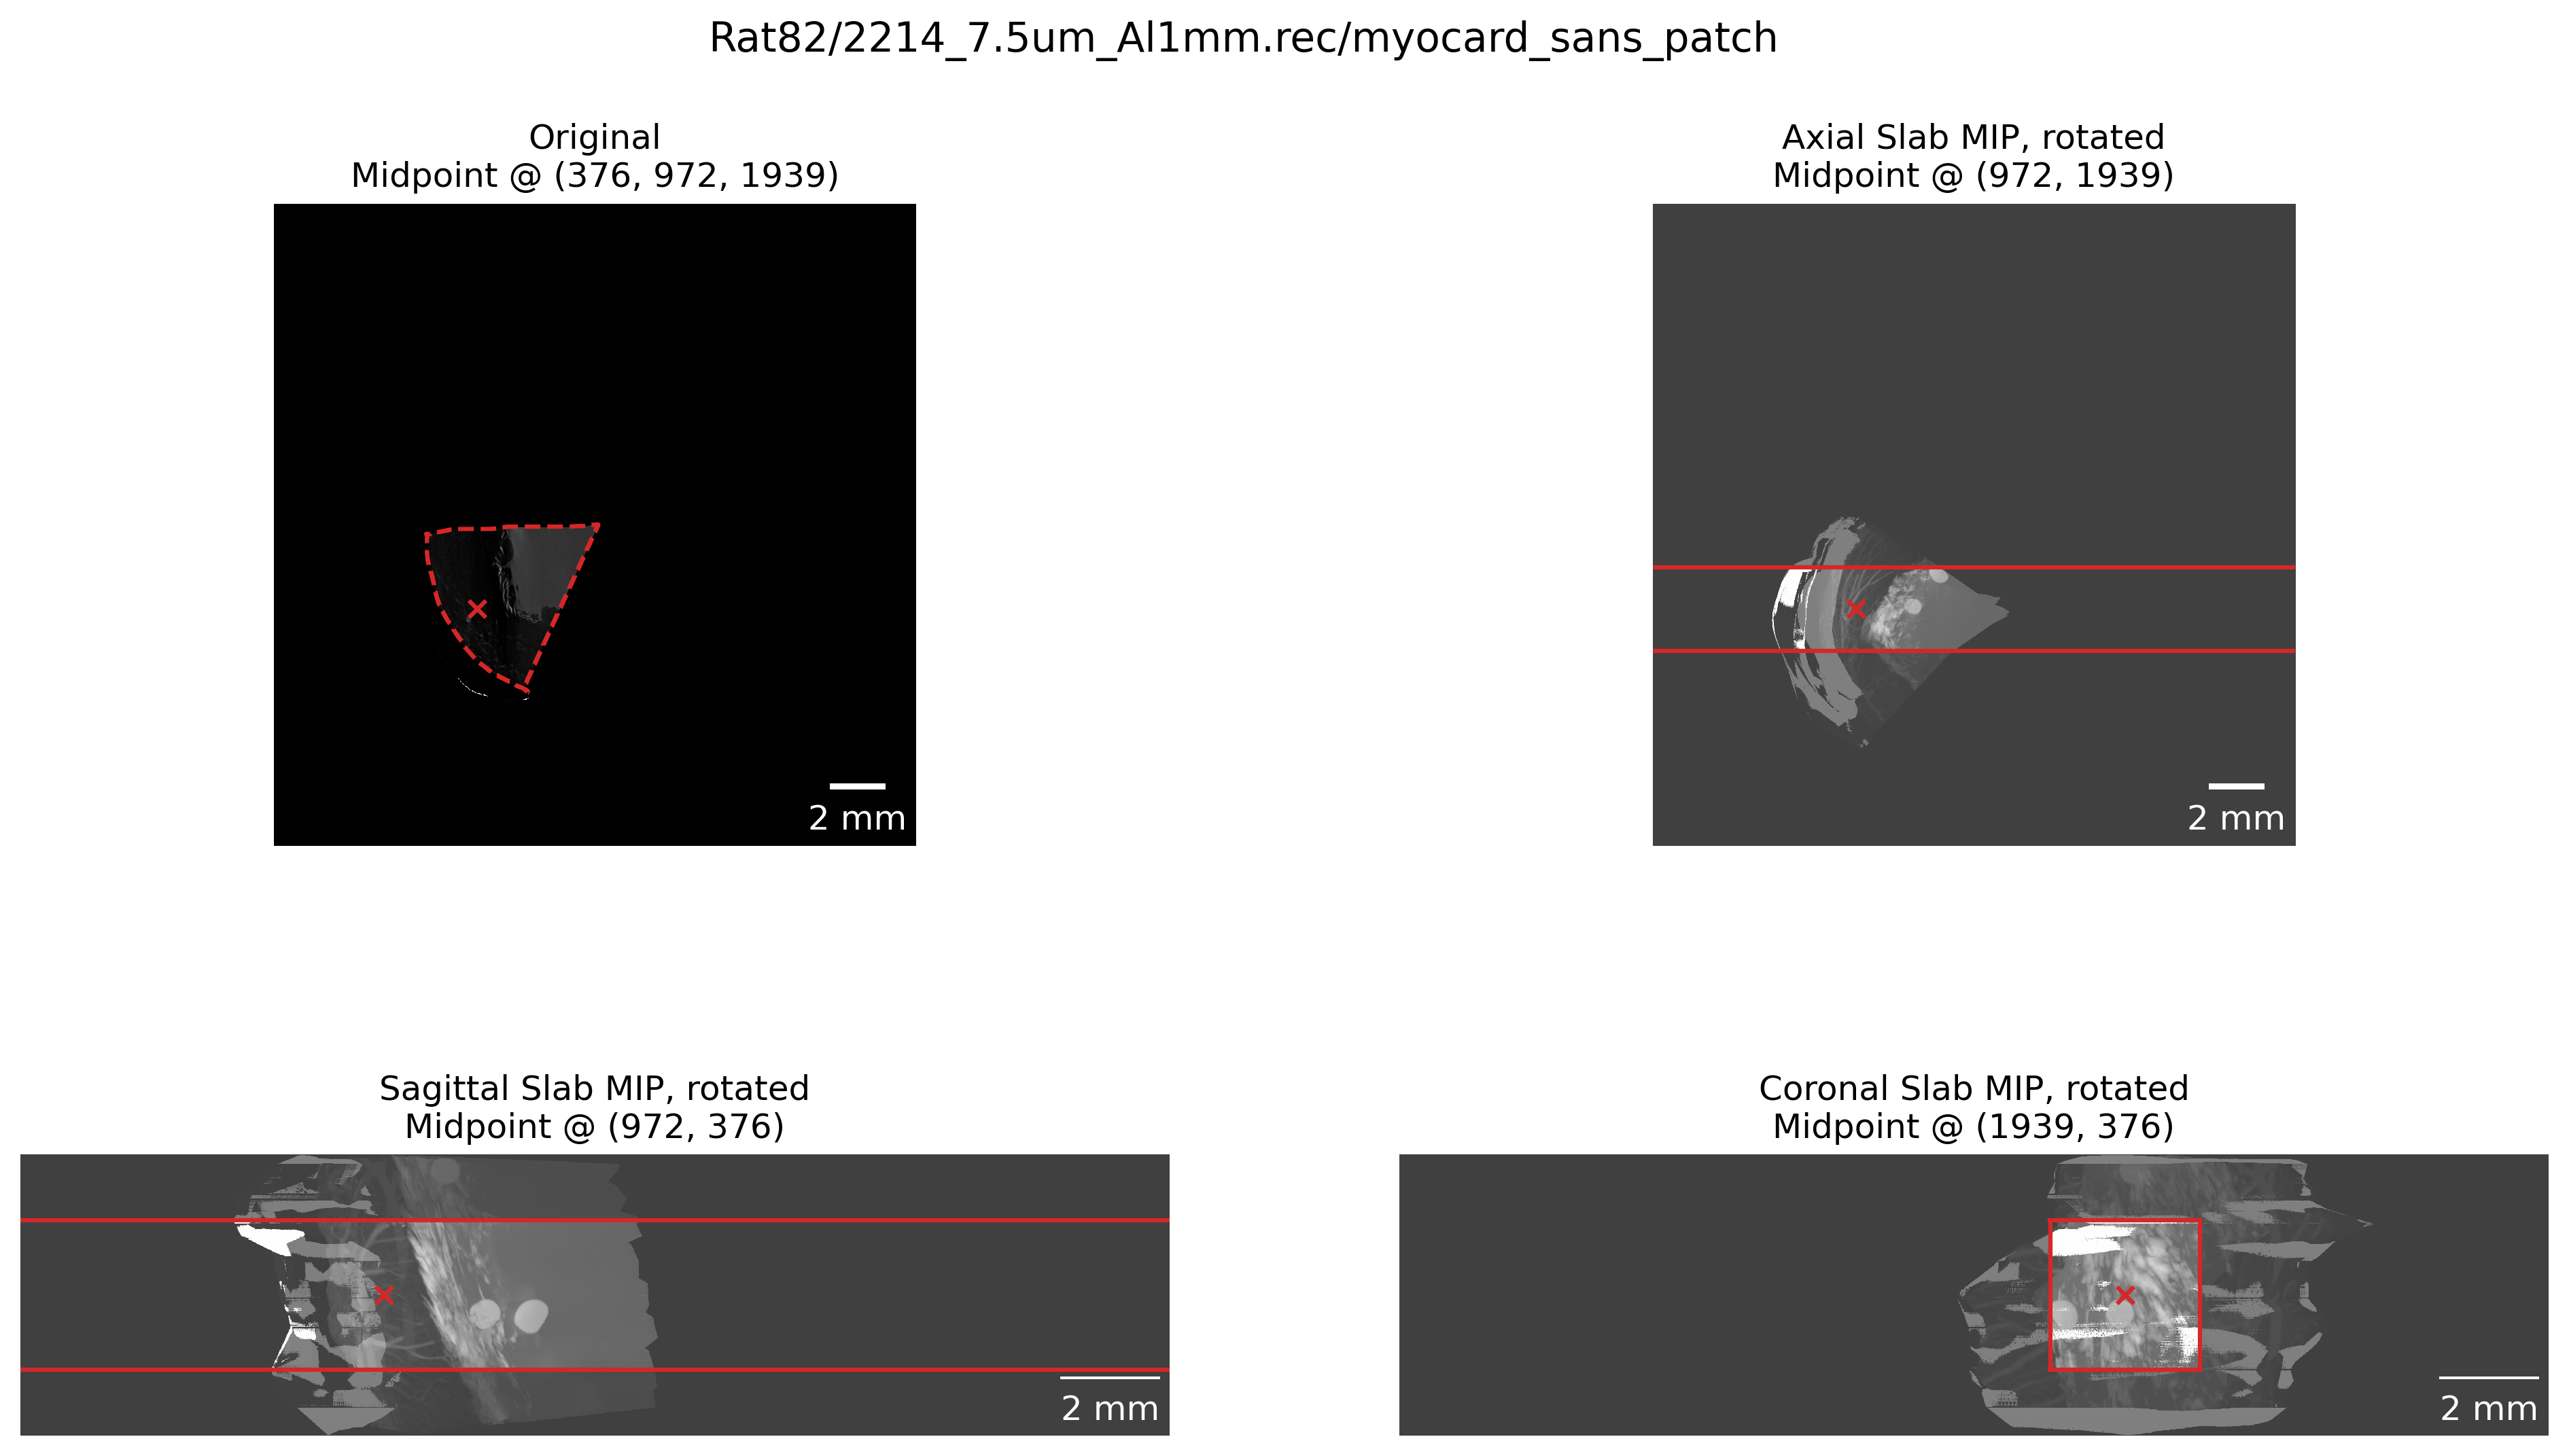

In [170]:
a = puncher(44, 1500, verbose=True)

In [171]:
# Cut out a slab from all images
radius_um = 500  # um
Data['OutputNameSlab'] = ''
for c, row in tqdm(Data.iterrows(), total=len(Data),
                   desc='Extracting slabs'):
    # generate output name, then check if we actually need to do something :)
    Data.at[c, 'OutputNameSlab'] = row.OutputNameVOI.replace('.zarr',
                                                             '.rotated.midpoint%04d.%04d.angle%03d.slab.radius%04dum.zarr' % (Data['Midpoint'][c - c % 3 + 2][1],
                                                                                                                              Data['Midpoint'][c - c % 3 + 2][2],
                                                                                                                              int(round(Data['Angle'][c - c % 3 + 2])),
                                                                                                                              radius_um))
    if not os.path.exists(Data['OutputNameSlab'][c]):
        Slab = puncher(c, radius_um, verbose=True)
        print('Saving a slab of %s/%s to %s' % (row.Samplename,
                                                row.VOI,
                                                Data['OutputNameSlab'][c][len(Root):]))
        zarr.save(Data['OutputNameSlab'][c], Slab)

Extracting slabs:   0%|          | 0/63 [00:00<?, ?it/s]

In [172]:
def puncher_mask(whichone, radius_um, verbose=False):
    '''
    Punch out a slab around the midpoint.
    We use this for extracting the gray values along the line
    '''
    print('Working on %s/%s/%s' % (Data['Samplename'][whichone],
                                   Data['Scan'][whichone],
                                   Data['VOI'][whichone]))
    radius_px = int(round(radius_um / Data['Voxelsize'][whichone]))
    if verbose:
        print('The requested "radius" of %s um corresponds to %s px' % (radius_um, radius_px))
    midpoint = Data['Midpoint'][whichone - whichone % 3 + 2]
    print('The calculated midpoint is at %s' % str(midpoint))
    if verbose:
        for c, m in enumerate(midpoint):
            print('On axis %s we are cutting out from %04s-%03s:%04s+%03s' % (c, m, radius_px, m, radius_px))
            print('                                  %04s    :%04s' % (m-radius_px, m+radius_px))
    # Generate empty image
    # We have to use a '.compute()' step to make it work in dask. This is inefficient, but works...
    slab = dask.array.zeros_like(VOIs_binarized_rotated[whichone]).compute()
    # Copy original image values into relevant slices
    slab[midpoint[0] - radius_px:midpoint[0] + radius_px] = VOIs_binarized_rotated[whichone][midpoint[0] - radius_px:midpoint[0] + radius_px]
    # Set region outside of slab to zero
    # On z-Axis -> horizontal slab
    if verbose:
        print('Setting "%s:%s,:,:" to False' % (midpoint[0] - radius_px, midpoint[0] + radius_px))
    slab[:midpoint[0] - radius_px, :, :] = False
    slab[midpoint[0] + radius_px:, :, :] = False
    # On y-Axis -> top-down slab
    if verbose:
        print('Setting ":,%s:%s,:" to False' % (midpoint[1] - radius_px, midpoint[1] + radius_px))
    slab[:, :midpoint[2] - radius_px, :] = False
    slab[:, midpoint[2] + radius_px:, :] = False
    # NOT setting it on x-Axis, otherwise we would get only a small cube around the midpoint
    # if verbose:
    #     print('Setting ":,:,%s:%s" to False' % (midpoint[2] - radius_px, midpoint[2] + radius_px))
    #     slab[:,:,:midpoint[1] - radius_px] = False
    #     slab[:,:,midpoint[1] + radius_px:] = False
    if verbose:
        plt.subplot(221)
        plt.imshow(Data['Image'][whichone])
        plt.plot(Data['Contour'][whichone][0],
                 Data['Contour'][whichone][1],
                 '--',
                 c=Data['ColorExperiment'][whichone])
        plt.scatter(midpoint[1],
                    midpoint[2],
                    marker='x',
                    c=Data['ColorExperiment'][whichone])
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
        plt.axis('off')
        plt.title('Original\nMidpoint @ %s' % str(midpoint))
        for c, direction in enumerate(directions):
            plt.subplot(2, 2, c+2)
            plt.imshow(VOIs_binarized_rotated[whichone].max(axis=c), alpha=0.5)
            plt.imshow(slab.max(axis=c), alpha=0.5)
            if c == 0:
                # Midpoint
                plt.scatter(midpoint[1],
                            midpoint[2],
                            marker='o',
                            c=Data['ColorExperiment'][whichone])
                # Slab extent
                plt.axhline(midpoint[2] - radius_px, c=Data['ColorExperiment'][whichone])
                plt.axhline(midpoint[2] + radius_px, c=Data['ColorExperiment'][whichone])
                plt.title('%s Slab MIP, rotated\nMidpoint @ (%s, %s)' % (direction, midpoint[1], midpoint[2]))
            elif c == 1:
                # Midpoint
                plt.scatter(midpoint[1],
                            midpoint[0],
                            marker='o',
                            c=Data['ColorExperiment'][whichone])
                # Slab extent
                plt.axhline(midpoint[0] - radius_px, c=Data['ColorExperiment'][whichone])
                plt.axhline(midpoint[0] + radius_px, c=Data['ColorExperiment'][whichone])
                plt.title('%s Slab MIP, rotated\nMidpoint @ (%s, %s)' % (direction, midpoint[1], midpoint[0]))
            elif c == 2:
                plt.scatter(midpoint[2],
                            midpoint[0],
                            marker='o',
                            c=Data['ColorExperiment'][whichone])
                # print(Data['Midpoint'][whichone][1])
                plt.axhline(midpoint[0] - radius_px,
                            xmin=(midpoint[2] - radius_px) / VOIs_raw_rotated[whichone].max(axis=2).shape[1],
                            xmax=(midpoint[2] + radius_px) / VOIs_raw_rotated[whichone].max(axis=2).shape[1],
                            c=Data['ColorExperiment'][whichone])
                plt.axhline(midpoint[0] + radius_px,
                            xmin=(midpoint[2] - radius_px) / VOIs_raw_rotated[whichone].max(axis=2).shape[1],
                            xmax=(midpoint[2] + radius_px) / VOIs_raw_rotated[whichone].max(axis=2).shape[1],
                            c=Data['ColorExperiment'][whichone])
                plt.axvline(midpoint[2] - radius_px,
                            ymin=(midpoint[0] - radius_px) / VOIs_raw_rotated[whichone].max(axis=2).shape[0],
                            ymax=(midpoint[0] + radius_px) / VOIs_raw_rotated[whichone].max(axis=2).shape[0],
                            c=Data['ColorExperiment'][whichone])
                plt.axvline(midpoint[2] + radius_px,
                            ymin=(midpoint[0] - radius_px) / VOIs_raw_rotated[whichone].max(axis=2).shape[0],
                            ymax=(midpoint[0] + radius_px) / VOIs_raw_rotated[whichone].max(axis=2).shape[0],
                            c=Data['ColorExperiment'][whichone])
                plt.title('%s Slab MIP, rotated\nMidpoint @ (%s, %s)' % (direction, midpoint[2], midpoint[0]))
            plt.axis('off')
            plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
        plt.suptitle('%s/%s/%s' % (Data['Samplename'][whichone],
                                   Data['Scan'][whichone],
                                   Data['VOI'][whichone]))
        # Save the image
        outpath = os.path.join(os.path.dirname(Data['Folder'][whichone]),
                               '%s.%s.%s.binarized.slab.png' % (Data['Samplename'][whichone],
                                                                Data['Scan'][whichone],
                                                                Data['VOI'][whichone]))
        # if not os.path.exists(outpath):
        plt.savefig(outpath,
                    facecolor='white',
                    transparent=False,
                    bbox_inches='tight')
        plt.show()
    return slab

Working on Rat87/2214_7.5um_Al1mm.rec/patch
The requested "radius" of 500 um corresponds to 67 px
The calculated midpoint is at (701, 1253, 564)
On axis 0 we are cutting out from  701- 67: 701+ 67
                                   634    : 768
On axis 1 we are cutting out from 1253- 67:1253+ 67
                                  1186    :1320
On axis 2 we are cutting out from  564- 67: 564+ 67
                                   497    : 631
Setting "634:768,:,:" to False
Setting ":,1186:1320,:" to False


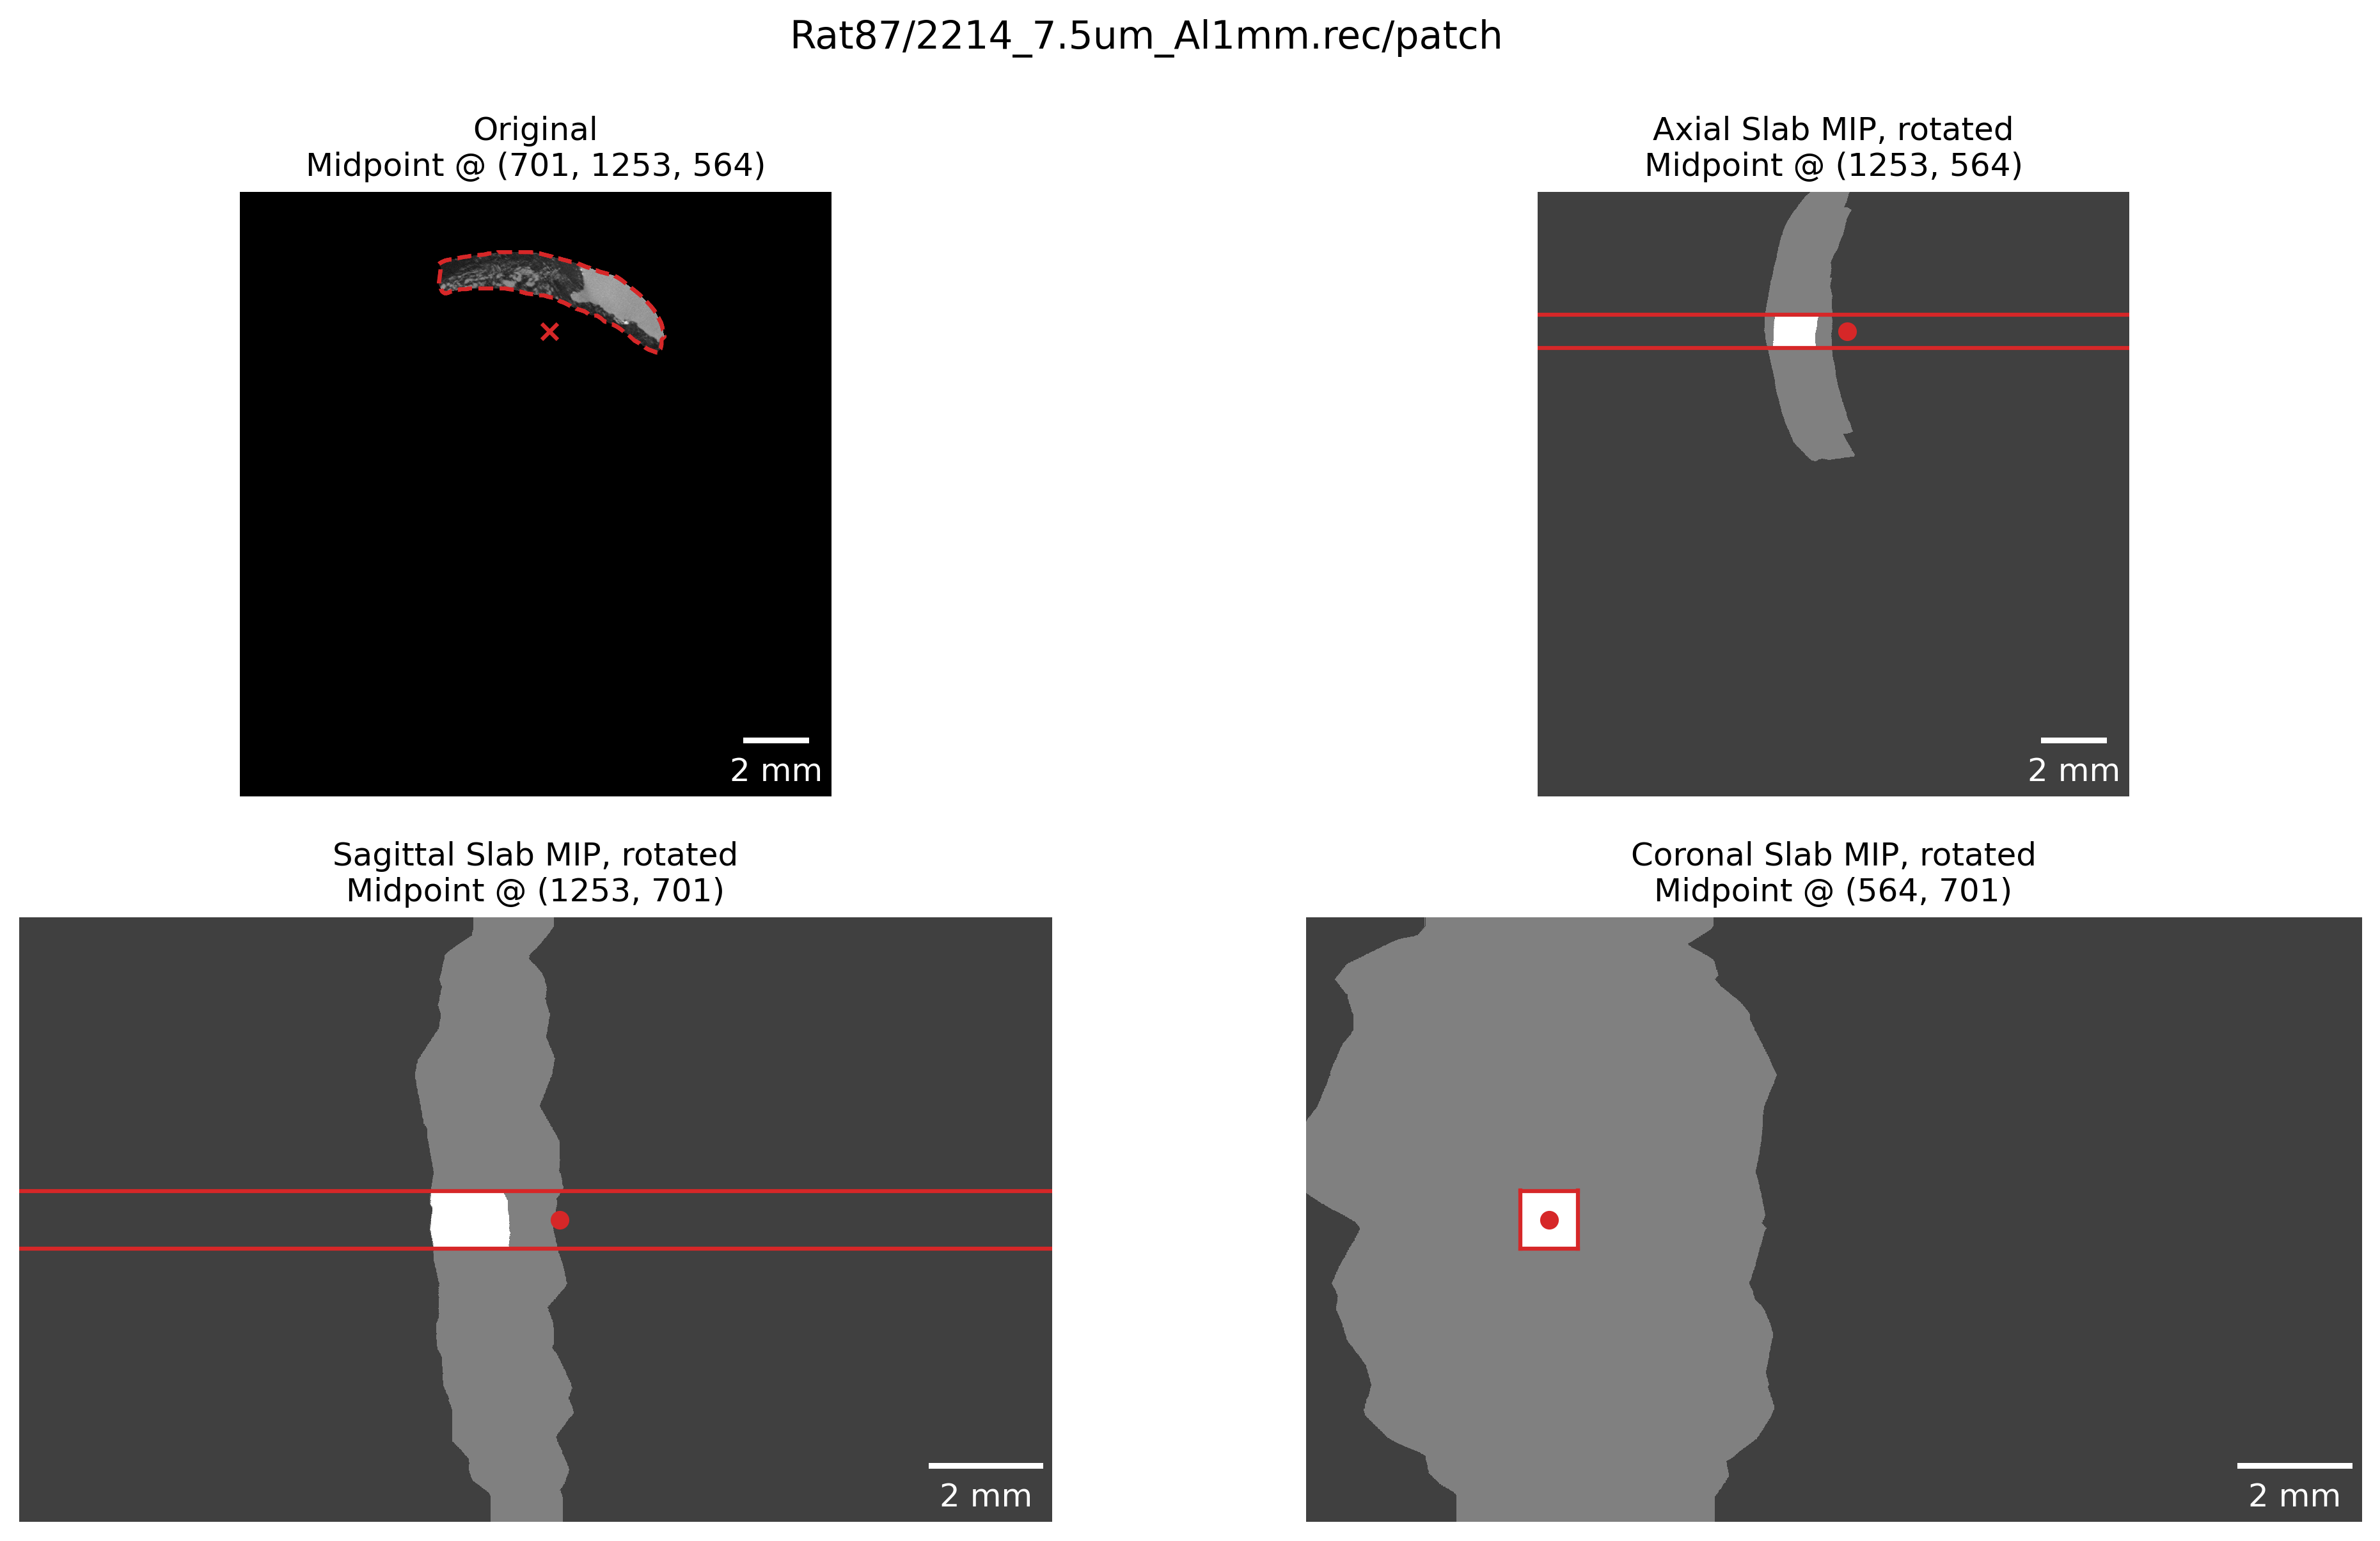

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [173]:
puncher_mask(55, radius_um=500, verbose=True)

In [174]:
# Cut out a binarized slab from all images
# Use same radius as defined above
# radius_um = 500  # um
Data['OutputNameSlab_binarized'] = ''
for c, row in tqdm(Data.iterrows(),
                   total=len(Data),
                   desc='Extracting binarized slabs'):
    # generate output name, then check if we actually need to do something :)
    Data.at[c, 'OutputNameSlab_binarized'] = row.OutputNameVOI_Binary.replace('.zarr',
                                                                              '.binary.rotated.midpoint%04d.%04d.angle%03d.slab.radius%04dum.zarr' % (Data['Midpoint'][c - c % 3 + 2][1],
                                                                                                                                               Data['Midpoint'][c - c % 3 + 2][2],
                                                                                                                                               int(round(Data['Angle'][c - c % 3 + 2])),
                                                                                                                                               radius_um))
    if not os.path.exists(Data['OutputNameSlab_binarized'][c]):
        Slab = puncher_mask(c, radius_um, verbose=True)
        print('Saving a slab of %s/%s to %s' % (row.Samplename,
                                                row.VOI,
                                                Data['OutputNameSlab_binarized'][c][len(Root):]))
        zarr.save(Data['OutputNameSlab_binarized'][c], Slab)

Extracting binarized slabs:   0%|          | 0/63 [00:00<?, ?it/s]

In [175]:
# Load slabs back in
Slabs_raw = [dask.array.from_zarr(file) for file in Data['OutputNameSlab']]
# We have to read the binarized slabs in a bool, otherwise the masking does NOT work
Slabs_binarized = [dask.array.from_zarr(file).astype('bool') for file in Data['OutputNameSlab_binarized']]

In [176]:
# Mask the raw VOI data with their extent, so we can use `nanmean` afterwards
# We mask with the inversion of the binary, so everything that is False is masked in the output
Slabs_masked = [dask.array.ma.masked_array(data=raw.astype('uint32'),
                                           mask=dask.array.invert(binarized))
                for raw, binarized in zip(Slabs_raw, Slabs_binarized)]
# If we save the masked VOIs out, we loose the masking!

In [177]:
whichone = 14

In [178]:
print('Looking at %s/%s/%s' % (Data['Samplename'][whichone],
                               Data['Scan'][whichone],
                               Data['VOI'][whichone]))

Looking at Rat64/cu_10um.rec/myocard_sans_patch


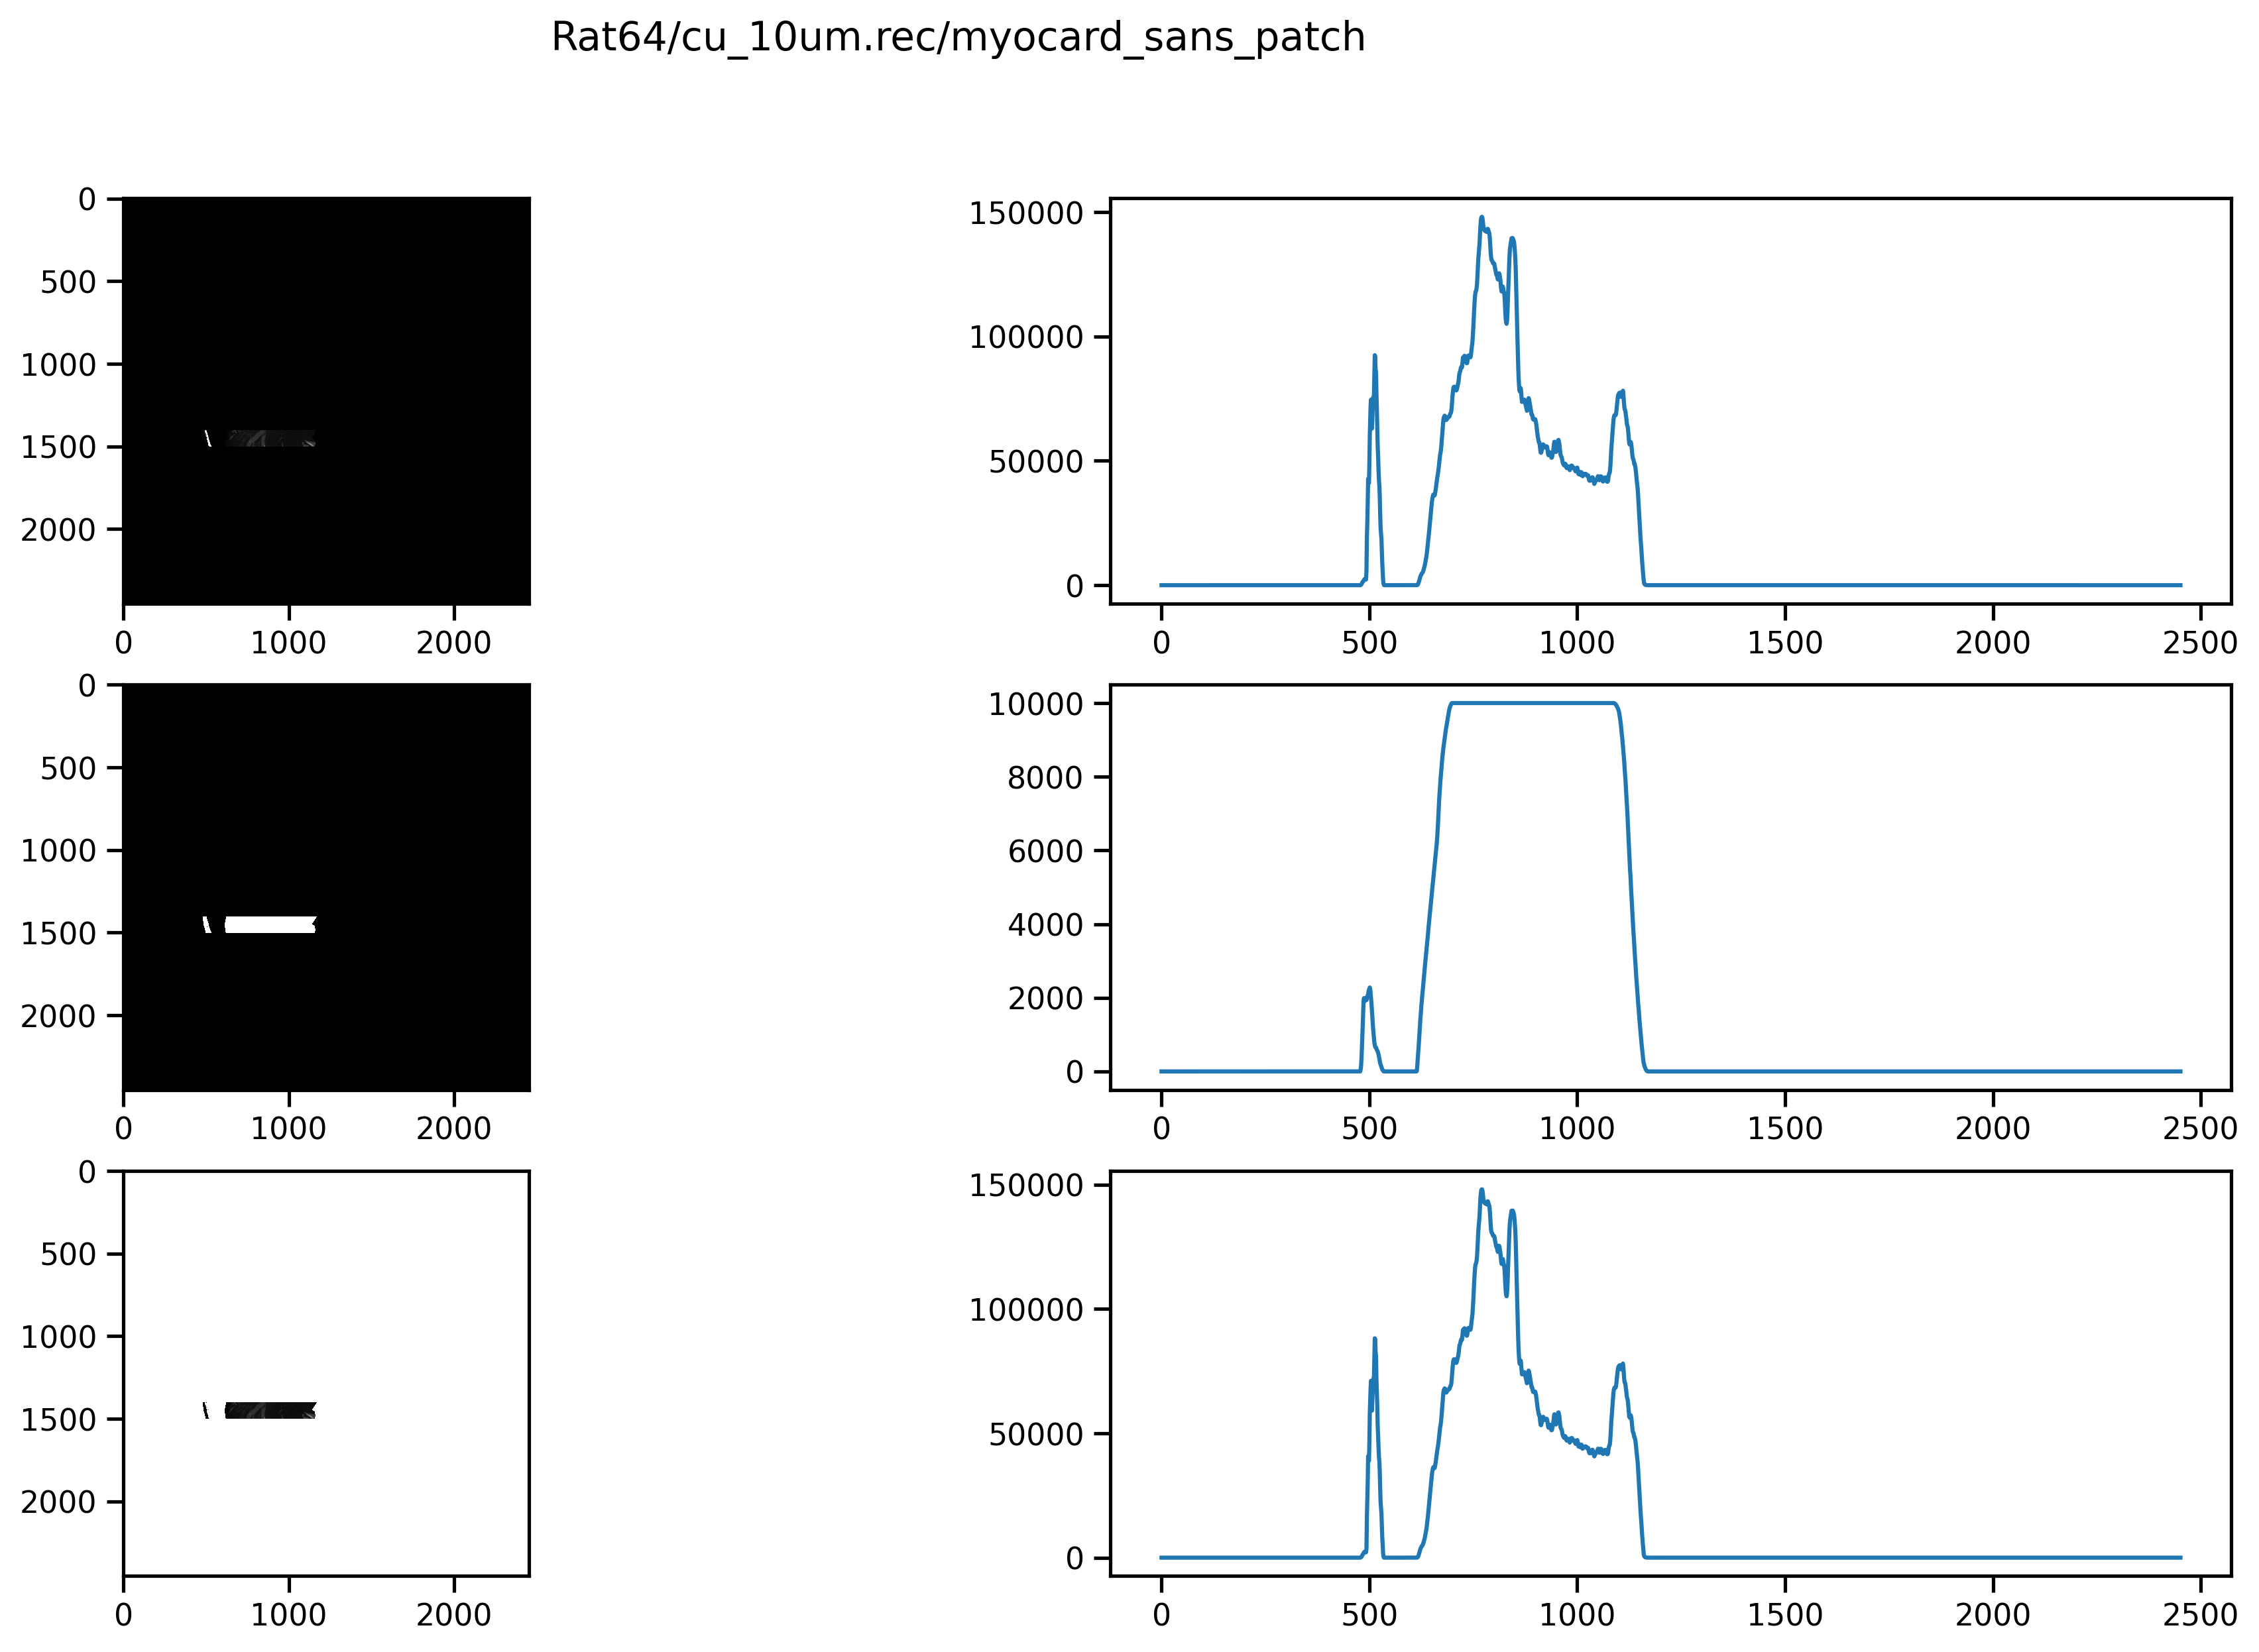

In [179]:
plt.subplot(321)
plt.imshow(Slabs_raw[whichone].max(axis=0))
plt.subplot(322)
plt.plot(dask.array.sum(
    dask.array.sum(
        Slabs_raw[whichone],
        axis=0),
    axis=0))
plt.subplot(323)
plt.imshow(Slabs_binarized[whichone].max(axis=0))
plt.subplot(324)
plt.plot(dask.array.sum(
    dask.array.sum(Slabs_binarized[whichone],
                   axis=0),
    axis=0)
         )
plt.subplot(325)
plt.imshow(Slabs_masked[whichone].max(axis=0))
plt.subplot(326)
plt.plot(dask.array.nansum(
    dask.array.nansum(
        Slabs_masked[whichone],
        axis=0),
    axis=0))
plt.suptitle('%s/%s/%s' % (Data['Samplename'][whichone],
                           Data['Scan'][whichone],
                           Data['VOI'][whichone]))
plt.show()

In [180]:
for i in Data:
    print(i)

LogFile
Folder
Samplename
Scan
Animal
Experiment
Timepoint
Gender
VOI
VOIFolder
VOIFile
VOIImages
Number of VOI slices
Scanner
Voxelsize
ColorTimepoint
ColorScanner
ColorExperiment
OutputNameVOI
OutputNameVOI_Binary
MiddleSliceNumber
VOIVolume
OutputNameVOI_Masked
VOIBrightness
VOI_Brightness_Mean
Image
ROI
Properties
Contour
Centroid
Orientation
Midpoint
Angle
Size
OutputNameVOIRotated
OutputNameVOIRotated_Binary
Image_rotated
ROI_rotated
OutputNameSlab
OutputNameSlab_binarized


In [ ]:
# Calculate slab MIPs as we need them below
Data['SlabMIP'] = [ms.max(axis=0).compute() for ms in Slabs_masked]

In [ ]:
for whichone in tqdm(range(0, len(Data), 3)):
    print(whichone)

In [ ]:
# Display what we calculated above
for whichone in range(0, len(Data), 3):
    plt.subplot(121)
    # Display original data
    plt.imshow(skimage.exposure.equalize_adapthist(Data['Image'][whichone]))
    # Overlay "myocard" and "patch" contours
    plt.plot(Data['Contour'][whichone + 0][0], Data['Contour'][whichone + 0][1],
             linestyle='dashed', color=Data['ColorExperiment'][whichone],
             label='%s outline' % Data['VOI'][whichone + 0])
    plt.plot(Data['Contour'][whichone + 1][0], Data['Contour'][whichone + 1][1],
             linestyle='dotted', color=Data['ColorExperiment'][whichone],
             label='%s outline' % Data['VOI'][whichone + 1])
    # Plot the centroids
    plt.scatter(Data['Centroid'][whichone + 1][0], Data['Centroid'][whichone + 1][1],
                color=seaborn.color_palette()[len(Data.Experiment.unique()) + 1], marker='x',
                label='%s centroid' % Data['VOI'][whichone + 1])
    plt.scatter(Data['Centroid'][whichone + 2][0], Data['Centroid'][whichone + 2][1],
                color=seaborn.color_palette()[len(Data.Experiment.unique()) + 2], marker='x',
                label='%s centroid' % Data['VOI'][whichone + 2])
    # Display the centerpoint
    plt.scatter(Data['Midpoint'][whichone + 2][1], Data['Midpoint'][whichone + 2][2],
                color=Data['ColorExperiment'][whichone], s=10, label='Rotation center')
    plt.axis('off')
    plt.title('Original slice %s of %s/%s' % (Data['MiddleSliceNumber'][whichone],
                                              Data['Samplename'][whichone],
                                              Data['Scan'][whichone]))
    plt.legend()
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
    plt.subplot(122)
    # Show rotated ROI
    plt.imshow(skimage.exposure.equalize_adapthist(Data['Image_rotated'][whichone]))
    plt.scatter(Data['Midpoint'][whichone + 2][1], Data['Midpoint'][whichone + 2][2],
                color=Data['ColorExperiment'][whichone], s=10, label='Rotation center')
    # Overlay contour, extracted on the fly
    contoursmyocard = skimage.measure.find_contours(Data['ROI_rotated'][whichone + 0])
    for c, contour in enumerate(contoursmyocard):
        # Sometimes we extract more than one contour, so just label the first (c=0)
        if c:
            plt.plot(contour[:, 1], contour[:, 0],
                     linestyle='dashed', color=Data['ColorExperiment'][whichone + 0])
        else:
            plt.plot(contour[:, 1], contour[:, 0],
                     linestyle='dashed', color=Data['ColorExperiment'][whichone + 0],
                     label='%s outline' % Data['VOI'][whichone])
    contourspatch = skimage.measure.find_contours(Data['ROI_rotated'][whichone + 1])
    for c, contour in enumerate(contourspatch):
        # Sometimes we extract more than one contour, so just label the first (c=0)
        if c:
            plt.plot(contour[:, 1], contour[:, 0],
                     linestyle='dotted', color=Data['ColorExperiment'][whichone + 1])
        else:
            plt.plot(contour[:, 1], contour[:, 0],
                     linestyle='dotted', color=Data['ColorExperiment'][whichone + 1],
                     label='%s outline' % Data['VOI'][whichone + 1])
    # Overlay slab MIP
    plt.imshow(Data['SlabMIP'][whichone], cmap='viridis')
    # Overlay gray value along slab
    plt.plot(dask.array.nansum(dask.array.nansum(Slabs_masked[whichone],axis=0),axis=0) / 5000,
             color=Data['ColorExperiment'][whichone],
             label='Gray value along slab [a.u.]')
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
    plt.axis('off')
    plt.title('Slice %s of %s/%s\nRotated by %s° around %s' % (Data['MiddleSliceNumber'][whichone],
                                                               Data['Samplename'][whichone],
                                                               Data['Scan'][whichone],
                                                               round(Data['Angle'][whichone + 2]),
                                                               Data['Midpoint'][whichone + 2]))
    plt.legend()
    plt.tight_layout
    # Save the image out
    outpath = os.path.join(os.path.dirname(Data['Folder'][whichone]), '%s.%s.SlabDoubleCheck.png' % (Data['Samplename'][whichone], Data['Scan'][whichone]))
    if not os.path.exists(outpath):
        plt.savefig(outpath,
                    facecolor='white', transparent=False,
                    bbox_inches='tight')
    outpath = os.path.join(OutputDir, Data['Experiment'][whichone], '%s.%s.SlabDoubleCheck.png' % (Data['Samplename'][whichone], Data['Scan'][whichone]))
    if not os.path.exists(outpath):
        plt.savefig(outpath,
                    facecolor='white', transparent=False,
                    bbox_inches='tight')
    plt.show()

In [182]:
print(OutputDir)

Output/0a56f5e


In [183]:
asdfasdfasdfasdf===

SyntaxError: invalid syntax (2410841197.py, line 1)

In [ ]:
# for c, row in Data.iterrows():
#     # Show middle slice of raw VOI with equalized histogram
#     plt.imshow(skimage.exposure.equalize_adapthist(row['Image_rotated']))
#     # Overlay contour, extracted on the fly
#     contours = skimage.measure.find_contours(row['ROI_rotated'])
#     for contour in contours:
#         plt.plot(contour[:, 1], contour[:, 0], alpha=0.5, c=row['ColorExperiment'])


    
#     # plt.imshow(row.Image_rotated)
#     # plt.title(row.Samplename, row.Scan, row.VOI)    
#     plt.show()
#     # show pizza slice
#     # show outline for both pizza slice and patch from Tim
#     # overlay outline of punch
#     # color accordingly to experiment
#     # Save to experiment folder

In [ ]:
# # Show for each sample the pizza slice, with overlay of the patch roi and the punch
# for c, row in tqdm(Data.iterrows(),
#                    total=len(Data),
#                    desc='Showing rotated datasets with overlaid ROI'):    
#     # Show middle slice of raw VOI with equalized histogram
#     plt.imshow(skimage.exposure.equalize_adapthist(VOIs_raw_rotated[c][row['MiddleSliceNumber']]))
#     # Overlay contour, which we'll extract on the fly
#     contours = skimage.measure.find_contours(VOIs_binarized_rotated[c][row['MiddleSliceNumber']].compute())
#     for contour in contours:
#         plt.plot(contour[:, 1], contour[:, 0], alpha=0.5, c=Data['ColorExperiment'][c])
#     if row['VOI'] == 'patch':
#         plt.title('%s/%s/%s/%s/slice %s\nPatch drawn by Tim, rotated' % (row['Samplename'],
#                                                                          row['Scan'],
#                                                                          row['VOI'],
#                                                                          row['Experiment'],
#                                                                          row['MiddleSliceNumber']))
#     elif row['VOI'] == 'myocard':
#         plt.title('%s/%s/%s/%s/slice %s\n"Pizza slice" drawn by Tim, rotated' % (row['Samplename'],
#                                                                                  row['Scan'],
#                                                                                  row['VOI'],
#                                                                                  row['Experiment'],
#                                                                                  row['MiddleSliceNumber']))
#     elif 'sans' in row['VOI']:
#         plt.title('%s: Raw M-P slice %s' % (row.Samplename, row['MiddleSliceNumber']))
#         plt.title('%s/%s/%s/%s/slice %s\nMyocard - Patch ROI, rotated' % (row['Samplename'],
#                                                                           row['Scan'],
#                                                                           row['VOI'],
#                                                                           row['Experiment'],
#                                                                           row['MiddleSliceNumber']))
#     plt.gca().add_artist(ScaleBar(row.Voxelsize, 'um'))
#     plt.axis('off')
#     # Save the image out
#     outpath = os.path.join(os.path.dirname(row['Folder']),
#                            '%s.%s.ROIOverlay.Rotated.%s.png' % (row['Samplename'], row['Scan'], row['VOI']))
#     if not os.path.exists(outpath):
#         plt.savefig(outpath,
#                     facecolor='white',
#                     transparent=False,
#                     bbox_inches='tight')
    
#     plt.show()

In [ ]:
asdfasdfasdf===

In [ ]:
for i in range(0, VOIs_raw[whichone].shape[0], 100):
    plt.imshow(VOIs_raw[whichone][i])
    plt.show()

In [ ]:
for c, dir in enumerate(directions):
    plt.subplot(1, 3, c+1)
    plt.title('%s/%s' % (c, dir))
    plt.imshow(VOIs_raw[whichone].max(axis=c))
plt.suptitle('%s/%s/%s' % (Data['Samplename'][whichone],
                           Data['Scan'][whichone],
                           Data['VOI'][whichone]))
plt.show()

In [ ]:
for c, dir in enumerate(directions):
    plt.subplot(1, 3, c+1)
    plt.title('%s/%s' % (c, dir))
    plt.imshow(VOIs_raw_rotated[whichone].max(axis=c))
plt.suptitle('%s/%s/%s' % (Data['Samplename'][whichone],
                           Data['Scan'][whichone],
                           Data['VOI'][whichone]))
plt.show()

In [ ]:
for c, dir in enumerate(directions):
    plt.subplot(1, 3, c+1)
    plt.title('%s/%s' % (c, dir))
    plt.imshow(Slabs_raw[whichone].max(axis=c))
plt.suptitle('%s/%s/%s' % (Data['Samplename'][whichone],
                           Data['Scan'][whichone],
                           Data['VOI'][whichone]))
plt.show()

In [ ]:
for c, dir in enumerate(directions):
    plt.subplot(1, 3, c+1)
    plt.title('%s/%s' % (c, dir))
    plt.imshow(Slabs_masked[whichone].max(axis=c))
plt.suptitle('%s/%s/%s' % (Data['Samplename'][whichone],
                           Data['Scan'][whichone],
                           Data['VOI'][whichone]))
plt.show()

In [ ]:
# Save SUMMED gray value  to dataframe
Data['GrayValueAlongSlab'] = ''
for whichone in tqdm(range(len(Data)), desc='Calculating gray value along slab'):
    Data.at[whichone, 'GrayValueAlongSlab'] = dask.array.nansum(dask.array.nansum(Slabs_masked[whichone],axis=0),axis=0).compute()

In [ ]:
# What's the maximum gray value we have
# Nice to have for scaling below
totalmax = 0
for gv in Data['GrayValueAlongSlab']:
    totalmax = numpy.maximum(gv.max(), totalmax)
print(totalmax)
print(totalmax/600)

In [ ]:
# Save out images for Ludovic to double-check
for whichone, row in tqdm(Data.iterrows(),
                          total=len(Data),
                          desc='Displaying gray value plot over image with coloured slab'):
    # Show middle slice of raw ROI
    plt.imshow(VOIs_raw_rotated[whichone][row['MiddleSliceNumber']])
    # Overlay middle slice of slab in colour
    plt.imshow(dask.array.ma.masked_invalid(Slabs_masked[whichone][row['MiddleSliceNumber']]),
               cmap='viridis')
    # Overlay contour, which we'll extract on the fly
    contours = skimage.measure.find_contours(VOIs_binarized_rotated[whichone][row['MiddleSliceNumber']].compute())
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], alpha=0.5, c=Data['ColorExperiment'][whichone])
      
    # Plot gray value on top of image (with changed axes, so up is big)
    # We scale the gray value, so it's nicely visible, but not normalized to image size.
    plt.plot(row['GrayValueAlongSlab'] / 500, color=row['ColorExperiment'])
    plt.xlim([0, Slabs_raw[whichone].shape[1]])
    plt.gca().invert_yaxis()
    plt.title('%s/%s/%s/%s\nSummed gray value overlaid' % (row['Samplename'],
                                                           row['Scan'],
                                                           row['VOI'],
                                                           row['Experiment']))
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
    plt.axis('off')
    # Save the image
    outpath = os.path.join(os.path.dirname(Data['Folder'][whichone]),
                           '%s.%s.SlabOverlay.Grayvalue.%s.png' % (row['Samplename'],
                                                                   row['Scan'],
                                                                   row['VOI']))
    # if not os.path.exists(outpath):
    plt.savefig(outpath,
                facecolor='white',
                transparent=False,
                bbox_inches='tight')
    plt.show()

In [ ]:
# https://stackoverflow.com/a/50011743/323100
def rescale_linear(array, new_min, new_max):
    """Rescale an arrary linearly."""
    minimum, maximum = numpy.min(array), numpy.max(array)
    m = (new_max - new_min) / (maximum - minimum)
    b = new_min - m * minimum
    return m * array + b

In [ ]:
# for c, gvas in enumerate(Data['GrayValueAlongSlab']):
#     print(Data['Samplename'][c])
#     rescale_linear(gvas, 0, 1)

In [ ]:
# Normalize gray value along slab
Data['GrayValueAlongSlabNormalized'] = [rescale_linear(gvas, 0, 1) for gvas in Data['GrayValueAlongSlab']]

In [ ]:
for exp in Data.Experiment.unique():
    print(40*'--', exp, 40*'--', exp)
    print(Data[Data.Experiment == exp][['Samplename', 'Scan', 'VOI']])

In [ ]:
# Get us some details
Data[Data.VOI == 'myocard_sans_patch'].groupby('Experiment').describe()

In [ ]:
Data[Data.VOI == 'myocard'].groupby('Experiment').describe()

In [ ]:
# plt.rcParams['figure.figsize'] = (16,9)  # Size up figures a bit

In [ ]:
# for exp in Data.Experiment.unique():
#     for voi in Data.VOI.unique():
#         for c, i in Data[(Data.Experiment == exp) & (Data.VOI == voi)].iterrows():
#             plt.plot(numpy.ma.masked_equal(i.GrayValueAlongSlab, 0).compressed())

In [ ]:
# Plot the original data
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through every VOI value
    for d, voi in enumerate(Data[Data.Experiment == exp].VOI.unique()):
        # Generate figure axis
        ax = fig.add_subplot(gs[d, c], label=numpy.random.random() * c + d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI == voi)].iterrows():
            plt.plot(row.GrayValueAlongSlab,
                     color=row.ColorTimepoint,
                     label=('%s (d %0.f)' % (row.Samplename.replace('Rat', ''),
                                             row.Timepoint)))
        plt.legend()
        if not d:
            plt.title(exp)
        if not c:
            if voi == 'myocard':
                plt.ylabel('Full data')
            elif voi == 'patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d == 2:
            plt.xlabel('px')
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.RawData.png'),
            facecolor='white', transparent=False,
            bbox_inches='tight')
plt.show()

In [ ]:
# Plot the original data
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through every VOI value
    for d, voi in enumerate(Data[Data.Experiment == exp].VOI.unique()):
        # Generate figure axis
        ax = fig.add_subplot(gs[d, c], label=numpy.random.random() * c + d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI == voi)].iterrows():
            plt.plot(row.GrayValueAlongSlabNormalized,
                     color=row.ColorTimepoint,
                     label=('%s (d %0.f)' % (row.Samplename.replace('Rat', ''),
                                             row.Timepoint)))
        plt.legend()
        if not d:
            plt.title(exp)
        if not c:
            if voi == 'myocard':
                plt.ylabel('Full data')
            elif voi == 'patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d == 2:
            plt.xlabel('px')
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.RawData.png'),
            facecolor='white', transparent=False,
            bbox_inches='tight')
plt.show()

In [ ]:
# What is going on with Rat82?
Data[Data.Samplename == 'Rat82'][['Samplename', 'Scan', 'Folder']]

In [ ]:
# We have different *sizes* of images, e.g. the 'gray value along the slab' array has a different length
# Outside of the VOI, the values are zero, so we trim to only 'central' part with `numpy.trim_zeros` (https://stackoverflow.com/a/34593911/323100)
Data['GrayValueAlongSlab_trimmed_edges'] = [numpy.trim_zeros(gvas) for gvas in Data['GrayValueAlongSlab']]

In [ ]:
# Plot the trimmed data
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through every VOI value
    for d, voi in enumerate(Data[Data.Experiment == exp].VOI.unique()):
        # Generate figure axis
        ax = fig.add_subplot(gs[d, c], label=numpy.random.random() * c + d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI == voi)].iterrows():
            plt.plot(row.GrayValueAlongSlab_trimmed_edges,
                     color=row.ColorTimepoint,
                     label=('%s (d %0.f)' % (row.Samplename.replace('Rat', ''),
                                             row.Timepoint)))
        plt.legend()
        if not d:
            plt.title(exp)
        if not c:
            if voi == 'myocard':
                plt.ylabel('Full data')
            elif voi == 'patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d == 2:
            plt.xlabel('px')
        plt.xlim([0, 1111])
# plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.TrimmedEdges.png'),
#             facecolor='white', transparent=False,
#             bbox_inches='tight')
plt.show()

In [ ]:
# Do *not* actually just trim the msp peak (from not perfect delieation from Tim) at the start,
# but get rid of it by simply overwriting it with '0', so we can still plot everything with the same length below
for d, row in Data[Data.VOI == 'myocard_sans_patch'].iterrows():  # only for msp
    row['GrayValueAlongSlab_trimmed_edges'][:125] = 0  # '125' is an empirically found value to discard everything from the peak but not more

In [ ]:
Data.head()

In [ ]:
# Plot the trimmed data without msp peak at the start
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through every VOI value
    for d, voi in enumerate(Data[Data.Experiment == exp].VOI.unique()):
        # Generate figure axis
        ax = fig.add_subplot(gs[d, c], label=numpy.random.random() * c + d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI == voi)].iterrows():
            plt.plot(row.GrayValueAlongSlab_trimmed_edges,
                     color=row.ColorTimepoint,
                     label=('%s (d %0.f)' % (row.Samplename.replace('Rat', ''),
                                             row.Timepoint)))
        plt.legend()
        if not d:
            plt.title(exp)
        if not c:
            if voi == 'myocard':
                plt.ylabel('Full data')
            elif voi == 'patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d == 2:
            plt.xlabel('px')
# plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.msp_peak_trim.png'),
#             facecolor='white', transparent=False,
#             bbox_inches='tight')
plt.show()

In [ ]:
# for c, gvas in enumerate(Data['GrayValueAlongSlab_trimmed_edges']):
#     print(Data['Samplename'][c])
#     rescale_linear(gvas, 0, 1)

In [ ]:
# Normalize values
Data['GrayValueAlongSlab_trimmed_edgesNormalized'] = [rescale_linear(gvas, 0, 1) for gvas in Data['GrayValueAlongSlab_trimmed_edges']]

In [ ]:
# Plot the trimmed data without msp peak at the start
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through every VOI value
    for d, voi in enumerate(Data[Data.Experiment == exp].VOI.unique()):
        # Generate figure axis
        ax = fig.add_subplot(gs[d, c], label=numpy.random.random() * c + d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI == voi)].iterrows():
            plt.plot(row.GrayValueAlongSlab_trimmed_edgesNormalized,
                     color=row.ColorTimepoint,
                     label=('%s (d %0.f)' % (row.Samplename.replace('Rat', ''),
                                             row.Timepoint)))
        plt.legend()
        if not d:
            plt.title(exp)
        if not c:
            if voi == 'myocard':
                plt.ylabel('Full data')
            elif voi == 'patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d == 2:
            plt.xlabel('px')
# plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.msp_peak_trim.png'),
#             facecolor='white', transparent=False,
#             bbox_inches='tight')
plt.show()

In [ ]:
# After the discussion with Ludovic on 01.12.22 it dawned on me that we *have* to set the origin of all our plots on the heart surface
# and not on the surface of the sample (which includes the patch)
# Since we're masking out the peak from the subtraction above, we can just `numpy.trim_zeros` the *start* of *all* the gray values.
# This does only something for the the gray values of the msp data and thus we can do a little happy dance :)
Data['GrayValueAlongSlab_fully_trimmed'] = [numpy.trim_zeros(gvas, trim='f') for gvas in Data['GrayValueAlongSlab_trimmed_edges']]

In [ ]:
# Generate us an mm x-axis scale
# We want to plot in mm, so divide by 1000
# Since we discareded the msp peak above, we can front-trim all the gray values again.
Data['XAxisScale_Pixelsize'] = [[row.Voxelsize * i / 1000 for i in list(range(len(gvas)))] for vs, gvas in zip(Data.Voxelsize, Data.GrayValueAlongSlab_fully_trimmed)]

In [ ]:
# Save rounded maximum gray value along slab into dataframe, to use for plotting
Data['GrayValueAlongSlabMax'] = ''
for d, gvas in enumerate(Data['GrayValueAlongSlab_trimmed_edges']):
    Data.at[d, 'GrayValueAlongSlabMax'] = gvas.max()
# Print the common maximal gray value, rounded up
for d, voi in enumerate(Data.VOI.unique()):
    print(voi, int(numpy.ceil(round(Data[Data.VOI == voi]['GrayValueAlongSlabMax'].max() / 1e4, 5)) * 1e4))

In [ ]:
# Save maximum 'depth' value into dataframe
Data['SlabLength'] = ''
for d, mm in enumerate(Data['XAxisScale_Pixelsize']):
    Data.at[d, 'SlabLength'] = max(mm)
# Print the common maximal value
for d, voi in enumerate(Data.VOI.unique()):
    print(voi, round(Data[Data.VOI == voi]['SlabLength'].max()) + 1)

In [ ]:
# Plot the trimmed data without msp peak at the start, with the x-axis in SI values
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through every VOI value
    for d, voi in enumerate(Data[Data.Experiment == exp].VOI.unique()):
        # Generate figure axis
        ax = fig.add_subplot(gs[d, c], label=numpy.random.random() * c + d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI == voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmed),
                         color=row.ColorTimepoint,
                         label=('%s (d %0.f)' % (row.Samplename.replace('Rat', ''),
                                                 row.Timepoint)))
                plt.xlim([1, 0])
                plt.ylim(ymax=320000)
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmed,
                         color=row.ColorTimepoint,
                         label=('%s (d %0.f)' % (row.Samplename.replace('Rat', ''),
                                                 row.Timepoint)))
                if voi == 'myocard':
                    # Adjust the xlim to the maximum value
                    plt.xlim(right=numpy.ceil(Data['SlabLength'].max()))
                    # Adjust the ylim to the maximum value rounded up to the next 1e5
                    plt.ylim(top=numpy.ceil(round(Data[Data.VOI == voi]['GrayValueAlongSlabMax'].max() / 1e5, 2)) * 1e5)
                else:
                    # Adjust to show only X mm depth
                    plt.xlim([0, 2])
                    plt.ylim(ymax=320000)
        # Legends and labeling
        plt.legend(loc='best')
        if not d:  # 'not d' -> Top row. Only this row gets a title
            plt.title(exp)
        if not c:  # 'not c' --> First colum. Only this columng gets a y-label
            if voi == 'myocard':
                plt.ylabel('Full data')
            elif voi == 'patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d == 2:  # Only bottom row gets an x-label
            plt.xlabel('mm')
# plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Origin-At-Heartsurface.All.png'),
#             facecolor='white', transparent=False,
#             bbox_inches='tight')
plt.show()

In [ ]:
# Normalize values
Data['GrayValueAlongSlab_fully_trimmedNormalized'] = [rescale_linear(gvas, 0, 1) for gvas in Data['GrayValueAlongSlab_fully_trimmed']]

In [ ]:
# Plot the trimmed data without msp peak at the start, with the x-axis in SI values
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through every VOI value
    for d, voi in enumerate(Data[Data.Experiment == exp].VOI.unique()):
        # Generate figure axis
        ax = fig.add_subplot(gs[d, c], label=numpy.random.random() * c + d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI == voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                         color=row.ColorTimepoint,
                         label=('%s (d %0.f)' % (row.Samplename.replace('Rat', ''),
                                                 row.Timepoint)))
                plt.xlim([1.0, -0.1])
#                 plt.ylim(ymax=320000)
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                         color=row.ColorTimepoint,
                         label=('%s (d %0.f)' % (row.Samplename.replace('Rat', ''),
                                                 row.Timepoint)))
                if voi == 'myocard':
                    # Adjust the xlim to the maximum value
                    plt.xlim(right=numpy.ceil(Data['SlabLength'].max()))
                    # Adjust the ylim to the maximum value rounded up to the next 1e5
#                     plt.ylim(top=numpy.ceil(round(Data[Data.VOI==voi]['GrayValueAlongSlabMax'].max() / 1e5, 2)) * 1e5)
                else:
                    # Adjust to show only X mm depth
                    plt.xlim([-0.1, 2])
#                     plt.ylim(ymax=320000)
        # Legends and labeling
        plt.legend()
        if not d:  # 'not d' -> Top row. Only this row gets a title
            plt.title(exp)
        if not c:  # 'not c' --> First colum. Only this columng gets a y-label
            if voi == 'myocard':
                plt.ylabel('Full data')
            elif voi == 'patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d == 2:  # Only bottom row gets an x-label
            plt.xlabel('mm')
# plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.All.png'),
#             facecolor='white', transparent=False,
#             bbox_inches='tight')
plt.show()

In [ ]:
# Plot the trimmed data without msp peak at the start, with the x-axis in SI values
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through every VOI value
    for d, voi in enumerate(Data[Data.Experiment == exp].VOI.unique()):
        # Generate figure axis
        ax = fig.add_subplot(gs[d, c], label=numpy.random.random() * c + d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI == voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                         # color=row.ColorTimepoint,
                         label=('%s' % (row.Samplename.replace('Rat', ''))))
                plt.xlim([1.0, -0.1])
#                 plt.ylim(ymax=2.75e5)
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                         # color=row.ColorTimepoint,
                         label=('%s' % (row.Samplename.replace('Rat', ''))))
                if voi == 'myocard':
                    # Adjust the xlim to the maximum value
                    plt.xlim(right=numpy.ceil(Data['SlabLength'].max()))
                    # Adjust the ylim to the maximum value rounded up to the next 1e5
#                     plt.ylim(top=numpy.ceil(round(Data[Data.VOI==voi]['GrayValueAlongSlabMax'].max() / 1e5, 2)) * 1e5)
                else:
                    pass
                    # Adjust to show only X mm depth
                    plt.xlim([-0.1, 1])
#                     plt.ylim(ymax=2.75e5)
        # Legends and labeling
        # plt.legend(loc='best')
        if not d:  # 'not d' -> Top row. Only this row gets a title
            plt.title(exp)
        if not c:  # 'not c' --> First colum. Only this columng gets a y-label
            if voi == 'myocard':
                plt.ylabel('Full data')
            elif voi == 'patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d == 2:  # Only bottom row gets an x-label
            plt.xlabel('mm')
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.All.Colorized.png'),
            facecolor='white', transparent=False,
            bbox_inches='tight')
plt.show()

In [ ]:
# Plot the trimmed data without msp peak at the start, with the x-axis in SI values
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through every VOI value
    for d, voi in enumerate(Data[Data.Experiment == exp].VOI.unique()):
        # Generate figure axis
        ax = fig.add_subplot(gs[d, c], label=numpy.random.random() * c + d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI == voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                         # color=row.ColorTimepoint,
                         label=('%s/%s (d %0.f)' % (row.Samplename.replace('Rat', ''),
                                                    row.Scan.replace('.rec', ''),
                                                    row.Timepoint)))
                plt.xlim([1.0, -0.1])
                # plt.ylim(ymax=2.75e5)
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                         # color=row.ColorTimepoint,
                         label=('%s/%s (d %0.f)' % (row.Samplename.replace('Rat', ''),
                                                    row.Scan.replace('.rec', ''),
                                                    row.Timepoint)))
                if voi == 'myocard':
                    # Adjust the xlim to the maximum value
                    plt.xlim(right=numpy.ceil(Data['SlabLength'].max()))
                    # Adjust the ylim to the maximum value rounded up to the next 1e5
                    # plt.ylim(top=numpy.ceil(round(Data[Data.VOI==voi]['GrayValueAlongSlabMax'].max() / 1e5, 2)) * 1e5)
                else:
                    pass
                    # Adjust to show only X mm depth
                    plt.xlim([-0.1, 4])
                    # plt.ylim(ymax=2.75e5)
        # Legends and labeling
        # plt.legend(loc='best')
        if not d:  # 'not d' -> Top row. Only this row gets a title
            plt.title(exp)
        if not c:  # 'not c' --> First colum. Only this columng gets a y-label
            if voi == 'myocard':
                plt.ylabel('Full data')
            elif voi == 'patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d == 2:  # Only bottom row gets an x-label
            plt.xlabel('mm')
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.All.Colorized.NoLabels.png'),
            facecolor='white', transparent=False,
            bbox_inches='tight')
plt.show()

In [ ]:
Data[Data.Samplename == 'Rat82']

In [ ]:
print('Dropping the "cu_10um" scan of Rat82')
Data = Data.drop(Data[(Data.Samplename == 'Rat82') & (Data.Scan == 'cu_10um.rec')].index)
print('This scan duplicates Dropping the "cu_10um" scan of Rat82')

In [ ]:
len(Data)

In [ ]:
# Plot the data without Rat82/cu_10um
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through VOIs we need
    for d, voi in enumerate(['patch', 'myocard_sans_patch']):
        # Generate figure axis
        ax = fig.add_subplot(gs[d, c], label=numpy.random.random() * c + d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI == voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                         color=row.ColorTimepoint,
                         label=(row.Samplename.replace('Rat', '')))
                plt.xlim([1.0, -0.1])
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                         color=row.ColorTimepoint,
                         label=(row.Samplename.replace('Rat', '')))
                plt.xlim([-0.1, 1.0])
        # Legends and labeling
        plt.legend(loc='best')
        if not d:  # 'not d' -> Top row. Only this row gets a title
            plt.title(exp)
        if not c:  # 'not c' --> First colum. Only this columng gets a y-label
            if voi == 'patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d:  # Only bottom row gets an x-label
            plt.xlabel('mm')
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.Color.Timepoint.png'),
            facecolor='white',
            transparent=False,
            bbox_inches='tight')
plt.show()

In [ ]:
# Plot the data without Rat82/cu_10um
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through VOIs we need
    for d, voi in enumerate(['patch', 'myocard_sans_patch']):
        # Generate figure axis
        ax = fig.add_subplot(gs[d, c], label=numpy.random.random() * c + d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI == voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                         color=row.ColorScanner,
                         label=(row.Samplename.replace('Rat', '')))
                plt.xlim([1.0, -0.1])
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                         color=row.ColorScanner,
                         label=(row.Samplename.replace('Rat', '')))
                plt.xlim([-0.1, 1.0])
        # Legends and labeling
        plt.legend(loc='best')
        if not d:  # 'not d' -> Top row. Only this row gets a title
            plt.title(exp)
        if not c:  # 'not c' --> First colum. Only this columng gets a y-label
            if voi == 'patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d:  # Only bottom row gets an x-label
            plt.xlabel('mm')
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.Color.Scanner.png'),
            facecolor='white',
            transparent=False,
            bbox_inches='tight')
plt.show()

In [ ]:
# Plot the data without Rat82/cu_10um
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through VOIs we need
    for d, voi in enumerate(['patch', 'myocard_sans_patch']):
        # Generate figure axis
        ax = fig.add_subplot(gs[d, c], label=numpy.random.random() * c + d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI == voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                         label=(row.Samplename.replace('Rat', '')))
                plt.xlim([1.0, -0.1])
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                         label=(row.Samplename.replace('Rat', '')))
                plt.xlim([-0.1, 1.0])
        # Legends and labeling
        if not d:  # 'not d' -> Top row. Only this row gets a title and the legend on the upper left
            plt.title(exp)
            plt.legend(loc='upper left')
        if not c:  # 'not c' --> First colum.
            # Only this column gets a y-label
            if voi == 'patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d:  # Only bottom row gets an x-label and the legend on the upper right
            plt.xlabel('mm')
            plt.legend(loc='upper right')
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.SingleAnimalColor.02mm.png'),
            facecolor='white',
            transparent=False,
            bbox_inches='tight')
plt.show()

In [ ]:
# Plot the data without Rat82/cu_10um
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through VOIs we need
    for d, voi in enumerate(['patch', 'myocard_sans_patch']):
        # Generate figure axis
        ax = fig.add_subplot(gs[d, c], label=numpy.random.random() * c + d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI == voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                         color=row.ColorExperiment,
                         label=(row.Samplename.replace('Rat', 'R')))
                plt.xlim([1.0, -0.1])
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                         color=row.ColorExperiment,
                         label=(row.Samplename.replace('Rat', 'R')))
                plt.xlim([-0.1, 5])
        # Legends and labeling
        if not d:  # 'not d' -> Top row. Only this row gets a title and the legend on the upper left
            plt.title(exp)
            plt.legend(loc='upper left')
        if not c:  # 'not c' --> First colum.
            # Only this column gets a y-label
            if voi == 'patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d:  # Only bottom row gets an x-label and the legend on the upper right
            plt.xlabel('mm')
            plt.legend(loc='upper right')
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.SingleAnimalColor.05mm.png'),
            facecolor='white',
            transparent=False,
            bbox_inches='tight')
plt.show()

In [ ]:
# Deduplicate legend items
# https://stackoverflow.com/a/56253636/323100
def legend_without_duplicate_labels(ax, loc='best'):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc=loc)

In [ ]:
# Plot the data without Rat82/cu_10um
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through VOIs we need
    for d, voi in enumerate(['patch', 'myocard_sans_patch']):
        # Generate figure axis
        ax = fig.add_subplot(gs[d, c], label=numpy.random.random() * c + d)
        for e, row in Data[(Data.Experiment == exp) & (Data.VOI == voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                         color=row.ColorTimepoint,
                         label='d%s' % int(row.Timepoint))
                plt.xlim([1.0, -0.1])
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                         color=row.ColorTimepoint,
                         label='d%s' % int(row.Timepoint))
                plt.xlim([-0.1, 1.0])
        # Legends and labeling
        if not d:  # 'not d' -> Top row. Only this row gets a title and the legend on the upper left
            plt.title(exp)
            legend_without_duplicate_labels(ax, loc='upper left')
        if not c:  # 'not c' --> First colum.
            # Only this column gets a y-label
            if voi == 'patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d:  # Only bottom row gets an x-label and the legend on the upper right
            plt.xlabel('mm')
            legend_without_duplicate_labels(ax, loc='upper right')
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.png'),
            facecolor='white',
            transparent=False,
            bbox_inches='tight')
plt.show()

In [ ]:
Data.Experiment.unique()

In [ ]:
Data.Timepoint.unique()

In [ ]:
Data.VOI.unique()

In [ ]:
Data[(Data.Experiment != 'tachosil only') & (Data.Timepoint == 28)].head()

In [ ]:
# Save us a subset of the data
Subset28 = Data[(Data.Experiment != 'tachosil only') & (Data.Timepoint == 28)].sort_values(by='Experiment')
Subset07 = Data[(Data.Experiment != 'tachosil only') & (Data.Timepoint == 7)].sort_values(by='Experiment')

In [ ]:
Subset28.Experiment.unique()

In [ ]:
Subset07.Experiment.unique()

In [ ]:
Subset07.Timepoint.unique()

In [ ]:
Subset28.Timepoint.unique()

In [ ]:
len(Data.Experiment.unique())

In [ ]:
# Cycle line style: https://stackoverflow.com/a/50372664/323100
# plt.rc('axes', prop_cycle=(cycler('linestyle', ['-', '--', ':', '-.'])))

In [ ]:
# Plot the data without Rat82/cu_10um
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through VOIs we need
    for d, voi in enumerate(['patch', 'myocard_sans_patch']):
        # Generate figure axis
        ax = fig.add_subplot(gs[d, c], label=numpy.random.random() * c + d)
        for e, row in Subset07[(Subset07.Experiment == exp) & (Subset07.VOI == voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                         color=row.ColorExperiment,
                         label=row.Samplename)
                plt.xlim([1.0, -0.1])
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                         color=row.ColorExperiment,
                         label=row.Samplename)
                plt.xlim([-0.1, 1.0])
        # Legends and labeling
        if not d:  # 'not d' -> Top row. Only this row gets a title and the legend on the upper left
            plt.title(exp)
            legend_without_duplicate_labels(ax, loc='upper left')
        if not c:  # 'not c' --> First colum.
            # Only this column gets a y-label
            if voi == 'patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d:  # Only bottom row gets an x-label and the legend on the upper right
            plt.xlabel('mm')
            legend_without_duplicate_labels(ax, loc='upper right')
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.Day07.png'),
            facecolor='white',
            transparent=False,
            bbox_inches='tight')
if 'anaklin04' in platform.node():
    # Save to OneDrive folder shared with Ludovic
    plt.savefig(os.path.join('C:',
                             'Users',
                             'haberthu',
                             'OneDrive - Universitaet Bern',
                             'Heart Neoangiogenesis Project',
                             'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.Day07.png'),
                facecolor='white',
                transparent=False,
                bbox_inches='tight')
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)  # Size up figures a bit
for c, row in Subset07.iterrows():
    if row.VOI == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
        plt.subplot(211)
        plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                 color=row.ColorExperiment,
                 label=row.Samplename)
        plt.xlim([1.0, -0.1])
        plt.xlabel('mm')
        plt.ylabel('Gray value curve in patch')
        plt.legend()
    elif row.VOI == 'myocard_sans_patch':
        plt.subplot(212)
        plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                 color=row.ColorExperiment,
                 label=row.Samplename)
        plt.xlim([-0.1, 1.0])
        plt.legend()
        plt.xlabel('mm')
        plt.ylabel('Gray value curve in myocard')
        plt.legend()
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.Day07.AllTogether.png'),
            facecolor='white',
            transparent=False,
            bbox_inches='tight')
if 'anaklin04' in platform.node():
    # Save to OneDrive folder shared with Ludovic
    plt.savefig(os.path.join('C:',
                             'Users',
                             'haberthu',
                             'OneDrive - Universitaet Bern',
                             'Heart Neoangiogenesis Project',
                             'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.Day07.AllTogether.png'),
                facecolor='white',
                transparent=False,
                bbox_inches='tight')
plt.show()
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [ ]:
# Plot the data without Rat82/cu_10um
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=len(Data.Experiment.unique()),
                       nrows=len(Data.VOI.unique()),
                       figure=fig)
# Iterate through each experiment value
for c, exp in enumerate(DisplayOrderExperiments):
    # Iterate through VOIs we need
    for d, voi in enumerate(['patch', 'myocard_sans_patch']):
        # Generate figure axis
        ax = fig.add_subplot(gs[d, c], label=numpy.random.random() * c + d)
        for e, row in Subset28[(Subset28.Experiment == exp) & (Subset28.VOI == voi)].iterrows():
            # Patch needs to be flipped, Myocard and MSP not
            if voi == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
                plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                         color=row.ColorExperiment,
                         label=row.Samplename)
                plt.xlim([1.0, -0.1])
            else:
                plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                         color=row.ColorExperiment,
                         label=row.Samplename)
                plt.xlim([-0.1, 1.0])
        # Legends and labeling
        if not d:  # 'not d' -> Top row. Only this row gets a title and the legend on the upper left
            plt.title(exp)
            legend_without_duplicate_labels(ax, loc='upper left')
        if not c:  # 'not c' --> First colum.
            # Only this column gets a y-label
            if voi == 'patch':
                plt.ylabel('Gray value curve in patch')
            else:
                plt.ylabel('Gray value curve in myocard')
        if d:  # Only bottom row gets an x-label and the legend on the upper right
            plt.xlabel('mm')
            legend_without_duplicate_labels(ax, loc='upper right')
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.Day28.png'),
            facecolor='white',
            transparent=False,
            bbox_inches='tight')
if 'anaklin04' in platform.node():
    # Save to OneDrive folder shared with Ludovic
    plt.savefig(os.path.join('C:',
                             'Users',
                             'haberthu',
                             'OneDrive - Universitaet Bern',
                             'Heart Neoangiogenesis Project', 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.Day28.png'),
                facecolor='white',
                transparent=False,
                bbox_inches='tight')
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)  # Size up figures a bit
for c, row in Subset28.iterrows():
    if row.VOI == 'patch':  # Flip the values and plot them the 'wrong way', so 0 is to the right
        plt.subplot(211)
        plt.plot(row.XAxisScale_Pixelsize, numpy.flip(row.GrayValueAlongSlab_fully_trimmedNormalized),
                 color=row.ColorExperiment,
                 label=row.Samplename)
        plt.xlim([1.0, -0.1])
        plt.xlabel('mm')
        plt.ylabel('Gray value curve in patch')
        plt.legend()
    elif row.VOI == 'myocard_sans_patch':
        plt.subplot(212)
        plt.plot(row.XAxisScale_Pixelsize, row.GrayValueAlongSlab_fully_trimmedNormalized,
                 color=row.ColorExperiment,
                 label=row.Samplename)
        plt.xlim([-0.1, 1.0])
        plt.legend()
        plt.xlabel('mm')
        plt.ylabel('Gray value curve in myocard')
        plt.legend()
legend_without_duplicate_labels(ax, loc='upper right')
plt.savefig(os.path.join(OutputDir, 'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.Day28.AllTogether.png'),
            facecolor='white',
            transparent=False,
            bbox_inches='tight')
if 'anaklin04' in platform.node():
    # Save to OneDrive folder shared with Ludovic
    plt.savefig(os.path.join('C:',
                             'Users',
                             'haberthu',
                             'OneDrive - Universitaet Bern',
                             'Heart Neoangiogenesis Project',
                             'GrayValuesAlongSlab.Normalized.Origin-At-Heartsurface.Day28.AllTogether.png'),
                facecolor='white',
                transparent=False,
                bbox_inches='tight')
plt.show()
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [ ]:
print('Done')
print('Saved all images to %s' % OutputDir)
if 'anaklin04' in platform.node():
    print('Saved all images to %s, too' % os.path.join('C:',
                                                       'Users',
                                                       'haberthu',
                                                       'OneDrive - Universitaet Bern',
                                                       'Heart Neoangiogenesis Project'))